In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import shap
from pathlib import Path
from itertools import cycle
from matplotlib.lines import Line2D
import matplotlib as mpl
import mplhep as mh
mh.style.use("CMS")

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [8]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

In [124]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_gen.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_Ref.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p0113.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p016.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p03.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p045.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_gen.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_Ref.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p0113.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p016.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p03.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p045.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_gen.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_Ref.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p0113.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p016.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p03.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p045.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_Ref.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p0113.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p016.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p03.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p045.h5"

In [125]:
photon_PU200_gen_df = pd.read_hdf(photon_PU200_gen)

In [126]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [12]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

In [13]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [14]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [135]:
pd.set_option("display.min_rows", 50)
pd.set_option("display.max_columns", 50)

In [ ]:
def filtering(df, prefix, thr):
    df['delta_r'] = ana.delta_r(df[rf"cl3d_{prefix}_eta"], df[rf"cl3d_{prefix}_phi"], df['genpart_exeta'], df['genpart_exphi'])
    df = df[df['delta_r'] <=thr]
    df = (df.sort_values(by=["event", f"cl3d_{prefix}_energy"],ascending=[True, False] ))  # event fixed, energy high → low).reset_index(drop=True
    eta_cl = df[rf"cl3d_{prefix}_eta"]
    eta_ref = df[rf"genpart_exeta"]   # change if needed
    mask = (eta_cl * eta_ref) > 0   # same sign (both + or both -)
    df = df.loc[mask].reset_index(drop=True)
    df = df.sort_values(["event", "genpart_gen", f'cl3d_{prefix}_energy'], ascending=[True, True, False])
    df = df.drop_duplicates(subset=["event", "genpart_gen"], keep="first")
    df = (df.sort_values(["event", f'cl3d_{prefix}_energy'], ascending=[True, False]).groupby("event", as_index=False).head(2).reset_index(drop=True))
    return df

In [ ]:
photon_df_p045_filtered = filtering(photon_df_p045, 'p045Tri',0.1)
photon_df_p03_filtered = filtering(photon_df_p03, 'p03Tri',0.1)
photon_df_p016_filtered = filtering(photon_df_p016, 'p016Tri',0.1)
photon_df_p0113_filtered = filtering(photon_df_p0113, 'p0113Tri',0.1)
photon_df_Ref_filtered = filtering(photon_df_Ref, 'Ref',0.1)

In [102]:
def plot_across_five_lists(
    df_ref, df_p0113, df_p016, df_p03, df_p045,
    vars_ref, vars_p0113, vars_p016, vars_p03, vars_p045,
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles", var_latex_map=None, num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None
):
    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}
    suffix_labels = ana.var_map_suffix()
    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p0113":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p0113: by_suffix["p0113"][suffix(c)] = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p0113"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p0113": by_suffix["p0113"].get(suf, None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p0113, w_p0113 = select(df_p0113, cols["p0113"], pt_col_p0113, (weight_cols or {}).get("p0113"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p0113, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(12,8))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p0113.empty:
            plt.hist(s_p0113.values, bins=bin_edges, histtype="step", label=label_p0113, density=density, weights=(w_p0113.values if w_p0113 is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        sample_full = next((c for c in [cols["ref"], cols["p0113"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        suf_label   = suffix_labels.get(suf)  # e.g. 'pt' -> '$p_T$ [GeV]'
        x_label     = suf_label or (var_latex_map or {}).get(sample_full, suf)
        plt.xlabel(x_label)
        plt.yscale('log')
        plt.ylabel("# Events")
        plt.legend(loc='best')
        plt.tight_layout()
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
        out = os.path.join(plots_dir, f"{suf}_across_triangles.png")
        plt.savefig(out, bbox_inches='tight')
        print(f"Saved: {out}")
        plt.show()
        plt.close()

Saved: plot_triangles/delta_r_across_triangles.png


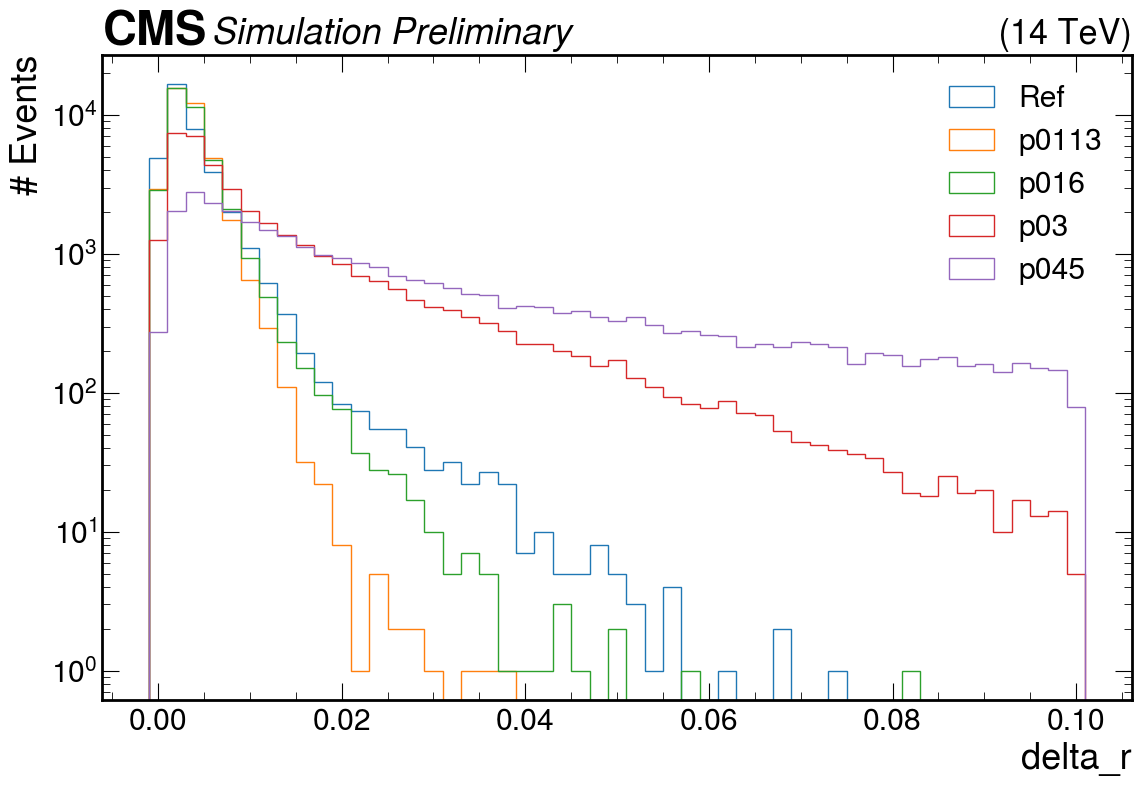

In [104]:
plot_across_five_lists(
    photon_df_Ref_filtered, photon_df_p0113_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered,
    ["delta_r"], ["delta_r"], ["delta_r"], ["delta_r"], ["delta_r"],   # full column names per DF
    label_ref="Ref", label_p0113="p0113", label_p016="p016", label_p03="p03", label_p045="p045",
    plots_dir="plot_triangles",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=50, cl3d_pt_range=(20, 500),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [60]:
def pick_first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns exist: {candidates}")

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def plot_deltaR_quantiles_vs_genpt(
    df, genpt_col, dr_col="delta_r",
    pt_bins=None, out="deltaR_quantiles_vs_genpt.png",
    cms_label=True, title=None
):
    if pt_bins is None:
        pt_bins = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

    d = df[[genpt_col, dr_col]].dropna()
    d = d[np.isfinite(d[genpt_col]) & np.isfinite(d[dr_col])]
    d["ptbin"] = pd.cut(d[genpt_col], bins=pt_bins, include_lowest=True, right=False)

    qlist = [0.50, 0.68, 0.95]
    centers = []
    qs = {q: [] for q in qlist}
    counts = []

    for b, g in d.groupby("ptbin", observed=True):
        if len(g) == 0:
            continue
        lo = b.left
        hi = b.right
        centers.append(0.5*(lo+hi))
        counts.append(len(g))
        for q in qlist:
            qs[q].append(np.quantile(g[dr_col].to_numpy(), q))

    if len(centers) == 0:
        print("[plot_deltaR_quantiles_vs_genpt] no data")
        return

    plt.figure(figsize=(12,8))
    plt.plot(centers, qs[0.50], marker="o", label="median")
    plt.plot(centers, qs[0.68], marker="o", label="68% quantile")
    plt.plot(centers, qs[0.95], marker="o", label="95% quantile")
    plt.xlabel(r"$p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\Delta R(\mathrm{reco},\,gen)$ quantiles")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()

    if cms_label:
        mh.cms.label("Preliminary", data=False, com=14)

    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    print("Saved:", out)

def plot_deltaR_slices(
    df, genpt_col, dr_col="delta_r",
    slices=((20,40),(40,60),(60,80),(80,100)),
    bins=np.linspace(0,0.6,121),
    out="deltaR_slices.png",
    logy=True,
    cms_label=True,
    title=None,
):
    plt.figure(figsize=(12,8))
    for (lo,hi) in slices:
        m = (df[genpt_col] >= lo) & (df[genpt_col] < hi)
        vals = df.loc[m, dr_col].dropna().to_numpy()
        vals = vals[np.isfinite(vals)]
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=bins, histtype="step", label=f"{lo}–{hi} GeV (N={len(vals)})")
    plt.xlabel(r"$\Delta R(\mathrm{reco},\,gen)$")
    plt.ylabel("# clusters")
    if logy:
        plt.yscale("log")
    if title: plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if cms_label:
        mh.cms.label("Preliminary", data=False, com=14)
    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    print("Saved:", out)

def plot_eff_vs_genpt_eta_slices(
    df, genpt_col, geneta_col, dr_col="delta_r",
    dr_cut=0.1,
    eta_bins=((1.6,2.0),(2.0,2.4),(2.4,2.8)),
    pt_bins=None,
    out="eff_vs_genpt_eta_slices.png",
    cms_label=True,
    title=None,
):
    if pt_bins is None:
        pt_bins = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

    plt.figure(figsize=(12,8))

    for (elo,ehi) in eta_bins:
        m_eta = (np.abs(df[geneta_col]) >= elo) & (np.abs(df[geneta_col]) < ehi)
        dd = df.loc[m_eta, [genpt_col, dr_col]].dropna()
        dd = dd[np.isfinite(dd[genpt_col]) & np.isfinite(dd[dr_col])]
        if len(dd) == 0:
            continue

        eff = []
        cen = []
        err = []
        for i in range(len(pt_bins)-1):
            lo,hi = pt_bins[i], pt_bins[i+1]
            mpt = (dd[genpt_col] >= lo) & (dd[genpt_col] < hi)
            n = int(mpt.sum())
            if n == 0:
                eff.append(np.nan); err.append(np.nan); cen.append(0.5*(lo+hi))
                continue
            k = int((dd.loc[mpt, dr_col] < dr_cut).sum())
            p = k / n
            # binomial approx error
            s = np.sqrt(p*(1-p)/n) if n>0 else np.nan
            eff.append(p); err.append(s); cen.append(0.5*(lo+hi))

        plt.errorbar(cen, eff, yerr=err, marker="o", linestyle="-", label=f"{elo}–{ehi}")
    plt.ylim(0,0.05)
    plt.xlabel(r"$p_T^{gen}$ [GeV]")
    plt.ylabel(rf"$\epsilon(\Delta R<{dr_cut})$")
    plt.ylim(0, 0.05)
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(title=r"$|\eta^{gen}|$ slice", frameon=False)

    if cms_label:
        mh.cms.label("Preliminary", data=False, com=14)

    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    print("Saved:", out)

def plot_response_vs_genpt(
    df, genpt_col, recopt_col,
    pt_bins=None,
    out="response_vs_genpt.png",
    cms_label=True,
    title=None
):
    if pt_bins is None:
        pt_bins = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

    d = df[[genpt_col, recopt_col]].dropna()
    d = d[np.isfinite(d[genpt_col]) & np.isfinite(d[recopt_col])]
    resp = d[recopt_col].to_numpy() / d[genpt_col].to_numpy()
    d = d.assign(resp=resp)
    d["ptbin"] = pd.cut(d[genpt_col], bins=pt_bins, include_lowest=True, right=False)

    centers, med, q16, q84, counts = [], [], [], [], []
    for b, g in d.groupby("ptbin", observed=True):
        if len(g) == 0:
            continue
        lo,hi = b.left, b.right
        centers.append(0.5*(lo+hi))
        counts.append(len(g))
        arr = g["resp"].to_numpy()
        med.append(np.quantile(arr, 0.50))
        q16.append(np.quantile(arr, 0.16))
        q84.append(np.quantile(arr, 0.84))

    plt.figure(figsize=(12,8))
    plt.plot(centers, med, marker="o", label="median")
    plt.fill_between(centers, q16, q84, alpha=0.2, label="16–84%")
    plt.xlabel(r"$p_T^{gen}$ [GeV]")
    plt.ylabel(r"$p_T^{reco}/p_T^{gen}$")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(frameon=False)

    if cms_label:
        mh.cms.label("Preliminary", data=False, com=14)

    plt.tight_layout()
    plt.savefig(out, bbox_inches="tight")
    plt.close()
    print("Saved:", out)

def dump_counts_per_ptbin(df, genpt_col, pt_bins):
    d = df[[genpt_col]].dropna()
    d = d[np.isfinite(d[genpt_col])]
    bins = pd.cut(d[genpt_col], bins=pt_bins, include_lowest=True, right=False)
    counts = bins.value_counts().sort_index()
    print("\nCounts per gen pT bin:")
    for b, n in counts.items():
        print(f"  [{b.left:>5.1f},{b.right:>5.1f}) : {int(n)}")
    print()

def investigate_high_pt(
    df, tag, outdir,
    genpt_col, geneta_col,
    recopt_col,
    dr_col="delta_r",
    pt_bins=None,
    dr_cut_for_eff=0.1
):
    ensure_dir(outdir)
    if pt_bins is None:
        pt_bins = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

    # 1) deltaR quantiles vs gen pT
    plot_deltaR_quantiles_vs_genpt(
        df, genpt_col=genpt_col, dr_col=dr_col, pt_bins=pt_bins,
        out=os.path.join(outdir, f"{tag}_deltaR_quantiles_vs_genpt.png"),
        title=tag
    )

    # 2) deltaR shape in pT slices (look for right-shift/tails at high pT)
    plot_deltaR_slices(
        df, genpt_col=genpt_col, dr_col=dr_col,
        slices=((20,40),(40,60),(60,80),(80,120)),
        out=os.path.join(outdir, f"{tag}_deltaR_slices.png"),
        title=tag
    )

    # 3) efficiency vs gen pT in eta slices
    plot_eff_vs_genpt_eta_slices(
        df, genpt_col=genpt_col, geneta_col=geneta_col, dr_col=dr_col,
        dr_cut=dr_cut_for_eff, pt_bins=pt_bins,
        out=os.path.join(outdir, f"{tag}_eff_vs_genpt_etaSlices_dr{dr_cut_for_eff}.png"),
        title=f"{tag}  (cut: ΔR<{dr_cut_for_eff})"
    )

    # 4) response vs gen pT
    plot_response_vs_genpt(
        df, genpt_col=genpt_col, recopt_col=recopt_col, pt_bins=pt_bins,
        out=os.path.join(outdir, f"{tag}_response_vs_genpt.png"),
        title=tag
    )

    # 5) print stats per bin (so you can see if high-pT bins are low-stat)
    dump_counts_per_ptbin(df, genpt_col, pt_bins)


outdir = "highPt_investigation"

# Try to auto-detect your gen pt column name (edit candidates if needed)
genpt_candidates = ["gen_pt", "genpart_pt", "genpart_expt", "genpart_genpt", "gen_pt_GeV"]
geneta_candidates = [ "genpart_eta", "gen_eta", "genpart_exeta", "gen_eta_GeV"]

genpt_col_Ref   = pick_first_existing(photon_df_Ref,   genpt_candidates)
geneta_col_Ref  = pick_first_existing(photon_df_Ref,  geneta_candidates)

# For the other DFs, gen columns should exist too
genpt_col_p0113  = pick_first_existing(photon_df_p0113, genpt_candidates)
geneta_col_p0113 = pick_first_existing(photon_df_p0113, geneta_candidates)

genpt_col_p016  = pick_first_existing(photon_df_p016, genpt_candidates)
geneta_col_p016 = pick_first_existing(photon_df_p016, geneta_candidates)

genpt_col_p03   = pick_first_existing(photon_df_p03, genpt_candidates)
geneta_col_p03  = pick_first_existing(photon_df_p03, geneta_candidates)

genpt_col_p045  = pick_first_existing(photon_df_p045, genpt_candidates)
geneta_col_p045 = pick_first_existing(photon_df_p045, geneta_candidates)

# reco pt columns you already know:
recopt_ref   = "cl3d_Ref_pt"
recopt_p0113 = "cl3d_p0113Tri_pt"
recopt_p016  = "cl3d_p016Tri_pt"
recopt_p03   = "cl3d_p03Tri_pt"
recopt_p045  = "cl3d_p045Tri_pt"

pt_bins = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

investigate_high_pt(photon_df_Ref_filtered,   "Ref",   outdir, genpt_col_Ref,   geneta_col_Ref,   recopt_ref,   pt_bins=pt_bins, dr_cut_for_eff=0.1)
investigate_high_pt(photon_df_p0113_filtered, "p0113", outdir, genpt_col_p0113, geneta_col_p0113, recopt_p0113, pt_bins=pt_bins, dr_cut_for_eff=0.1)
investigate_high_pt(photon_df_p016_filtered,  "p016",  outdir, genpt_col_p016,  geneta_col_p016,  recopt_p016,  pt_bins=pt_bins, dr_cut_for_eff=0.1)
investigate_high_pt(photon_df_p03_filtered,   "p03",   outdir, genpt_col_p03,   geneta_col_p03,   recopt_p03,   pt_bins=pt_bins, dr_cut_for_eff=0.1)
investigate_high_pt(photon_df_p045_filtered,  "p045",  outdir, genpt_col_p045,  geneta_col_p045,  recopt_p045,  pt_bins=pt_bins, dr_cut_for_eff=0.1)

print(f"\nAll outputs written to: {outdir}/")


Saved: highPt_investigation/Ref_deltaR_quantiles_vs_genpt.png
Saved: highPt_investigation/Ref_deltaR_slices.png
Saved: highPt_investigation/Ref_eff_vs_genpt_etaSlices_dr0.1.png
Saved: highPt_investigation/Ref_response_vs_genpt.png

Counts per gen pT bin:
  [ 20.0, 25.0) : 2530
  [ 25.0, 30.0) : 2482
  [ 30.0, 35.0) : 2483
  [ 35.0, 40.0) : 2423
  [ 40.0, 45.0) : 2412
  [ 45.0, 50.0) : 2394
  [ 50.0, 55.0) : 2479
  [ 55.0, 60.0) : 2422
  [ 60.0, 65.0) : 2445
  [ 65.0, 70.0) : 2405
  [ 70.0, 75.0) : 2492
  [ 75.0, 80.0) : 2476
  [ 80.0, 85.0) : 2545
  [ 85.0, 90.0) : 2472
  [ 90.0, 95.0) : 2511
  [ 95.0,100.0) : 2400

Saved: highPt_investigation/p0113_deltaR_quantiles_vs_genpt.png
Saved: highPt_investigation/p0113_deltaR_slices.png
Saved: highPt_investigation/p0113_eff_vs_genpt_etaSlices_dr0.1.png
Saved: highPt_investigation/p0113_response_vs_genpt.png

Counts per gen pT bin:
  [ 20.0, 25.0) : 2528
  [ 25.0, 30.0) : 2480
  [ 30.0, 35.0) : 2478
  [ 35.0, 40.0) : 2420
  [ 40.0, 45.0) : 241

Saved: plot_triangles/pt_across_triangles.png


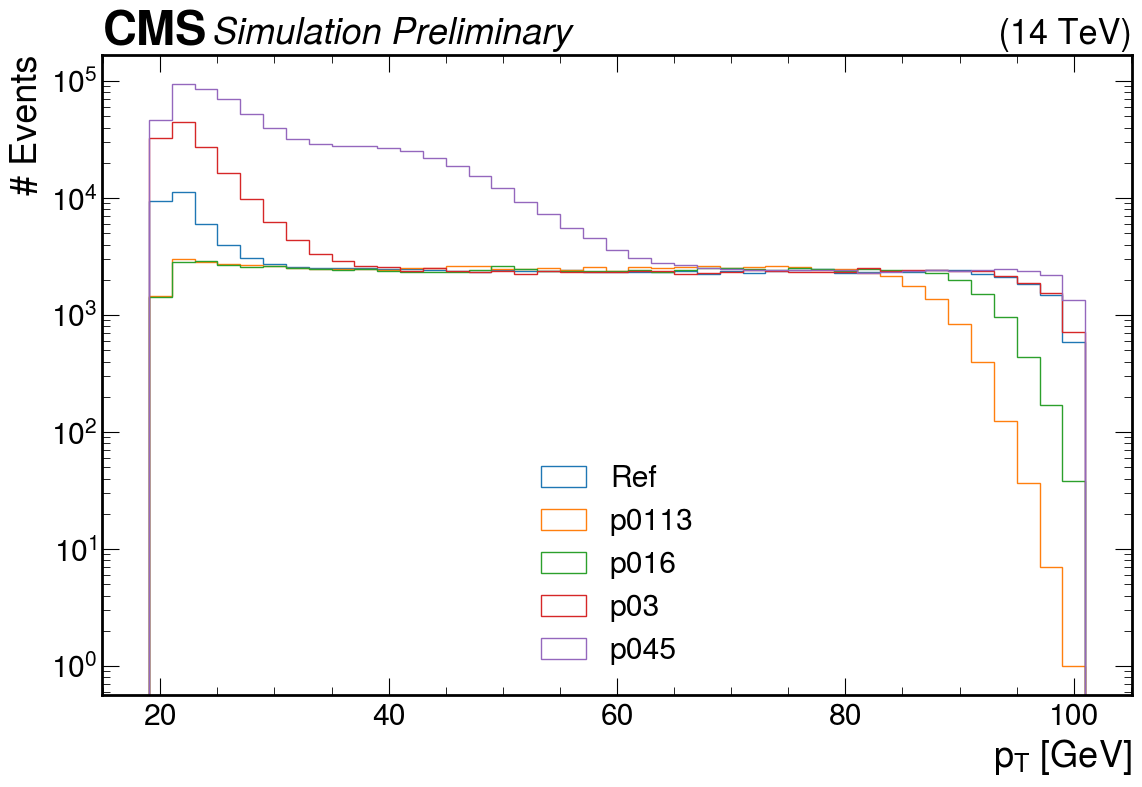

Saved: plot_triangles/energy_across_triangles.png


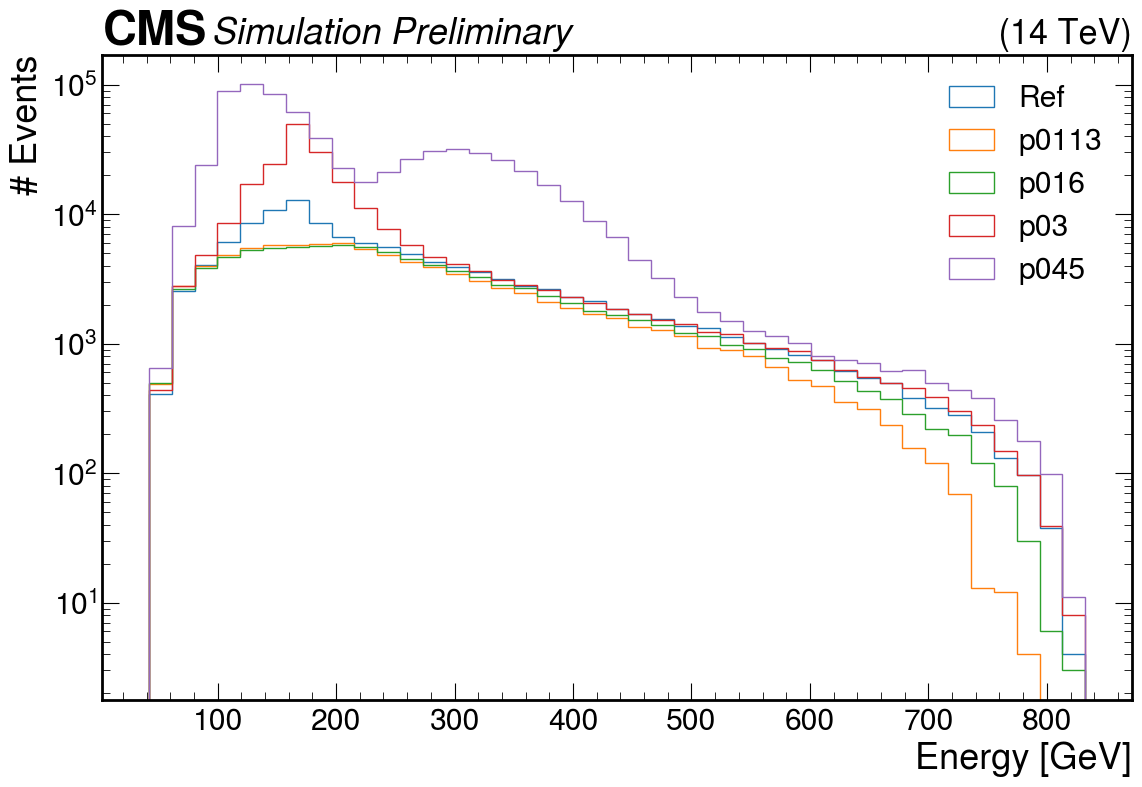

Saved: plot_triangles/eta_across_triangles.png


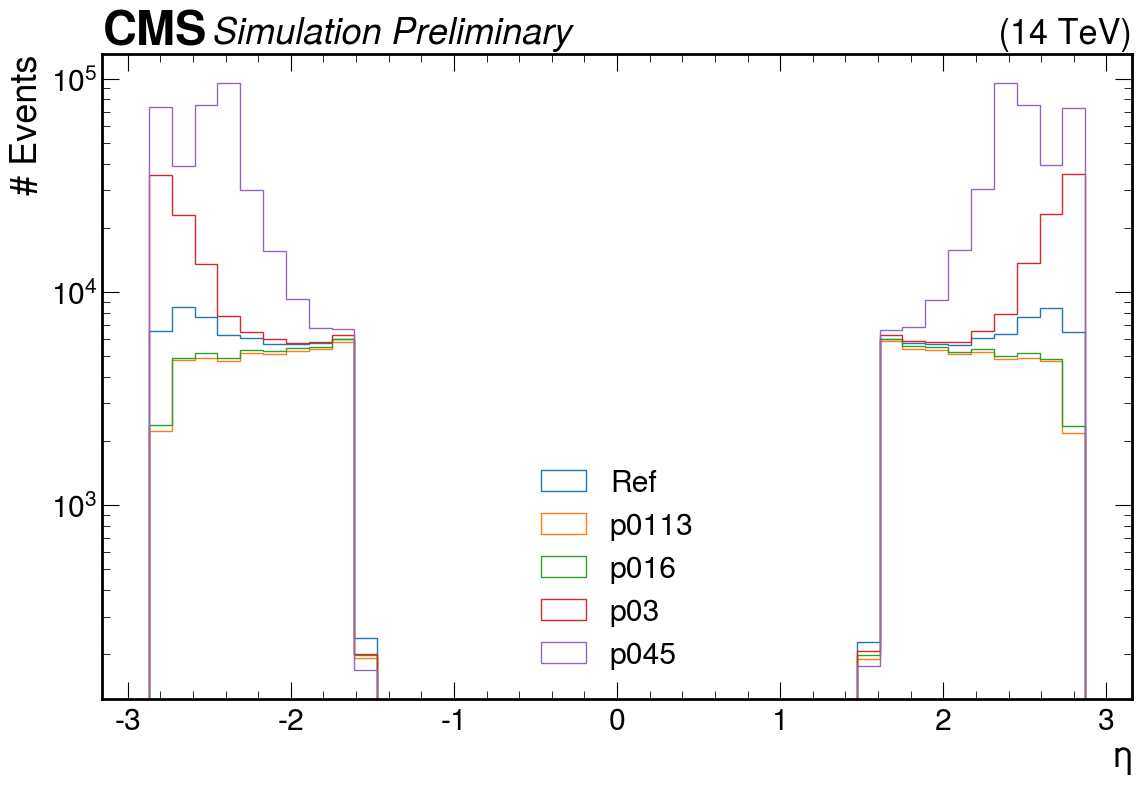

Saved: plot_triangles/phi_across_triangles.png


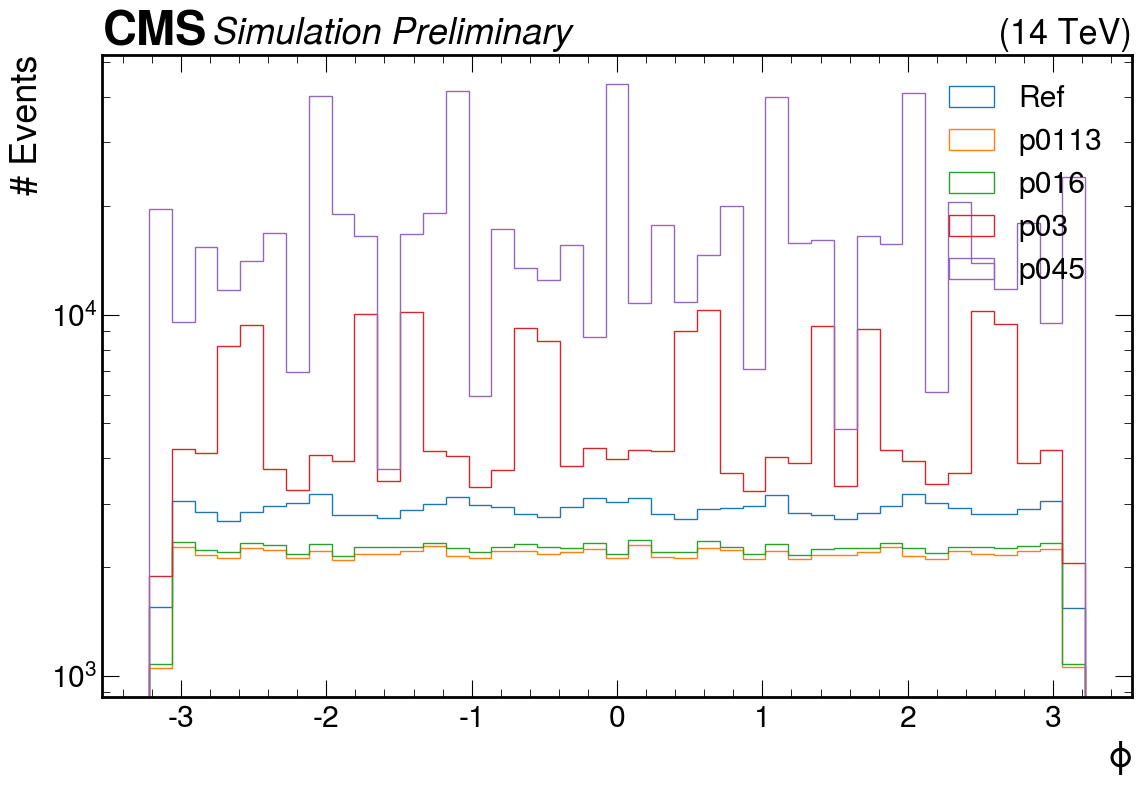

Saved: plot_triangles/emax1layers_across_triangles.png


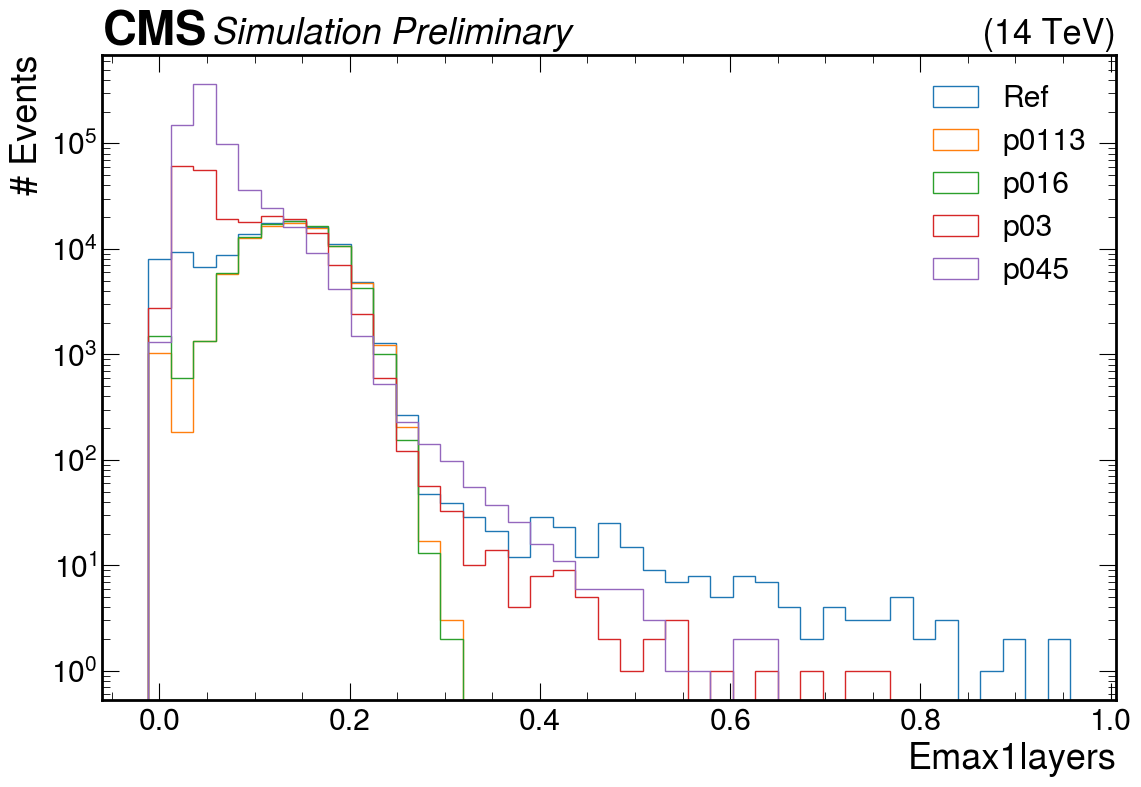

Saved: plot_triangles/emax3layers_across_triangles.png


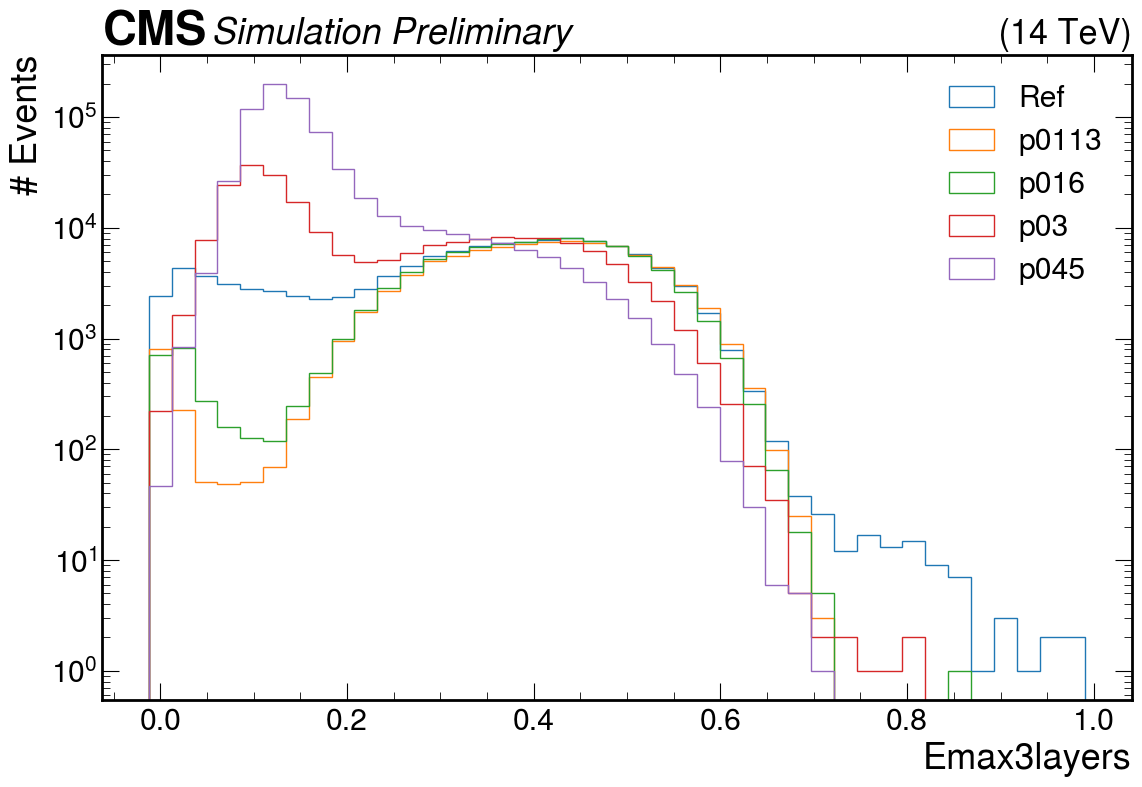

Saved: plot_triangles/showerlength_across_triangles.png


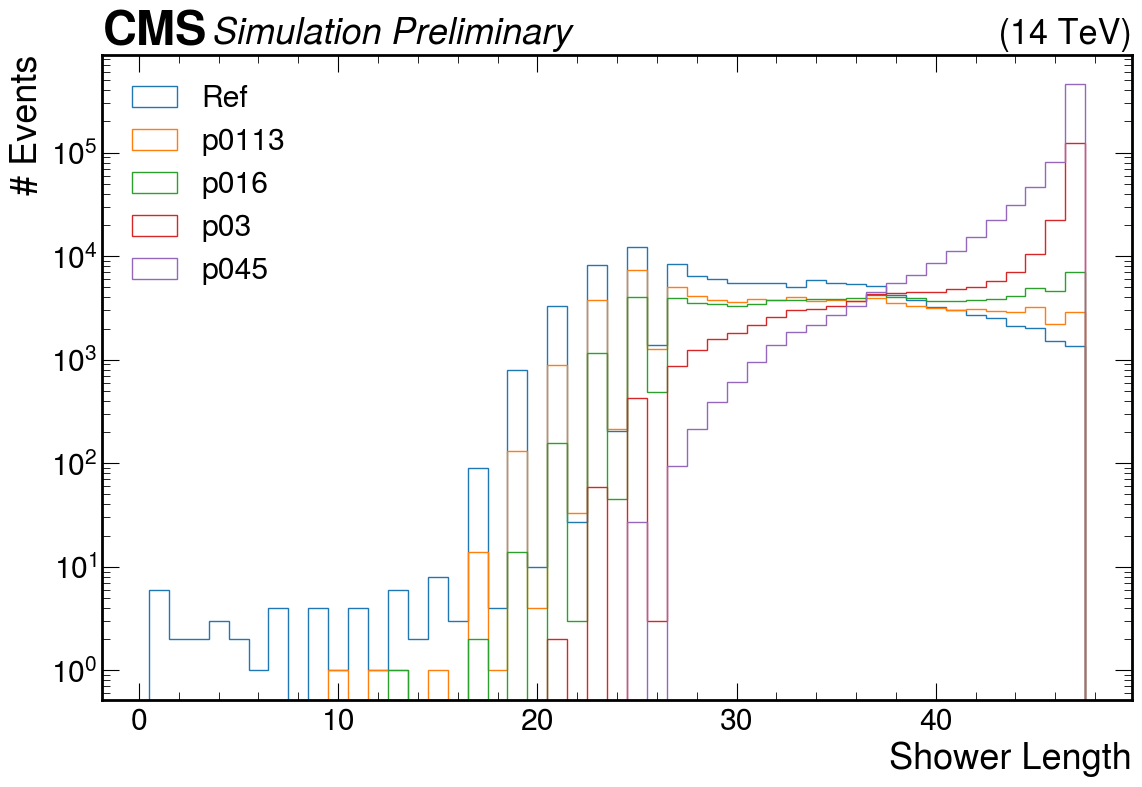

Saved: plot_triangles/coreshowerlength_across_triangles.png


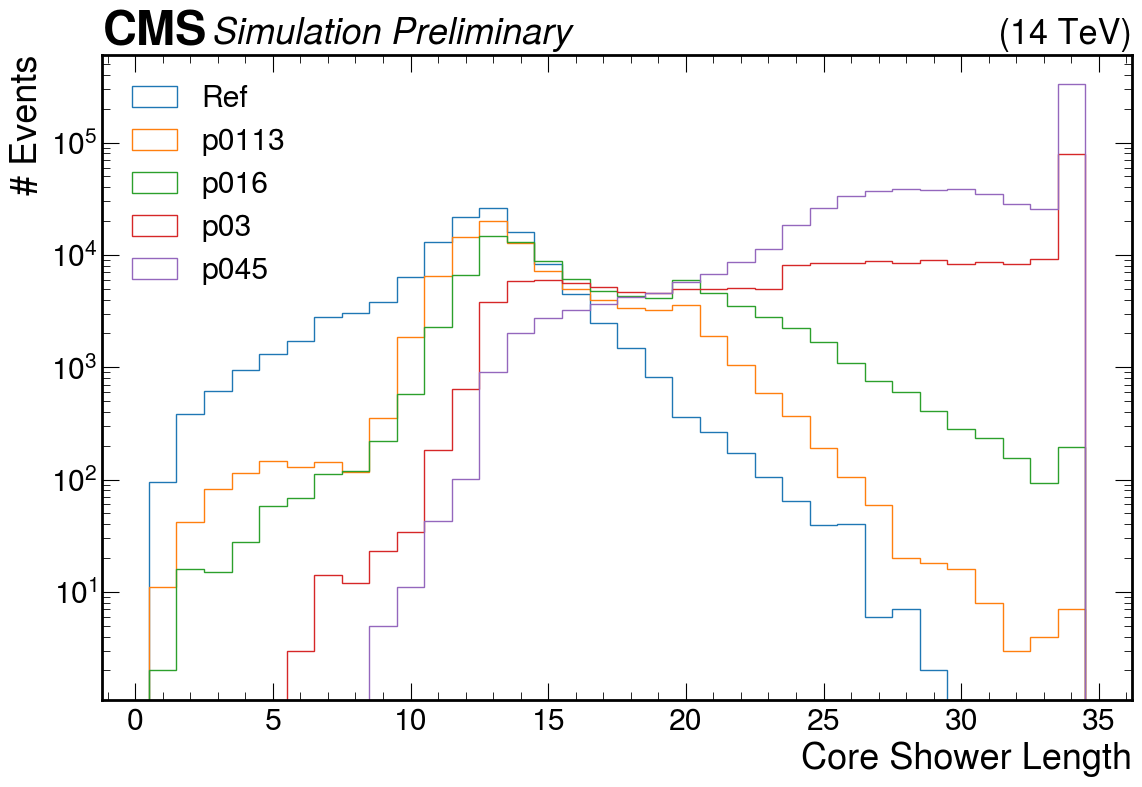

Saved: plot_triangles/firstlayer_across_triangles.png


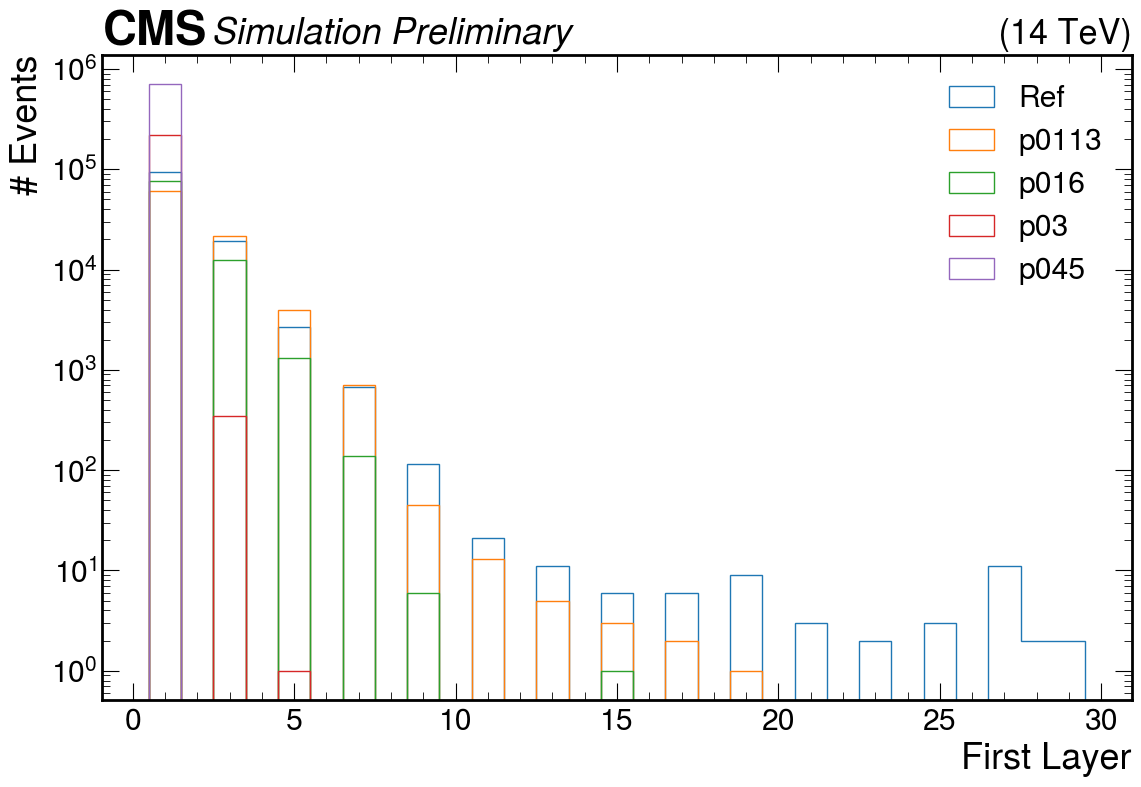

Saved: plot_triangles/maxlayer_across_triangles.png


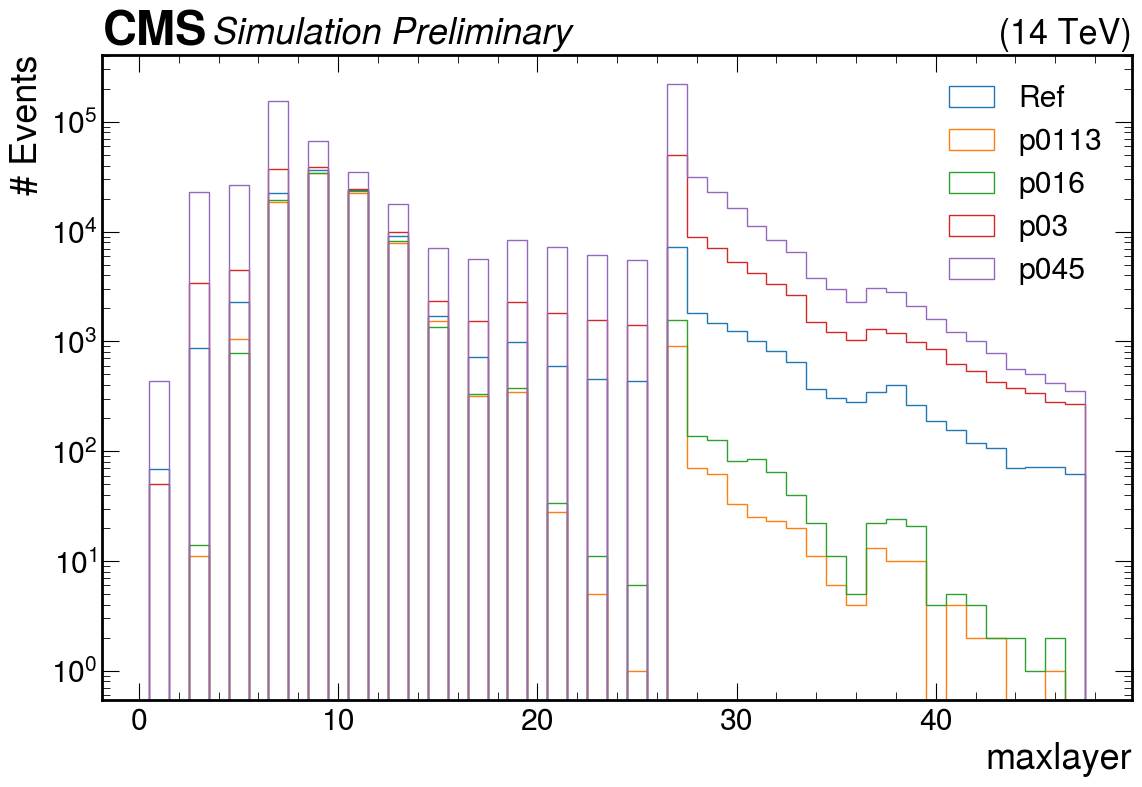

Saved: plot_triangles/varrr_across_triangles.png


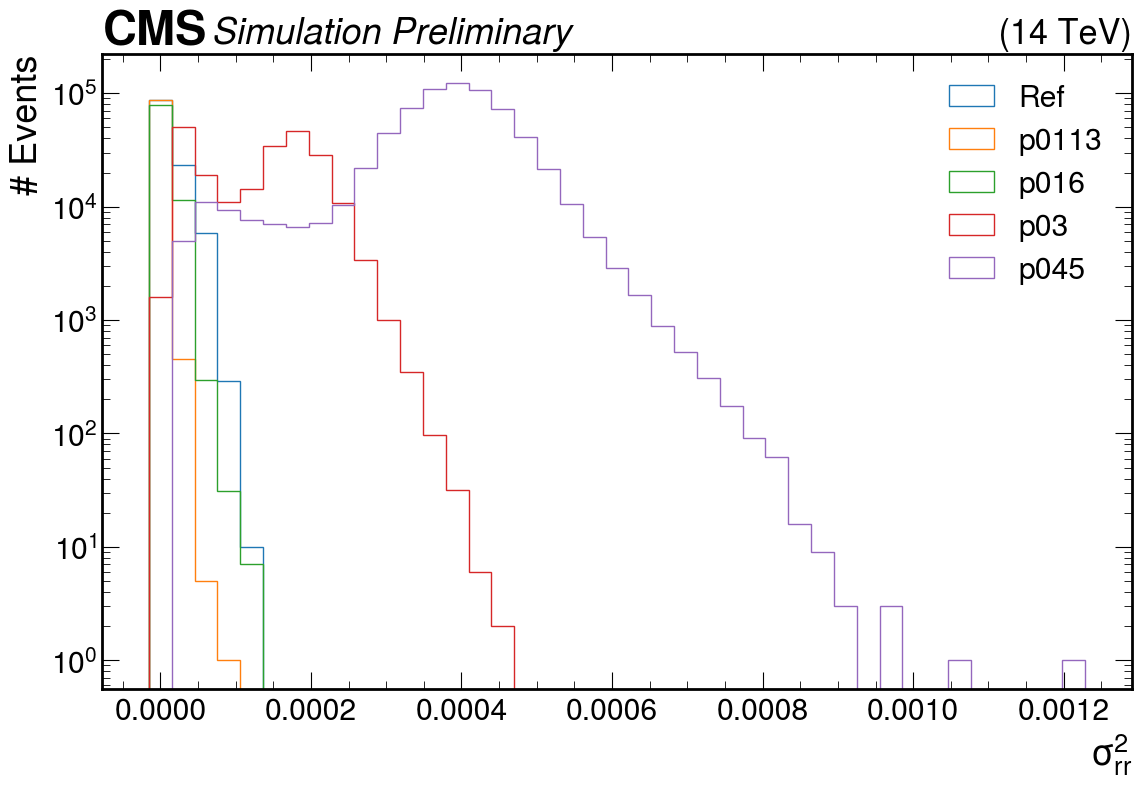

Saved: plot_triangles/varzz_across_triangles.png


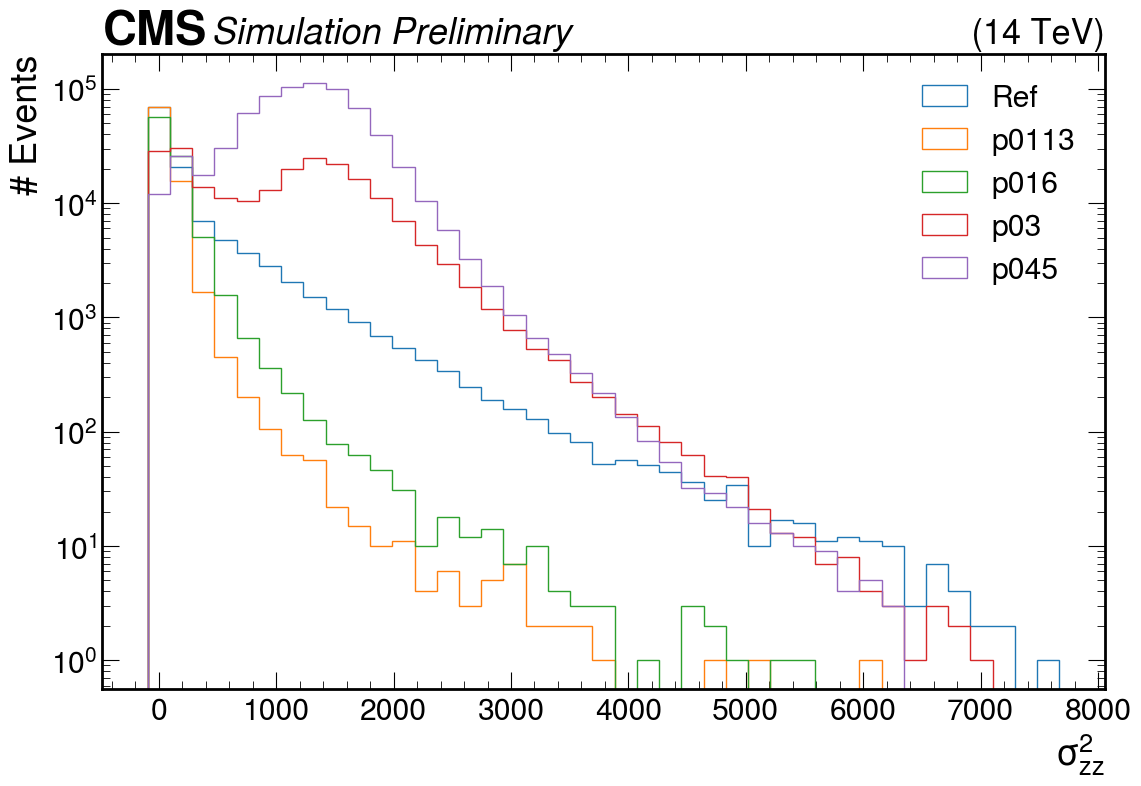

Saved: plot_triangles/varee_across_triangles.png


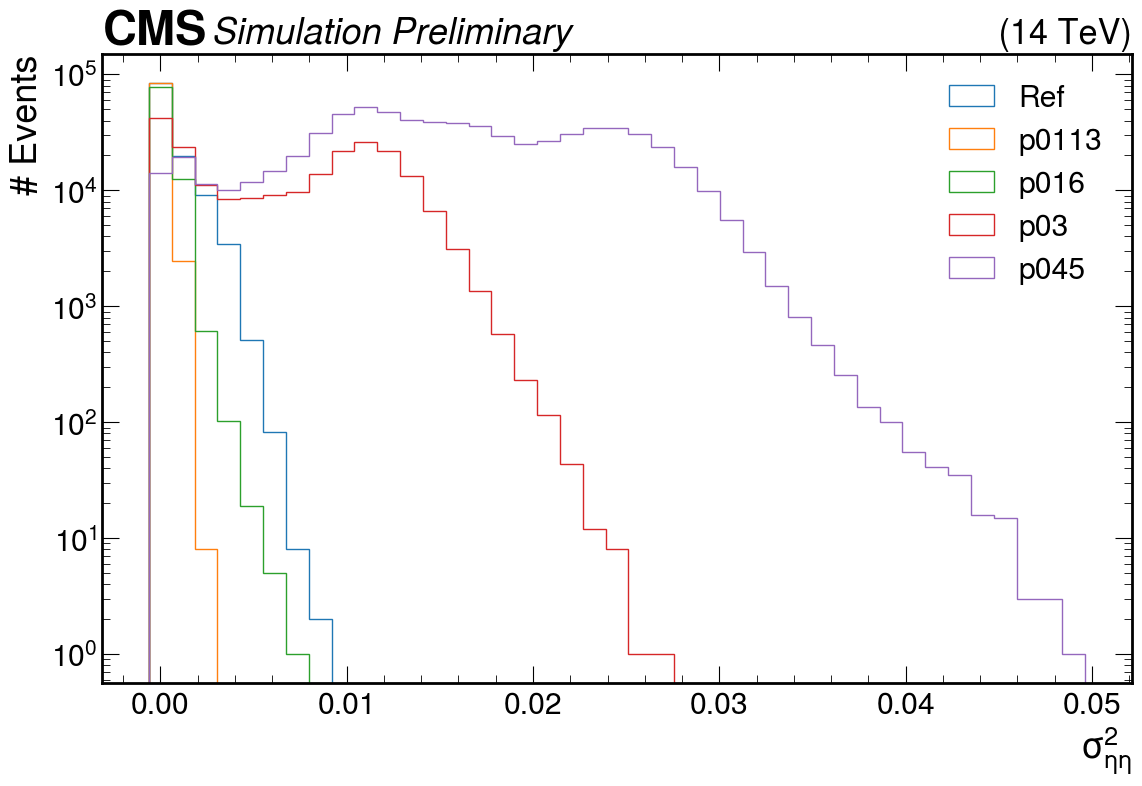

Saved: plot_triangles/varpp_across_triangles.png


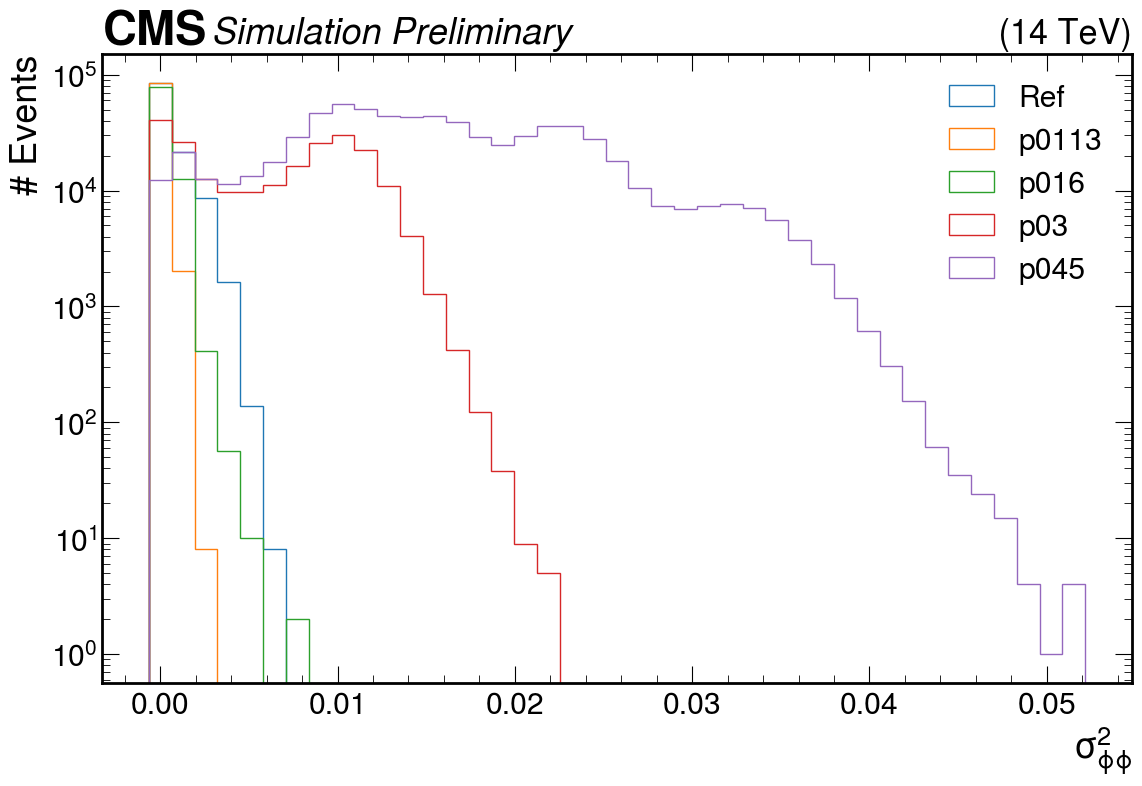

Saved: plot_triangles/emaxe_across_triangles.png


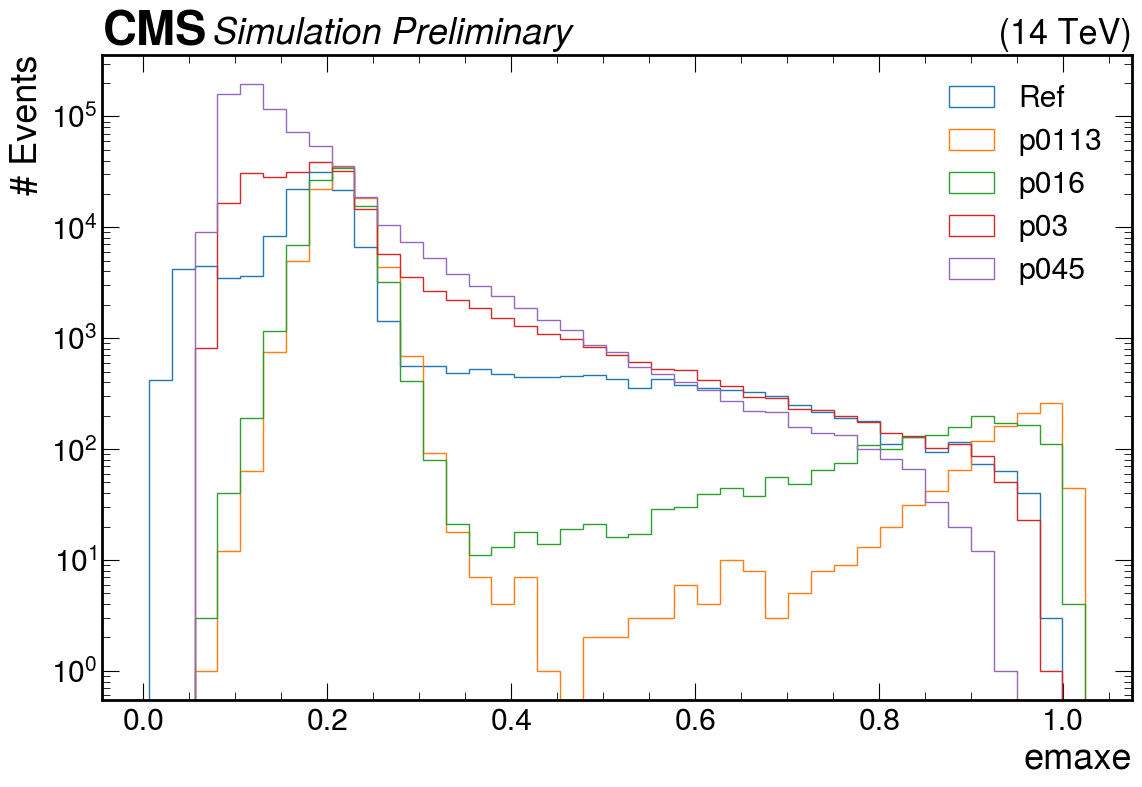

Saved: plot_triangles/hoe_across_triangles.png


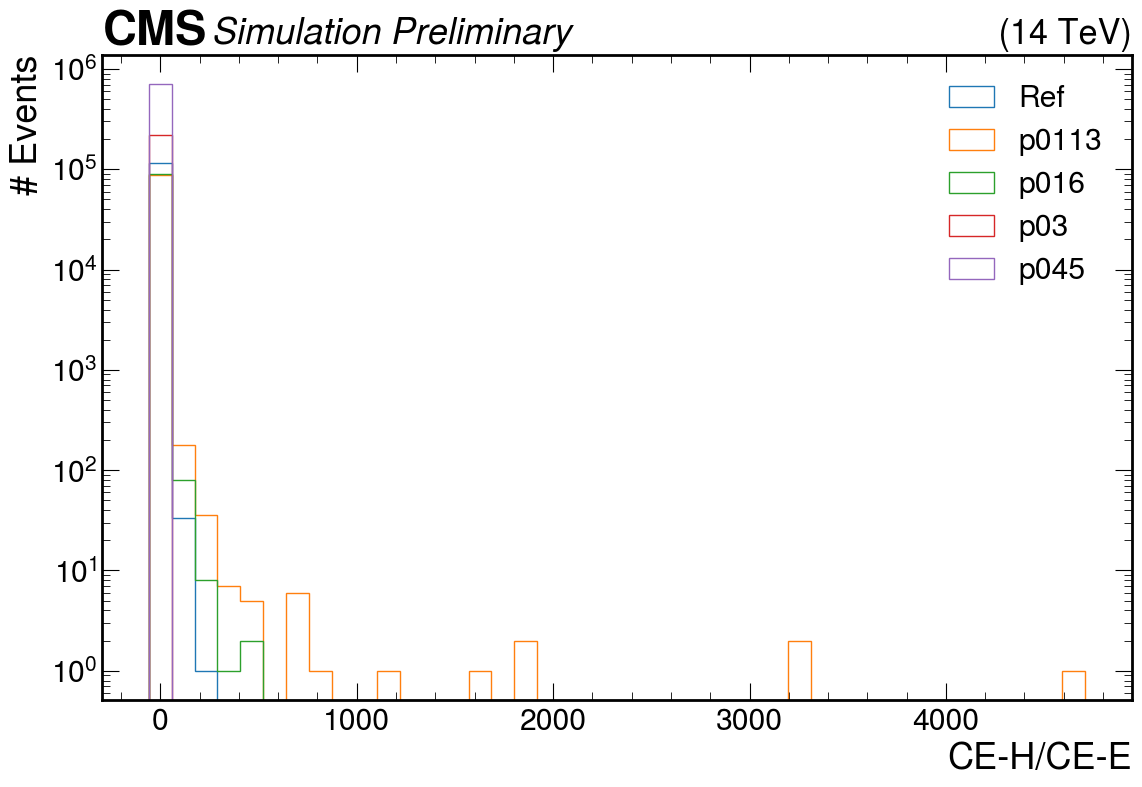

Saved: plot_triangles/meanz_across_triangles.png


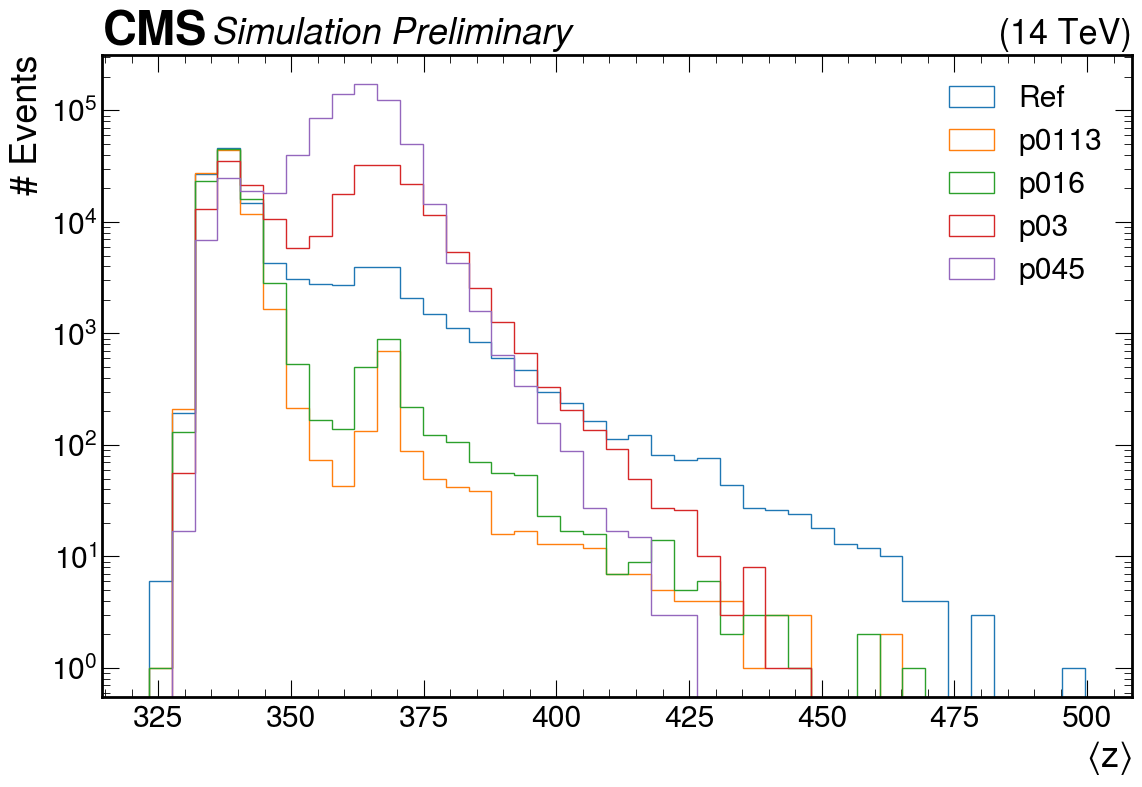

Saved: plot_triangles/first1layers_across_triangles.png


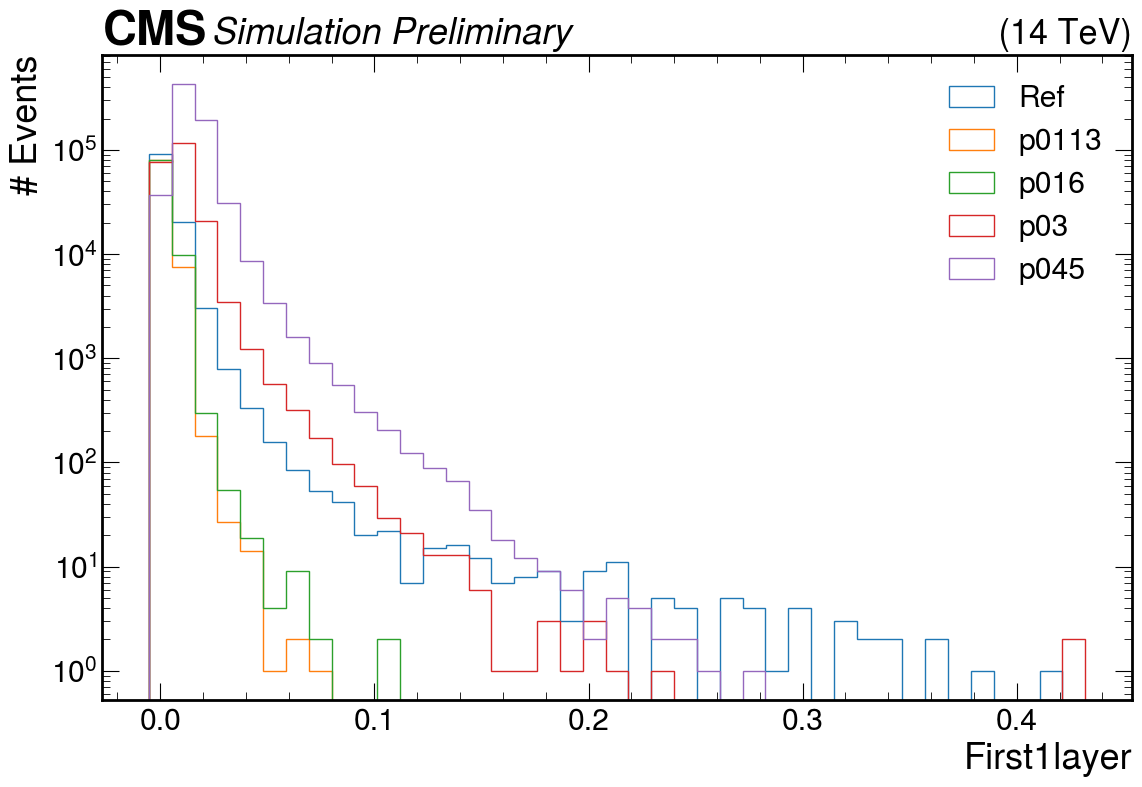

Saved: plot_triangles/first3layers_across_triangles.png


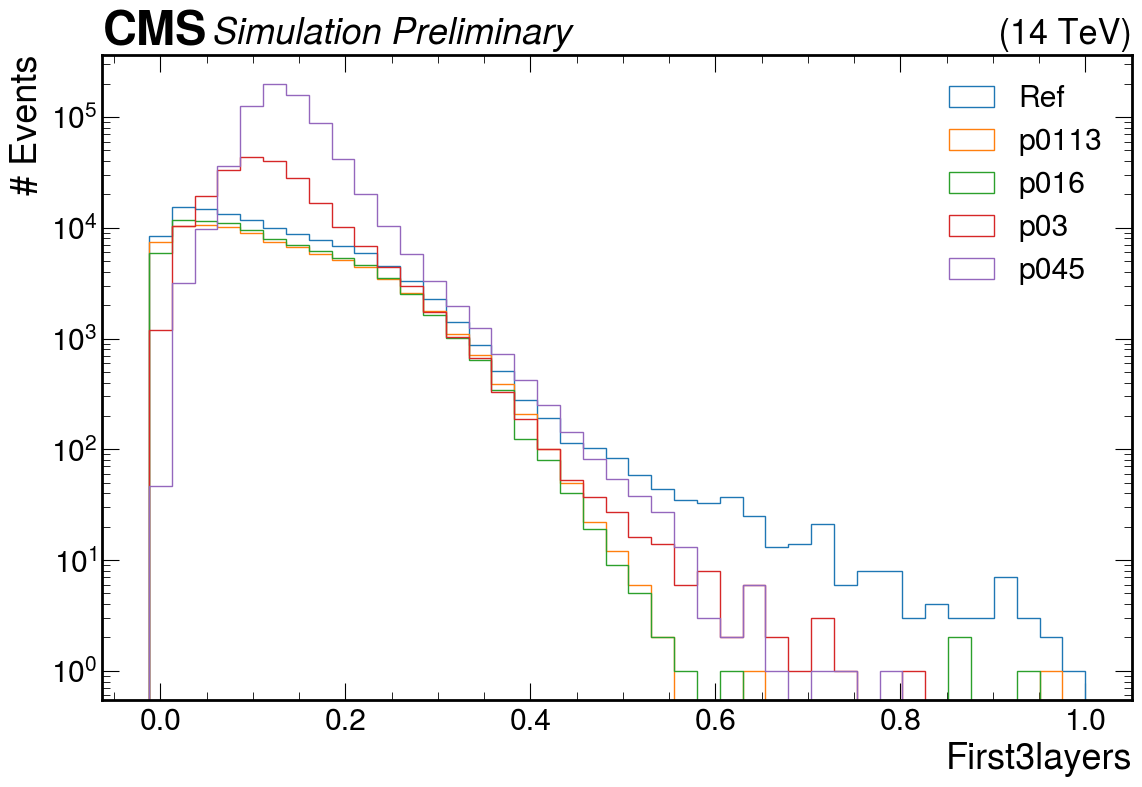

Saved: plot_triangles/first5layers_across_triangles.png


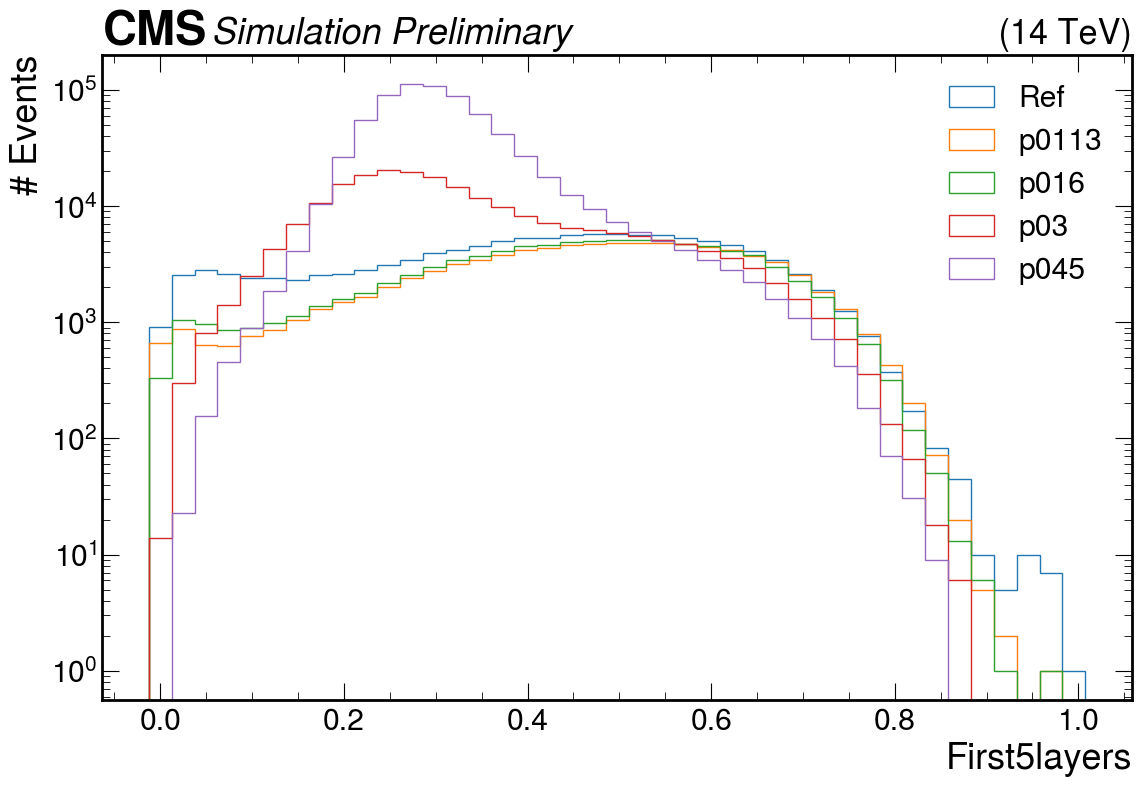

Saved: plot_triangles/firstHcal1layers_across_triangles.png


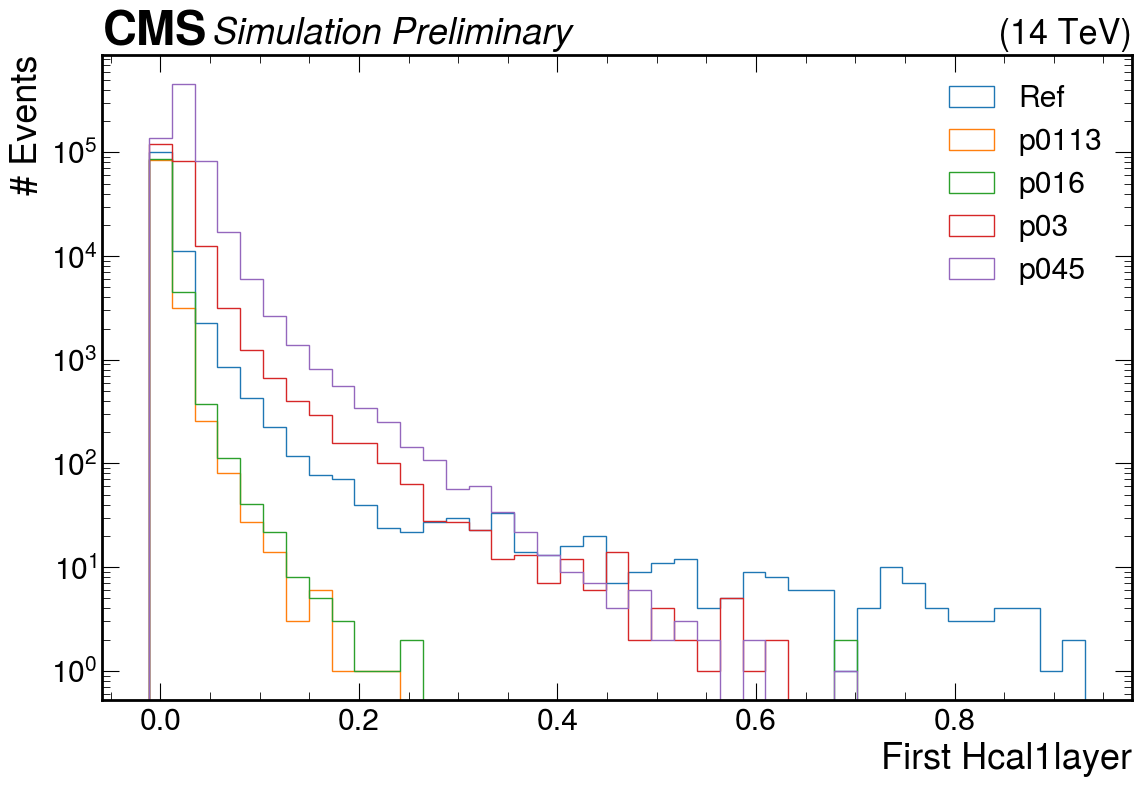

Saved: plot_triangles/firstHcal3layers_across_triangles.png


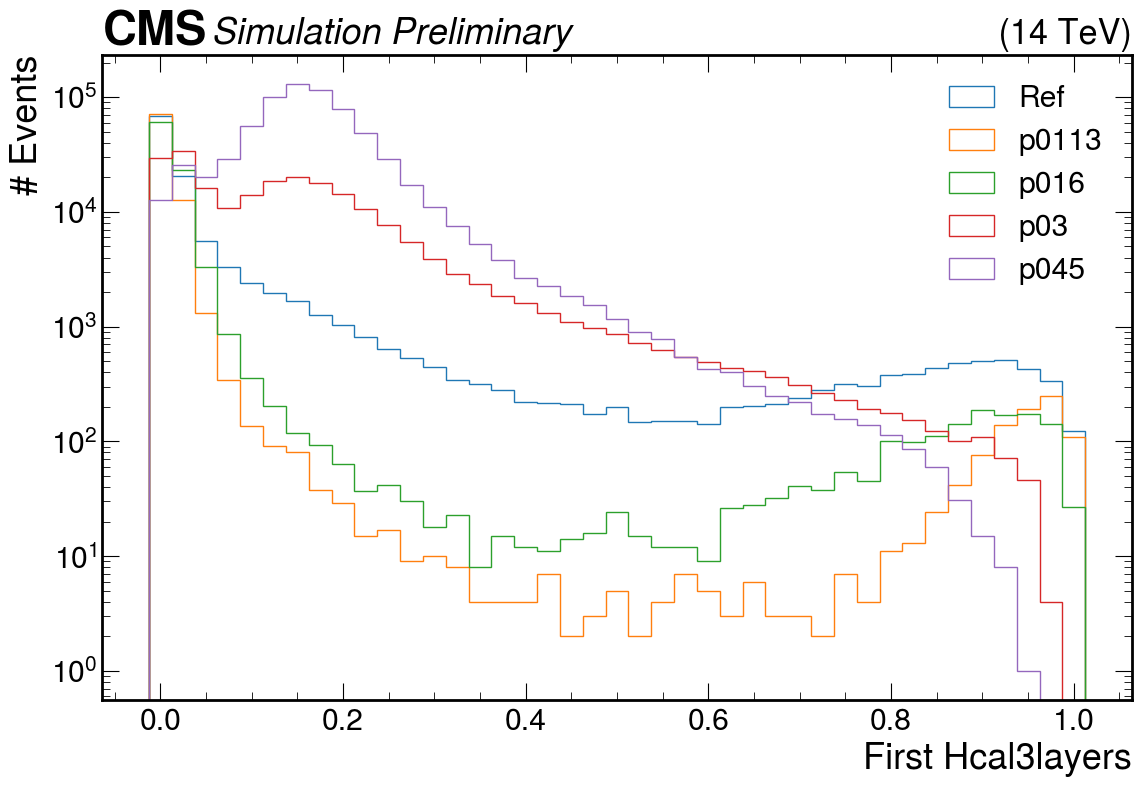

Saved: plot_triangles/firstHcal5layers_across_triangles.png


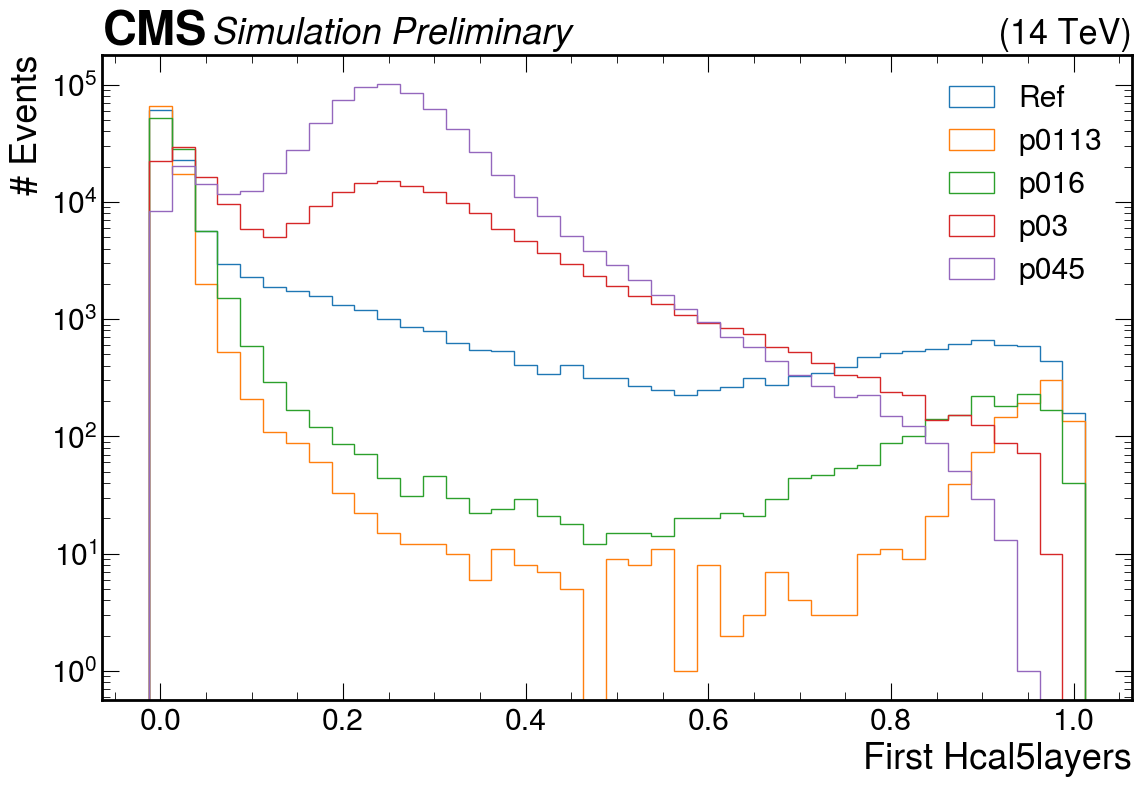

Saved: plot_triangles/last1layers_across_triangles.png


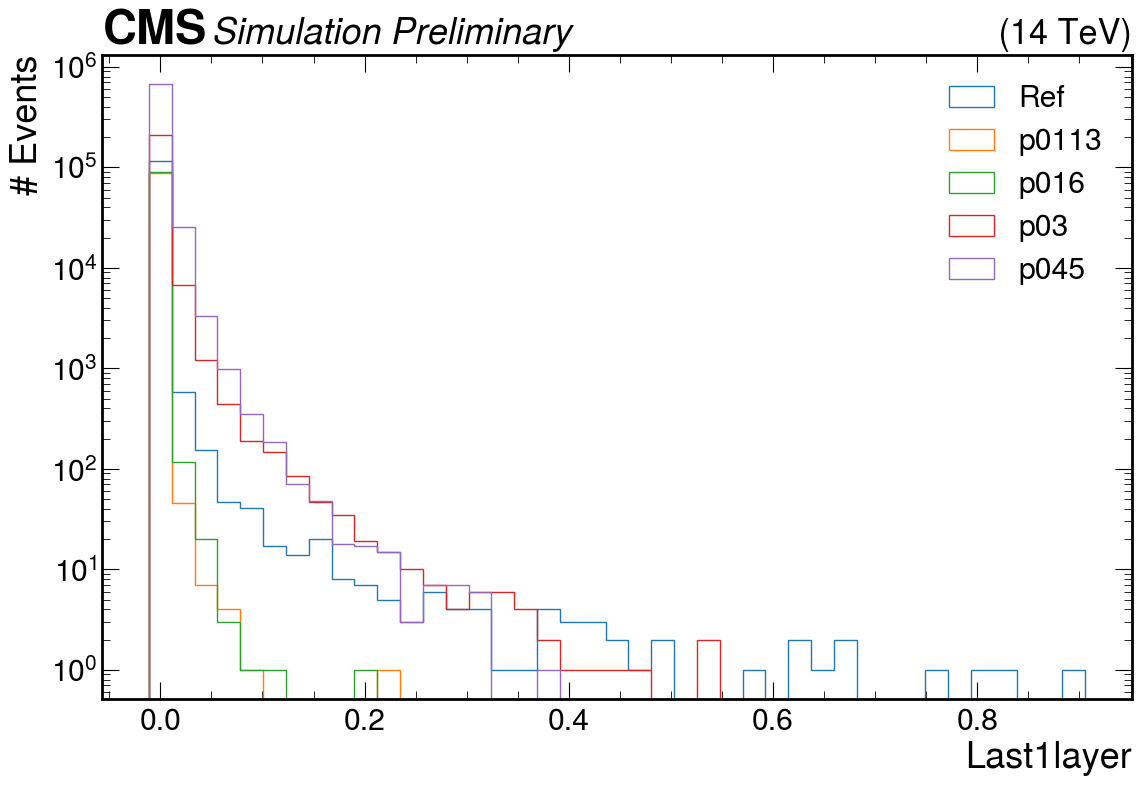

Saved: plot_triangles/last3layers_across_triangles.png


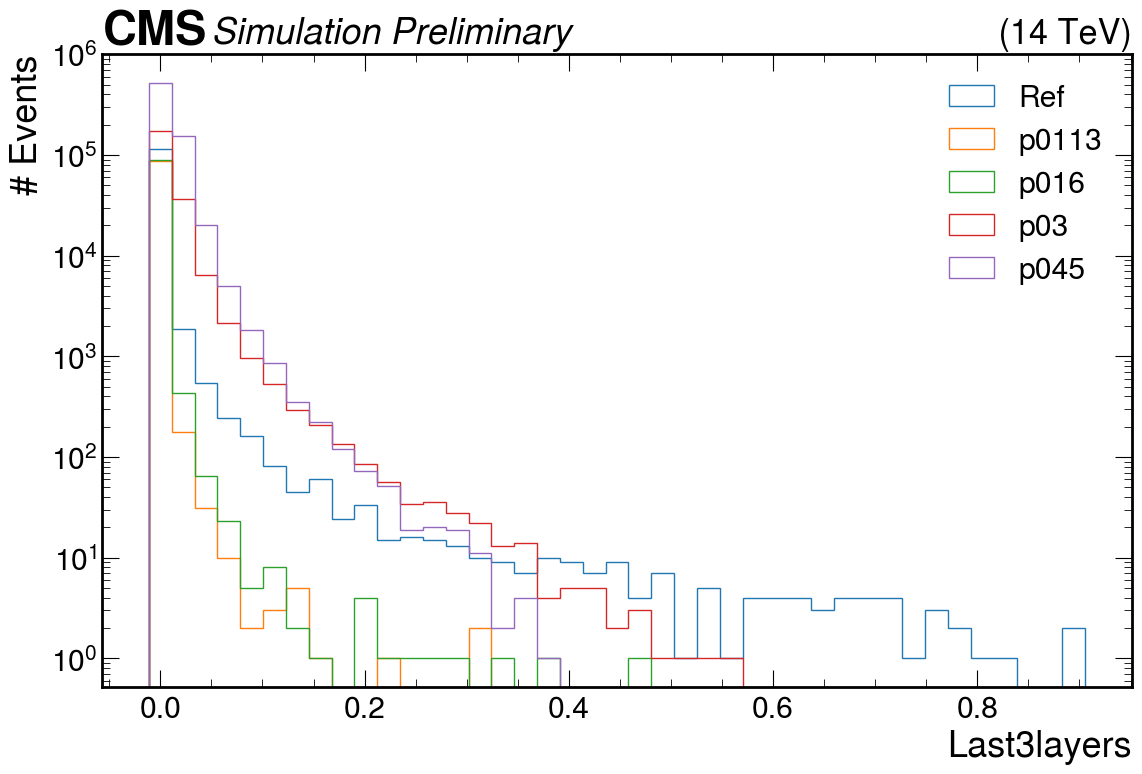

Saved: plot_triangles/last5layers_across_triangles.png


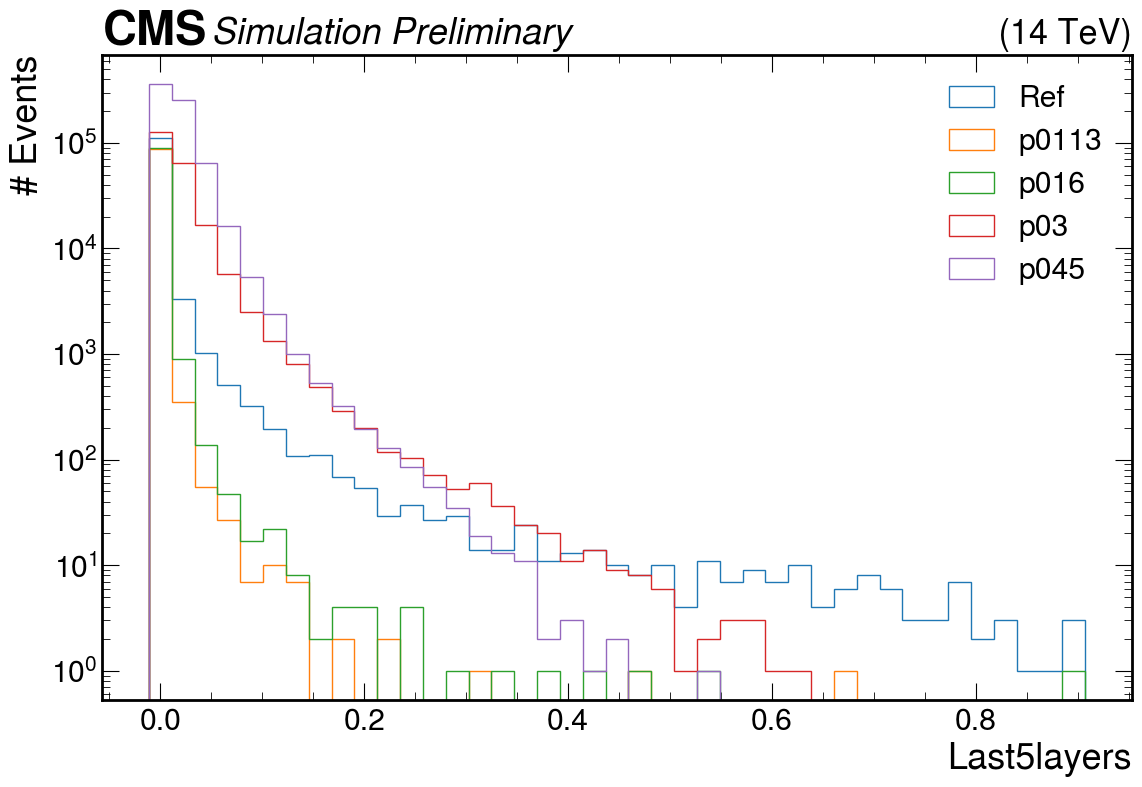

Saved: plot_triangles/eot_across_triangles.png


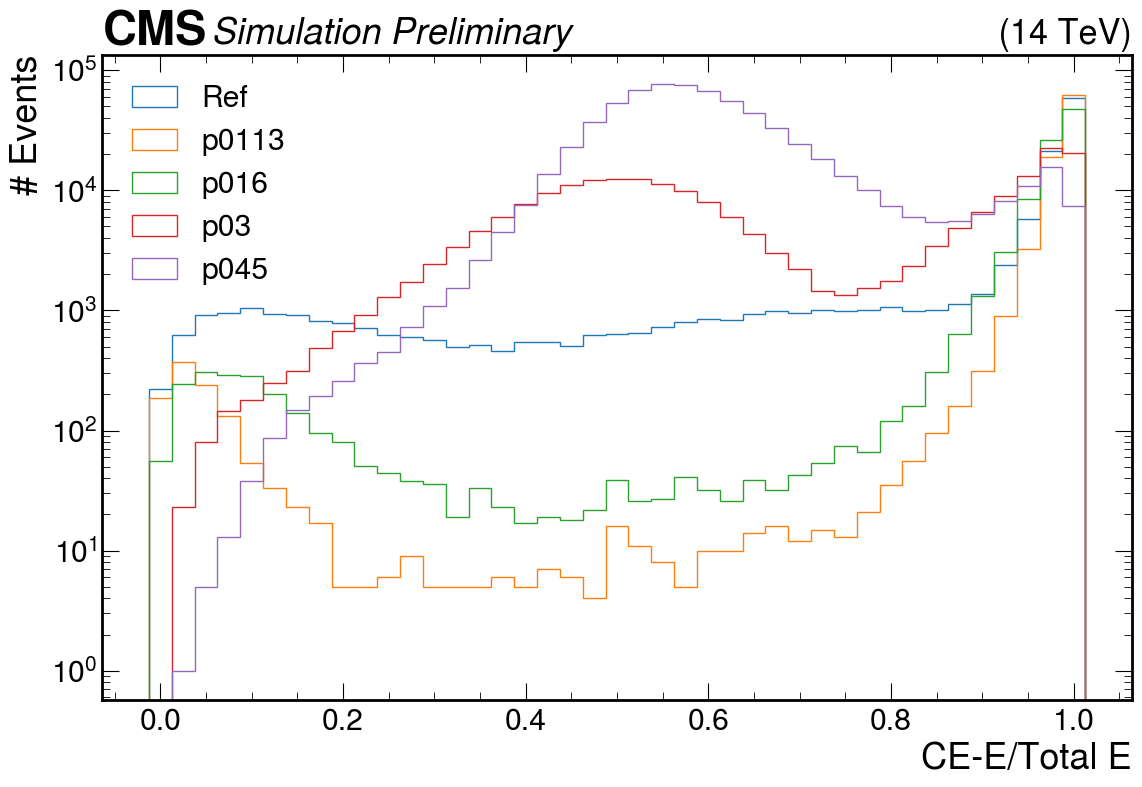

Saved: plot_triangles/ebm0_across_triangles.png


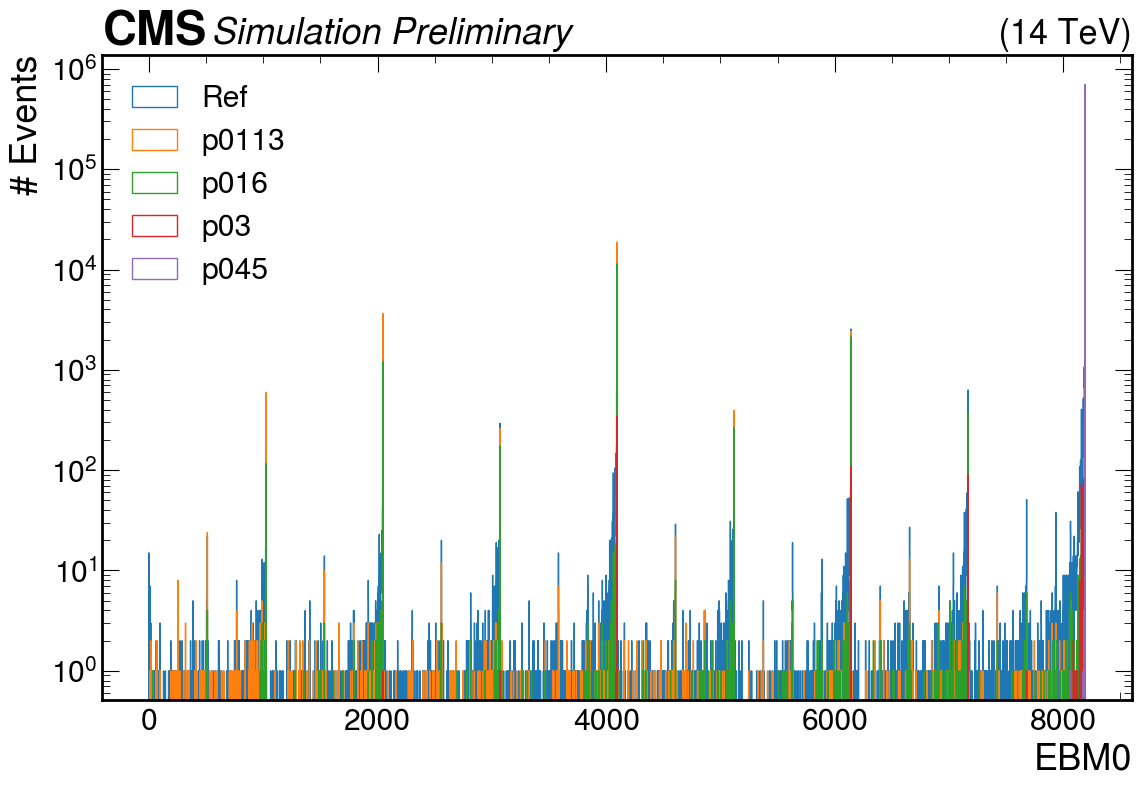

Saved: plot_triangles/ebm1_across_triangles.png


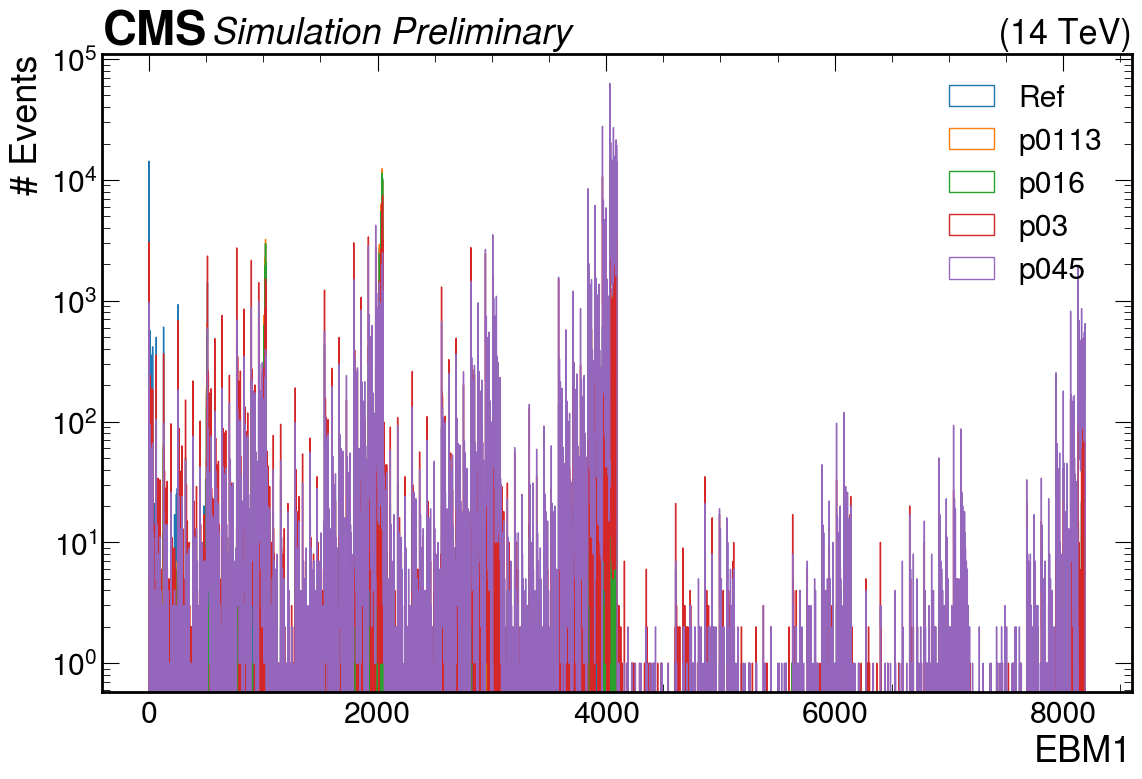

In [ ]:
plot_across_five_lists(
    photon_df_Ref, photon_df_p0113, photon_df_p016, photon_df_p03, photon_df_p045,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p0113Tri'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p0113="p0113", label_p016="p016", label_p03="p03", label_p045="p045",
    plots_dir="plot_triangles",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 100),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [16]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.5)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.5)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.5)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.5)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.5)

In [17]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.15)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.15)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.15)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.15)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.15)

In [19]:

# p0113
photon_df_p0113_filtered['label'] = 0
PU_df_p0113['label'] = 1
qcd_df_p0113_filtered['label'] = 2
pion_df_p0113_filtered['label'] = 3


# p016
'''photon_df_p016_filtered['label'] = 0
PU_df_p016['label'] = 1
qcd_df_p016_filtered['label'] = 2
pion_df_p016_filtered['label'] = 3

# p03
photon_df_p03_filtered['label'] = 0
PU_df_p03['label'] = 1
qcd_df_p03_filtered['label'] = 2
pion_df_p03_filtered['label'] = 3

# p045
photon_df_p045_filtered['label'] = 0
PU_df_p045['label'] = 1
qcd_df_p045_filtered['label'] = 2
pion_df_p045_filtered['label'] = 3'''

"photon_df_p016_filtered['label'] = 0\nPU_df_p016['label'] = 1\nqcd_df_p016_filtered['label'] = 2\npion_df_p016_filtered['label'] = 3\n\n# p03\nphoton_df_p03_filtered['label'] = 0\nPU_df_p03['label'] = 1\nqcd_df_p03_filtered['label'] = 2\npion_df_p03_filtered['label'] = 3\n\n# p045\nphoton_df_p045_filtered['label'] = 0\nPU_df_p045['label'] = 1\nqcd_df_p045_filtered['label'] = 2\npion_df_p045_filtered['label'] = 3"

In [20]:
def columns_for_training(prefix):
    columns = [
     f'cl3d_{prefix}_hw_showerLength', f'cl3d_{prefix}_hw_coreShowerLength', f'cl3d_{prefix}_hw_firstLayer', 
     f'cl3d_{prefix}_hw_lastLayer', f'cl3d_{prefix}_hw_z', 
     f'cl3d_{prefix}_hw_sigma_roz', f'cl3d_{prefix}_hw_sigma_eta', f'cl3d_{prefix}_hw_sigma_phi', f'cl3d_{prefix}_hw_sigma_z', 
     f'cl3d_{prefix}_hw_fractionInCE_E', f'cl3d_{prefix}_hw_fractionInCoreCE_E', f'cl3d_{prefix}_hw_fractionInEarlyCE_E']
    return columns

def var_map(prefix):
    var_latex_map = {
    f'cl3d_{prefix}_hw_fractionInCE_E': 'Energy fraction in CE-E',
    f'cl3d_{prefix}_hw_fractionInCoreCE_E': 'Energy fraction in core CE-E',
    f'cl3d_{prefix}_hw_fractionInEarlyCE_E': 'Energy fraction in early CE-E',
    f'cl3d_{prefix}_hw_showerLength': 'Shower Length',
    f'cl3d_{prefix}_hw_coreShowerLength': 'Core Shower Length',
    f'cl3d_{prefix}_hw_firstLayer': 'First Layer',
    f'cl3d_{prefix}_hw_lastLayer': 'Last Layer',
    f'cl3d_{prefix}_hw_sigma_roz': r'$\sigma_{\frac{r}{z}}$',
    f'cl3d_{prefix}_hw_sigma_z': '$\sigma_{z}$',
    f'cl3d_{prefix}_hw_sigma_eta': '$\sigma_{\eta}$',
    f'cl3d_{prefix}_hw_sigma_phi': '$\sigma_{\phi}$',
    f'cl3d_{prefix}_hw_z': '<z>'}
    return var_latex_map

In [21]:
from matplotlib.ticker import FixedLocator, FixedFormatter
OUTDIR = "triangle_comparison_plots"
os.makedirs(OUTDIR, exist_ok=True)

class_names = ['Prompt', '200PU', 'Jets', 'Pions']
classes = np.array([0, 1, 2, 3])
PHOTON_CLASS = 0

RANDOM_STATE = 42
TEST_SIZE = 0.2
THR_TPR = 0.80  # for partial AUC in high-eff region

def prepare_combined_df(photon_df, pu_df, qcd_df, pion_df, columns, labels=(0,1,2,3)):
    p_lab, pu_lab, qcd_lab, pi_lab = labels
    photon = photon_df.copy()
    pu     = pu_df.copy()
    qcd    = qcd_df.copy()
    pion   = pion_df.copy()
    photon["label"] = p_lab
    pu["label"]     = pu_lab
    qcd["label"]    = qcd_lab
    pion["label"]   = pi_lab
    dfs = [qcd, photon, pu, pion]
    dfs = [d[columns + ["label"]] for d in dfs]
    return pd.concat(dfs, ignore_index=True)


def train_and_eval_triangle(tri_key, df_combined, feature_cols, max_depth=5, n_estimators=200, learning_rate=0.001, n_jobs=8):
    X = df_combined[feature_cols]
    y = df_combined["label"].astype(int)
    w = compute_sample_weight(class_weight="balanced", y=y)
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

    model = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=len(classes),
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        eval_metric="mlogloss",
        n_jobs=n_jobs,
        verbosity=0)
    model.fit(X_train, y_train, sample_weight=w_train, eval_set=[(X_test, y_test)], sample_weight_eval_set=[w_test], early_stopping_rounds=50)
    y_proba = model.predict_proba(X_test)
    y_pred  = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred, labels=classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_ovr = roc_auc_score(y_test_bin, y_proba, multi_class="ovr", average="macro")
    auc_ovo = roc_auc_score(y_test_bin, y_proba, multi_class="ovo", average="macro")
    fpr, tpr, _ = roc_curve(y_test_bin[:, PHOTON_CLASS], y_proba[:, PHOTON_CLASS])
    full_auc = auc(fpr, tpr)
    keep = tpr >= THR_TPR
    if np.count_nonzero(keep) >= 2:
        fpr_p, tpr_p = fpr[keep], tpr[keep]
        p_auc = auc(fpr_p, tpr_p)
    else:
        fpr_p, tpr_p, p_auc = None, None, np.nan
    out = {
        "tri": tri_key,
        "model": model,
        "X_test": X_test,
        "y_test": y_test.to_numpy(),
        "y_proba": y_proba,
        "y_pred": y_pred,
        "cm": cm,
        "acc": acc,
        "auc_ovr_macro": auc_ovr,
        "auc_ovo_macro": auc_ovo,
        "photon_fpr": fpr,
        "photon_tpr": tpr,
        "photon_auc": full_auc,
        "photon_fpr_p": fpr_p,
        "photon_tpr_p": tpr_p,
        "photon_pauc": p_auc,
    }
    return out

def cm_to_percent(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    return np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0) * 100.0

def plot_photon_ovo_roc_overlay(results, outpath_prefix, thr=THR_TPR, logx=True, logy=False,
                               photon_class=PHOTON_CLASS, opponent_classes=(1,2,3),
                               class_names=class_names, use_weights=True):
    """
    OvO photon vs each opponent class, overlaying triangle sizes.
    Produces one plot per opponent class.
    Uses OvO score: p(photon)/(p(photon)+p(opponent)).
    If use_weights=True and r has w_test, computes weighted ROC.
    """

    for j in opponent_classes:
        plt.figure(figsize=(14, 9))

        for r in results:
            y = np.asarray(r["y_test"])
            proba = np.asarray(r["y_proba"])
            w = np.asarray(r["w_test"]) if (use_weights and "w_test" in r) else None

            # keep only photon and class j
            m = (y == photon_class) | (y == j)
            if np.count_nonzero(m) < 2:
                continue

            y_bin = (y[m] == photon_class).astype(int)

            p_g = proba[m, photon_class]
            p_j = proba[m, j]
            score = p_g / (p_g + p_j + 1e-12)

            w_m = w[m] if w is not None else None

            fpr, tpr, _ = roc_curve(y_bin, score, sample_weight=w_m, drop_intermediate=False)

            # partial AUC in high-eff region
            keep = tpr >= thr
            pauc = auc(fpr[keep], tpr[keep]) if np.count_nonzero(keep) >= 2 else np.nan

            tri = r["tri"]
            aval = float("0." + tri[1:])
            lab = f"s={aval} (pAUC={pauc:.3f})" if np.isfinite(pauc) else f"s={aval}"
            plt.plot(fpr, tpr, lw=2, label=lab)

        plt.xlim([1e-4, 1.0])
        plt.ylim([thr, 1.0])
        if logx:
            plt.xscale("log")
        if logy:
            plt.yscale("log")

        plt.xlabel("Background efficiency")
        plt.ylabel("Signal efficiency")
        plt.legend(loc="lower right", fontsize=20)
        mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")
        plt.tight_layout()
        outpath = f"{outpath_prefix}_photon_vs_{class_names[j]}.pdf"
        plt.savefig(outpath, bbox_inches="tight")
        plt.show()

def plot_photon_roc_overlay(results, outpath, thr=THR_TPR, logx=True, logy=False):
    plt.figure(figsize=(14, 9))
    for r in results:
        fpr = r["photon_fpr"]
        tpr = r["photon_tpr"]
        tri = r["tri"]          # e.g. "p0113"
        aval = float("0." + tri[1:])
        plt.plot(fpr, tpr, lw=2, label=f's={aval} (pAUC={r["photon_pauc"]:.3f})')
    #plt.plot([0, 1], [0, 1], "k--", lw=1)

    plt.xlim([1e-4, 1.0])
    plt.ylim([thr, 1.0])
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.xlabel(r"Background efficiency")
    plt.ylabel(r"Signal efficiency")
    plt.legend(loc="lower right", fontsize=20)
    mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")
    plt.tight_layout()
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()

def make_summary_table(results):
    rows = []
    for r in results:
        rows.append({
            "triangle": r["tri"],
            "accuracy": r["acc"],
            "AUC_macro_OvR": r["auc_ovr_macro"],
            "AUC_macro_OvO": r["auc_ovo_macro"],
            "Photon_AUC": r["photon_auc"],
            f"Photon_pAUC_TPR>={THR_TPR:.2f}": r["photon_pauc"],
        })
    return pd.DataFrame(rows).sort_values("Photon_AUC", ascending=False)

tri_cfg = {
    # "Ref": {
    #     "feature_key": "Ref",
    #     "photon": photon_df_Ref_filtered,
    #     "pu":     PU_df_Ref,
    #     "qcd":    qcd_df_Ref_filtered,
    #     "pion":   pion_df_Ref_filtered,
    # },

    "p0113": {
        "label": "s = 0.0113",
        "feature_key": "p0113Tri",
        "photon": photon_df_p0113_filtered,
        "pu":     PU_df_p0113,
        "qcd":    qcd_df_p0113_filtered,
        "pion":   pion_df_p0113_filtered,
    },

    "p016": {
        "label": "s = 0.016",
        "feature_key": "p016Tri",
        "photon": photon_df_p016_filtered,
        "pu":     PU_df_p016,
        "qcd":    qcd_df_p016_filtered,
        "pion":   pion_df_p016_filtered,
    },

    "p03": {
        "label": "s = 0.03",
        "feature_key": "p03Tri",
        "photon": photon_df_p03_filtered,
        "pu":     PU_df_p03,
        "qcd":    qcd_df_p03_filtered,
        "pion":   pion_df_p03_filtered,
    },

    "p045": {
        "label": "s = 0.045",
        "feature_key": "p045Tri",
        "photon": photon_df_p045_filtered,
        "pu":     PU_df_p045,
        "qcd":    qcd_df_p045_filtered,
        "pion":   pion_df_p045_filtered,
    },
}

In [22]:
results = []
for tri_name, cfg in tri_cfg.items():
    feat_cols = columns_for_training(cfg["feature_key"])
    dfc = prepare_combined_df(cfg["photon"], cfg["pu"], cfg["qcd"], cfg["pion"], columns=feat_cols)
    r = train_and_eval_triangle(tri_name, dfc, feat_cols, max_depth=4, n_estimators=50, learning_rate=0.001)
    results.append(r)
summary = make_summary_table(results)
display(summary)


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38519
[1]	validation_0-mlogloss:1.38409
[2]	validation_0-mlogloss:1.38299
[3]	validation_0-mlogloss:1.38190
[4]	validation_0-mlogloss:1.38080
[5]	validation_0-mlogloss:1.37971
[6]	validation_0-mlogloss:1.37862
[7]	validation_0-mlogloss:1.37754
[8]	validation_0-mlogloss:1.37645
[9]	validation_0-mlogloss:1.37537
[10]	validation_0-mlogloss:1.37428
[11]	validation_0-mlogloss:1.37320
[12]	validation_0-mlogloss:1.37213
[13]	validation_0-mlogloss:1.37105
[14]	validation_0-mlogloss:1.36998
[15]	validation_0-mlogloss:1.36891
[16]	validation_0-mlogloss:1.36784
[17]	validation_0-mlogloss:1.36677
[18]	validation_0-mlogloss:1.36570
[19]	validation_0-mlogloss:1.36464
[20]	validation_0-mlogloss:1.36358
[21]	validation_0-mlogloss:1.36251
[22]	validation_0-mlogloss:1.36145
[23]	validation_0-mlogloss:1.36039
[24]	validation_0-mlogloss:1.35934
[25]	validation_0-mlogloss:1.35828
[26]	validation_0-mlogloss:1.35723
[27]	validation_0-mlogloss:1.35618
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38524
[1]	validation_0-mlogloss:1.38418
[2]	validation_0-mlogloss:1.38313
[3]	validation_0-mlogloss:1.38208
[4]	validation_0-mlogloss:1.38103
[5]	validation_0-mlogloss:1.37998
[6]	validation_0-mlogloss:1.37894
[7]	validation_0-mlogloss:1.37789
[8]	validation_0-mlogloss:1.37685
[9]	validation_0-mlogloss:1.37581
[10]	validation_0-mlogloss:1.37477
[11]	validation_0-mlogloss:1.37374
[12]	validation_0-mlogloss:1.37270
[13]	validation_0-mlogloss:1.37167
[14]	validation_0-mlogloss:1.37064
[15]	validation_0-mlogloss:1.36961
[16]	validation_0-mlogloss:1.36859
[17]	validation_0-mlogloss:1.36756
[18]	validation_0-mlogloss:1.36654
[19]	validation_0-mlogloss:1.36552
[20]	validation_0-mlogloss:1.36450
[21]	validation_0-mlogloss:1.36348
[22]	validation_0-mlogloss:1.36247
[23]	validation_0-mlogloss:1.36146
[24]	validation_0-mlogloss:1.36044
[25]	validation_0-mlogloss:1.35943
[26]	validation_0-mlogloss:1.35843
[27]	validation_0-mlogloss:1.35742
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38527
[1]	validation_0-mlogloss:1.38425
[2]	validation_0-mlogloss:1.38323
[3]	validation_0-mlogloss:1.38221
[4]	validation_0-mlogloss:1.38120
[5]	validation_0-mlogloss:1.38018
[6]	validation_0-mlogloss:1.37917
[7]	validation_0-mlogloss:1.37816
[8]	validation_0-mlogloss:1.37715
[9]	validation_0-mlogloss:1.37615
[10]	validation_0-mlogloss:1.37514
[11]	validation_0-mlogloss:1.37414
[12]	validation_0-mlogloss:1.37314
[13]	validation_0-mlogloss:1.37214
[14]	validation_0-mlogloss:1.37115
[15]	validation_0-mlogloss:1.37015
[16]	validation_0-mlogloss:1.36916
[17]	validation_0-mlogloss:1.36817
[18]	validation_0-mlogloss:1.36718
[19]	validation_0-mlogloss:1.36619
[20]	validation_0-mlogloss:1.36521
[21]	validation_0-mlogloss:1.36422
[22]	validation_0-mlogloss:1.36324
[23]	validation_0-mlogloss:1.36226
[24]	validation_0-mlogloss:1.36128
[25]	validation_0-mlogloss:1.36031
[26]	validation_0-mlogloss:1.35933
[27]	validation_0-mlogloss:1.35836
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38544
[1]	validation_0-mlogloss:1.38458
[2]	validation_0-mlogloss:1.38373
[3]	validation_0-mlogloss:1.38288
[4]	validation_0-mlogloss:1.38203
[5]	validation_0-mlogloss:1.38118
[6]	validation_0-mlogloss:1.38034
[7]	validation_0-mlogloss:1.37949
[8]	validation_0-mlogloss:1.37865
[9]	validation_0-mlogloss:1.37781
[10]	validation_0-mlogloss:1.37697
[11]	validation_0-mlogloss:1.37613
[12]	validation_0-mlogloss:1.37529
[13]	validation_0-mlogloss:1.37446
[14]	validation_0-mlogloss:1.37362
[15]	validation_0-mlogloss:1.37279
[16]	validation_0-mlogloss:1.37196
[17]	validation_0-mlogloss:1.37113
[18]	validation_0-mlogloss:1.37030
[19]	validation_0-mlogloss:1.36948
[20]	validation_0-mlogloss:1.36865
[21]	validation_0-mlogloss:1.36783
[22]	validation_0-mlogloss:1.36701
[23]	validation_0-mlogloss:1.36619
[24]	validation_0-mlogloss:1.36537
[25]	validation_0-mlogloss:1.36455
[26]	validation_0-mlogloss:1.36374
[27]	validation_0-mlogloss:1.36292
[28]	validation_0-mlogloss:1.3

triangle  accuracy  AUC_macro_OvR  AUC_macro_OvO  Photon_AUC   
1     p016  0.879516       0.928700       0.928700    0.995409  \
0    p0113  0.855131       0.945475       0.945475    0.994199   
2      p03  0.723674       0.900143       0.900143    0.978928   
3     p045  0.600984       0.872472       0.872472    0.937438   

   Photon_pAUC_TPR>=0.80  
1               0.995015  
0               0.992258  
2               0.975481  
3               0.920923

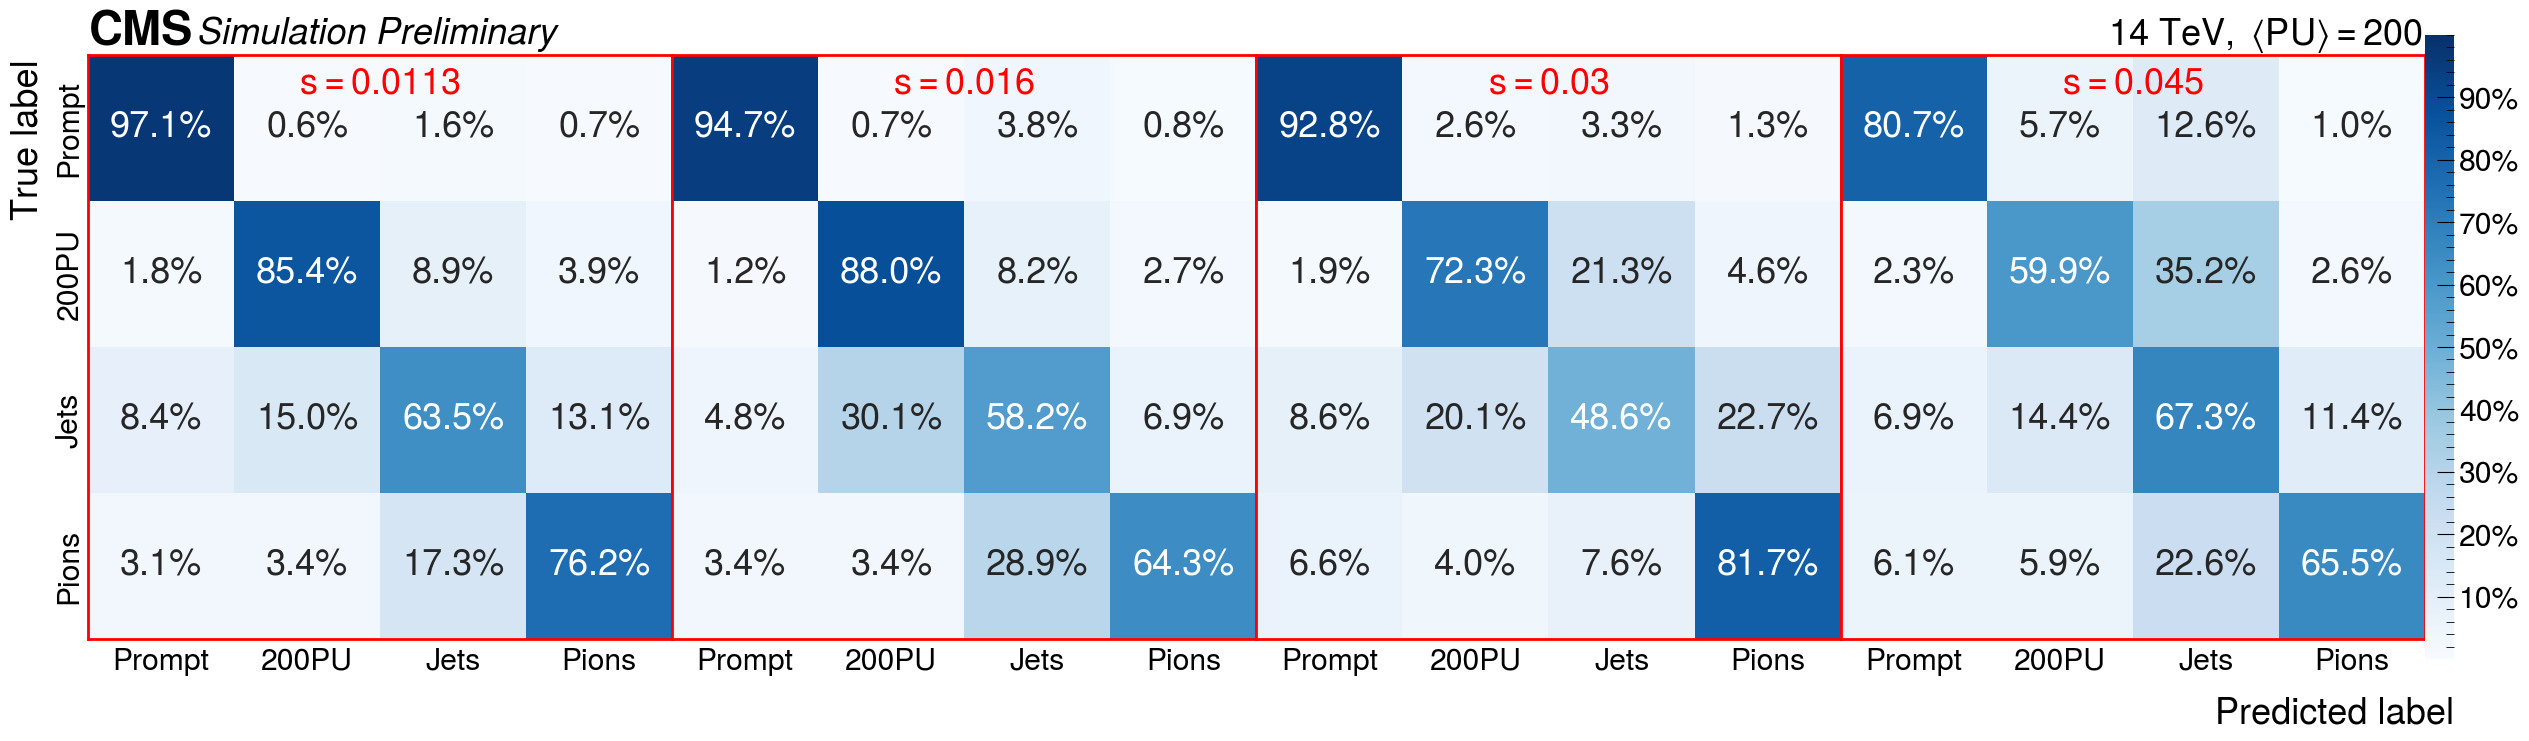

In [23]:
def plot_confusion_row_like_cms(
    results,
    outpath,
    class_names=("Photons", "200PU", "QCD", "Pions"),
    cms_left=r"$\bf{CMS}$ $\it{Simulation\ Preliminary}$",
    cms_right=r"$(14~\mathrm{TeV})$",
    cmap="Blues",
):

    n = len(results)
    if n == 0:
        print("No results to plot.")
        return

    # --- build row of panels + one dedicated colorbar axis
    fig = plt.figure(figsize=(26,8))
    gs = fig.add_gridspec(
        1, n + 1,
        width_ratios=[1]*n + [0.05],
        wspace=0
    )
    axes = [fig.add_subplot(gs[0, i]) for i in range(n)]
    cax  = fig.add_subplot(gs[0, -1])

    # --- compute percent matrices + global vmax (use 100)
    vmax = 100.0

    for i, r in enumerate(results):
        ax = axes[i]
        cm = np.asarray(r["cm"], dtype=float)

        # row-wise normalization to percent
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_pct = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0) * 100.0

        annot = np.array([[f"{v:.1f}%" for v in row] for row in cm_pct])

        # colorbar only on last axis (cax)
        show_cbar = (i == n-1)

        sns.heatmap(
            cm_pct,
            ax=ax,
            vmin=0, vmax=vmax,
            cmap=cmap,
            square=True,
            linewidths=0.0,
            annot=annot,
            fmt="",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=show_cbar,
            cbar_ax=cax if show_cbar else None,
            cbar_kws={"ticks": np.arange(10, 100, 10)} if show_cbar else None,
        )
        ax.tick_params(axis="both", which="both", length=0)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color("red")
            spine.set_linewidth(2.0)
        # if i != n - 1:
        #     ax.plot([1, 1], [0, 1], transform=ax.transAxes, color="k", lw=1.2, clip_on=False)
        # panel title: triangle label (small, top-left of each panel)
        tri = r["tri"]          # e.g. "p0113"
        aval = float("0." + tri[1:])
        ax.text(0.5, 0.98, rf"$\mathcal{{s}} = {aval}$", transform=ax.transAxes,
                ha="center", va="top", color = 'red')

        # axis label & tick cleanup to match screenshot
        #ax.tick_params(direction="in", top=True, right=True, which="both")

        if i != 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        # if i != n-1:
        #     ax.set_xlabel("")
        #     ax.set_xticklabels([])

        # remove seaborn default labels
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_ylabel("")

    cax.set_ylabel("")
    cax.tick_params()
    cax.set_yticklabels([f"{int(t)}%" for t in cax.get_yticks()])

    # Figure-level labels (only once)
    fig.text(
    0.03, 0.87,
    "True label", rotation =90, 
    ha="left", va="top",
)
    fig.text(
    0.97, 0.03,
    "Predicted label", 
    ha="right", va="bottom",
)
    #fig.supylabel("True label")
    mh.cms.label("Preliminary", data=False, ax=axes[0], loc=0, rlabel="")
    fig.text(0.958, 0.875, cms_right, ha="right", va="bottom")
    fig.subplots_adjust(top=0.90, bottom=0.12, left=0.06, right=0.97)
    fig.savefig(outpath, bbox_inches="tight", dpi=300)
    plt.show()

plot_confusion_row_like_cms(
    results,
    outpath="confusion_row.pdf",
    class_names=("Prompt", "200PU", "Jets", "Pions"),
    cms_right=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
)


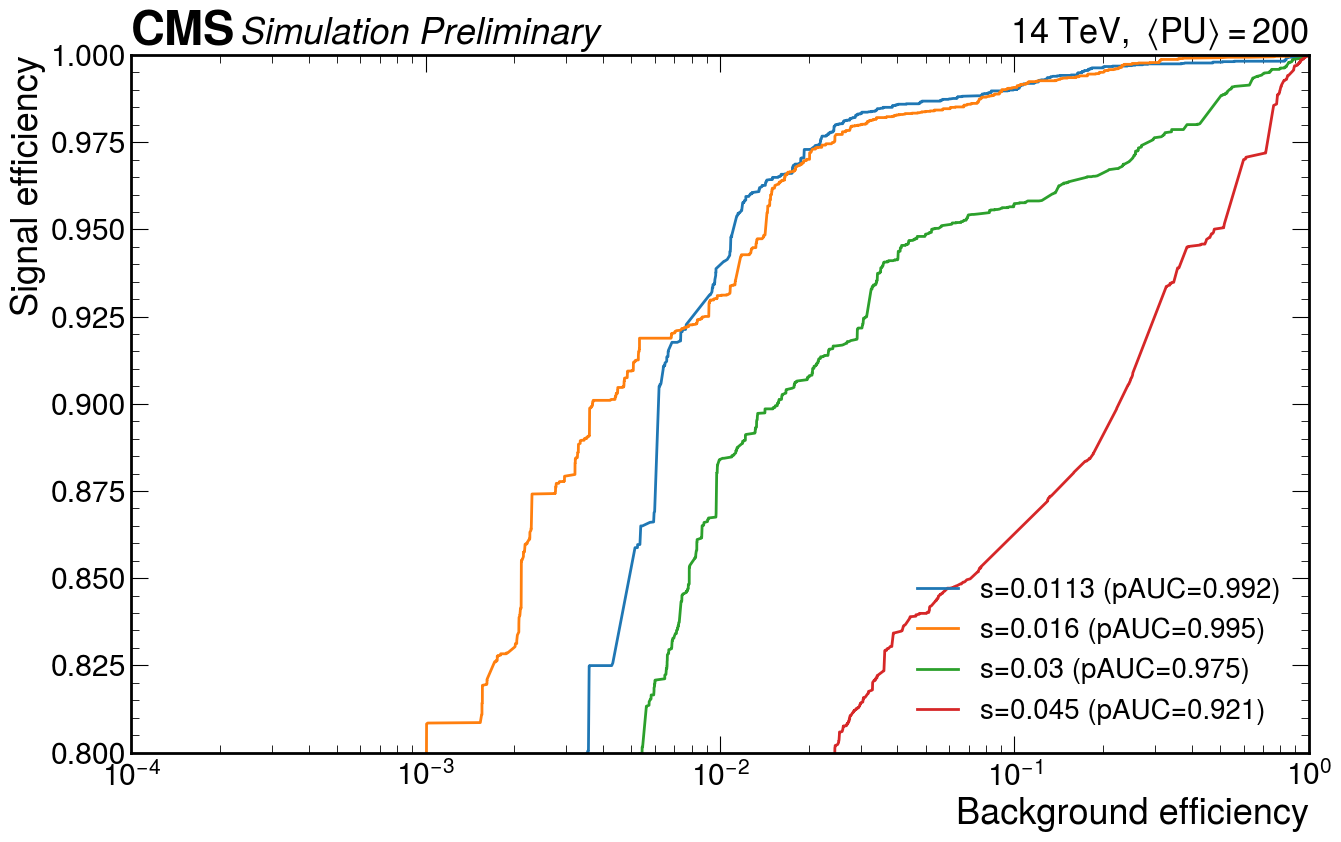

Saved to: triangle_comparison_plots


In [35]:

plot_photon_roc_overlay(
    results,
    outpath=os.path.join(OUTDIR, "roc_photon_vs_rest_overlay.pdf"),
    thr=THR_TPR,
    logx=True,
    logy=False
)

# Save summary table
summary.to_csv(os.path.join(OUTDIR, "triangle_comparison_summary.csv"), index=False)
print("Saved to:", OUTDIR)


In [39]:
import re
def _to_class_feature_matrix(shap_values, n_features):
    if isinstance(shap_values, list):
        return np.stack([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)  # (C, F)

    sv = np.asarray(shap_values)
    if sv.ndim != 3:
        raise ValueError(f"Expected list or 3D array for multiclass SHAP, got shape {sv.shape}")

    a, b, c = sv.shape
    if b == n_features:          # (N, F, C)
        return np.abs(sv).mean(axis=0).T
    if c == n_features:          # (N, C, F) or (C, N, F)
        if b <= 50:
            return np.abs(sv).mean(axis=0)   # (C, F)
        else:
            return np.abs(sv).mean(axis=1)   # (C, F)
    if a == n_features:          # rare
        return np.abs(sv).mean(axis=1).T

    raise ValueError(f"Could not identify feature axis: shap_values shape={sv.shape}, n_features={n_features}")


def shap_importance_series_multiclass(model, X, class_agg="mean"):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X)
    per_class = _to_class_feature_matrix(shap_vals, X.shape[1])  # (C, F)

    if class_agg == "mean":
        imp = per_class.mean(axis=0)
    elif class_agg == "max":
        imp = per_class.max(axis=0)
    elif class_agg == "sum":
        imp = per_class.sum(axis=0)
    else:
        raise ValueError("class_agg must be one of: mean, max, sum")

    return pd.Series(imp, index=list(X.columns))


def strip_triangle_prefix(feat_name: str) -> str:
    """
    Convert 'cl3d_p0113Tri_hw_coreshowerlenght' -> 'hw_coreshowerlenght'
    Works for p0113Tri, p016Tri, p03Tri, p045Tri, Ref, etc (as long as it's cl3d_<something>_...)
    """
    return re.sub(r"^cl3d_[^_]+_", "", feat_name)


def build_shap_importance_table(results, class_agg="mean", sample_n=None, random_state=0):
    rows = []
    for r in results:
        tri = r["tri"]
        model = r["model"]
        X = r["X_test"]

        if sample_n is not None and len(X) > sample_n:
            X = X.sample(sample_n, random_state=random_state)

        imp = shap_importance_series_multiclass(model, X, class_agg=class_agg)

        for feat, val in imp.items():
            rows.append({
                "base_feature": strip_triangle_prefix(feat),
                "tri": tri,
                "importance": float(val),
            })

    df_long = pd.DataFrame(rows)
    df_wide = (df_long
               .pivot_table(index="base_feature", columns="tri", values="importance", aggfunc="mean")
               .fillna(0.0))
    return df_long, df_wide


# Okabe–Ito colorblind-friendly palette
OKABE_ITO = {
    "orange": "#E69F00",
    "sky":    "#56B4E9",
    "green":  "#009E73",
    "yellow": "#F0E442",
    "blue":   "#0072B2",
    "red":    "#D55E00",
    "purple": "#CC79A7",
    "black":  "#000000",
}

def plot_shap_grouped_barh(
    df_wide,
    tri_order=("p0113", "p016", "p03", "p045"),
    tri_label_map=None,   # e.g. {"p0113":"s=0.0113", ...}
    tri_color_map=None,   # e.g. {"p0113":"#0072B2", ...}
    top_n=12,
    figsize=(13, 9),
    title=None,
    x_label="Relative SHAP importance [%]",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
):
    cols = [c for c in tri_order if c in df_wide.columns]
    if len(cols) == 0:
        raise ValueError(f"No triangle columns found in df_wide. Have: {list(df_wide.columns)}")

    # default label map
    if tri_label_map is None:
        tri_label_map = {k: k for k in cols}

    # default color map (colorblind friendly)
    if tri_color_map is None:
        tri_color_map = {
            "p0113": OKABE_ITO["blue"],
            "p016":  OKABE_ITO["orange"],
            "p03":   OKABE_ITO["green"],
            "p045":  OKABE_ITO["purple"],
        }

    dfp = df_wide[cols].copy()
    dfp["__avg__"] = dfp.mean(axis=1)
    dfp = dfp.sort_values("__avg__", ascending=False).head(top_n)
    dfp = dfp.drop(columns="__avg__")
    dfp = dfp / dfp.sum(axis=0) * 100.0
    features = dfp.index.to_list()
    nF = len(features)
    nT = len(cols)

    y = np.arange(nF)
    group_height = 0.8
    bar_h = group_height / nT

    fig, ax = plt.subplots(figsize=figsize)

    for i, tri in enumerate(cols):
        y_i = y - group_height/2 + (i + 0.5) * bar_h
        ax.barh(
            y_i,
            dfp[tri],
            height=bar_h,
            label=tri_label_map.get(tri, tri),
            color=tri_color_map.get(tri, OKABE_ITO["black"]),
        )

    ax.set_yticks(y)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel(x_label)
    if title:
        ax.set_title(title)

    ax.grid(True, axis="x", alpha=0.75)
    ax.legend(loc="lower right", frameon=False)
    mh.cms.label("Preliminary", data=False, rlabel=rlabel, ax=ax)

    plt.tight_layout()
    return fig, ax


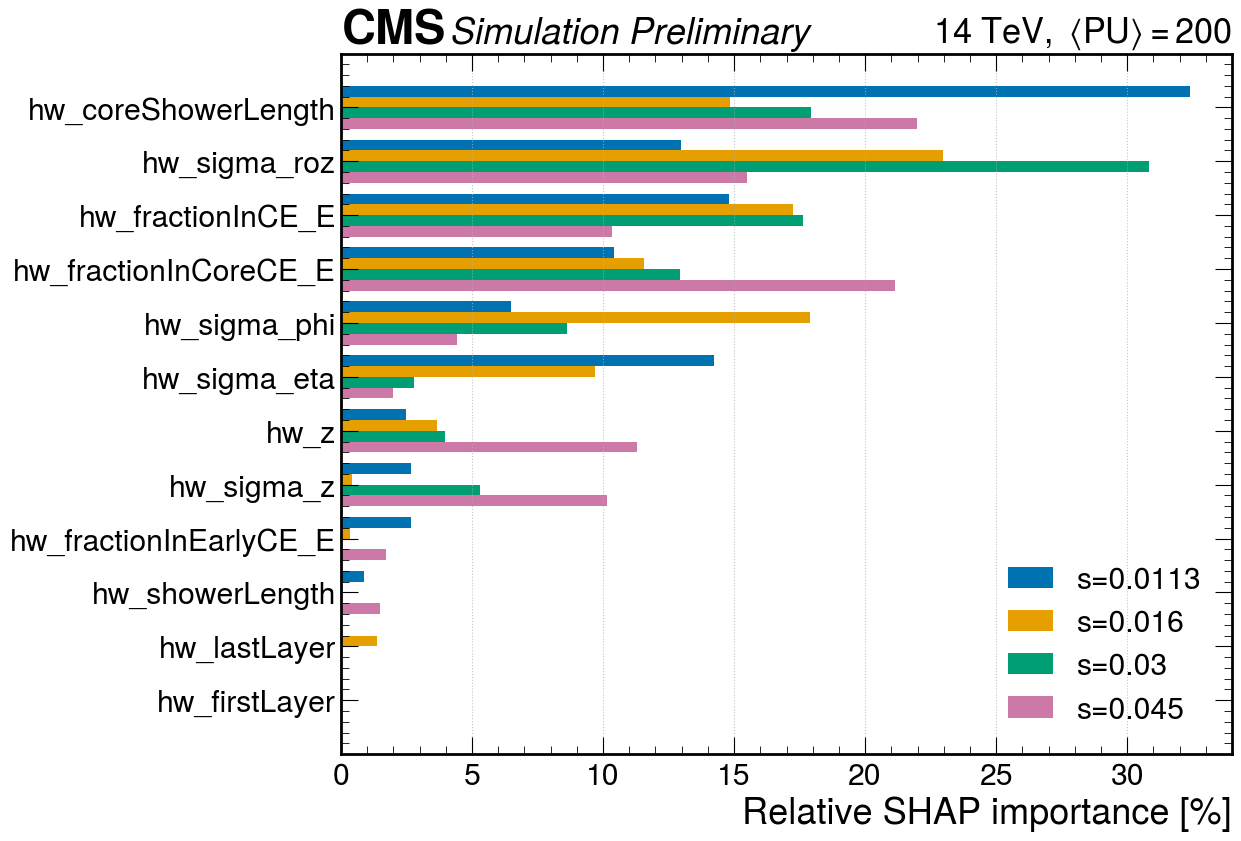

In [40]:
tri_label_map = {
    "p0113": "s=0.0113",
    "p016":  "s=0.016",
    "p03":   "s=0.03",
    "p045":  "s=0.045",
}
df_long, df_wide = build_shap_importance_table(results)
fig, ax = plot_shap_grouped_barh(
    df_wide,
    tri_order=("p0113","p016","p03","p045"),
    tri_label_map=tri_label_map,
    top_n=12,
    title=""
)

fig.savefig(f"{OUTDIR}/SHAP_grouped_importance_triangles_colorblind.pdf", bbox_inches="tight")
plt.show()


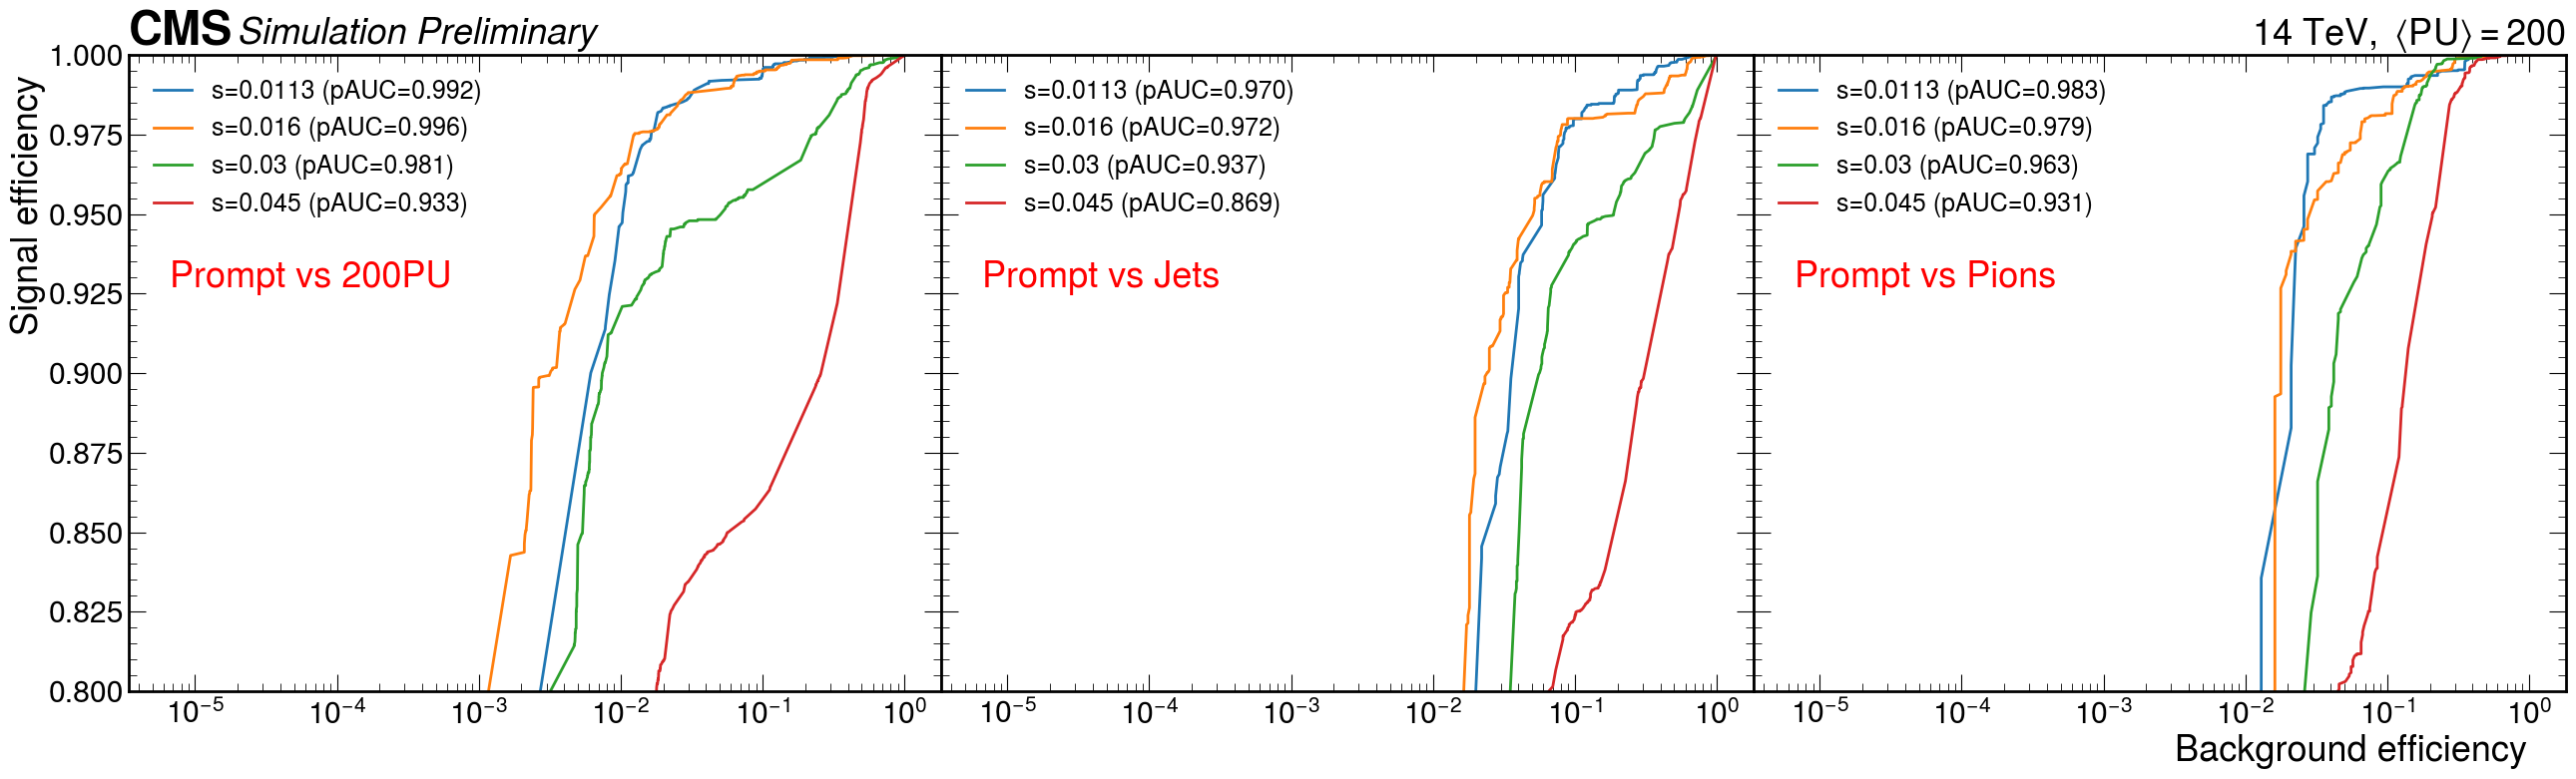

In [69]:
def plot_photon_ovo_roc_row_like_cms(
    results,
    outpath,
    thr=THR_TPR,
    logx=True,
    logy=False,
    photon_class=PHOTON_CLASS,
    opponent_classes=(1, 2, 3),
    class_names=class_names,
    use_weights=True,
    cms_rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
):
    """
    Row of panels (like your confusion matrix row):
      each panel = OvO ROC for Prompt vs opponent
      curves in panel = overlay triangle sizes

    Requires each r in results:
      r["tri"], r["y_test"], r["y_proba"], and optionally r["w_test"] if use_weights=True
    """

    n = len(opponent_classes)
    fig = plt.figure(figsize=(26,8))
    gs = fig.add_gridspec(1, n, wspace=0.0)

    axes = []
    for k, j in enumerate(opponent_classes):
        ax = fig.add_subplot(gs[0, k], sharex=axes[0] if axes else None, sharey=axes[0] if axes else None)
        axes.append(ax)

        # --- plot all triangle curves on this panel
        for r in results:
            y = np.asarray(r["y_test"])
            proba = np.asarray(r["y_proba"])
            w = np.asarray(r["w_test"]) if (use_weights and "w_test" in r) else None

            m = (y == photon_class) | (y == j)
            if np.count_nonzero(m) < 2:
                continue

            y_bin = (y[m] == photon_class).astype(int)

            p_g = proba[m, photon_class]
            p_j = proba[m, j]
            score = p_g / (p_g + p_j + 1e-12)

            w_m = w[m] if w is not None else None

            fpr, tpr, _ = roc_curve(y_bin, score, sample_weight=w_m, drop_intermediate=False)

            keep = tpr >= thr
            pauc = auc(fpr[keep], tpr[keep]) if np.count_nonzero(keep) >= 2 else np.nan

            tri = r["tri"]
            aval = float("0." + tri[1:])

            pair_name = f"{class_names[photon_class]} vs {class_names[j]}"
            if np.isfinite(pauc):
                lab = f"s={aval} (pAUC={pauc:.3f})"
            else:
                lab = f"s={aval}"

            ax.plot(fpr, tpr, lw=2, label=lab)

        # --- cosmetics per panel
        ax.text(0.05, 0.65, f"{class_names[photon_class]} vs {class_names[j]}", transform=ax.transAxes,
                ha="left", va="center", color = 'red')
        ax.set_ylim([thr, 1.0])
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")
        # Only leftmost panel gets y-label
        if k == 0:
            ax.set_ylabel("", fontsize=16)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis="y", which="both", labelleft=False)
        ax.tick_params(axis="x", which ='both', labelright=False)

        # Legend inside each panel (cleanest) — or switch to one global legend below
        ax.legend(loc="upper left", fontsize=18, frameon=False)

    # CMS label once (top-left). Put on first axis so mplhep places it nicely.
    # Figure-level labels (only once)
    fig.text(
    0.0, 0.87,
    "Signal efficiency", rotation = 90, 
    ha="left", va="top",
)
    fig.text(
    0.97, 0.0,
    "Background efficiency", 
    ha="right", va="bottom",
)
    mh.cms.label("Preliminary", data=False, ax=axes[0], rlabel='')
    fig.text(0.985, 0.895, r"$14~\mathrm{TeV},\ \langle PU\rangle=200$", ha="right", va="bottom")
    fig.tight_layout()
    fig.savefig(outpath, bbox_inches="tight", dpi=300)
    plt.show()

plot_photon_ovo_roc_row_like_cms(
    results,
    outpath=os.path.join(OUTDIR, "roc_row_ovo_prompt_vs_others.pdf"),
    thr=THR_TPR,
    logx=True,
    logy=False,
    use_weights=True,   # uses balanced w_test if you stored it
)

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as mh

mh.style.use("CMS")


def _translate_col(col, src_prefix, dst_prefix):
    return col.replace(f"cl3d_{src_prefix}_", f"cl3d_{dst_prefix}_")


def plot_triangles_row_clean(
    tri_cfg,
    tri_order,
    var_ref,
    var_latex_map_ref,
    outdir,
    src_prefix="Ref",
    cl3d_pt_range=(20, 100),
    num_bins=10,
    figsize=(18, 4.6),
    yscale="log",
    cms_label="Simulation Preliminary",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
    annotate_a=True,                 # write "a = 0.0113" etc
):
    os.makedirs(outdir, exist_ok=True)
    prefix_map = {
    "p0113": "p0113Tri",
    "p016":  "p016Tri",
    "p03":   "p03Tri",
    "p045":  "p045Tri",
    "Ref":   "Ref",
}
    samples = [
        ("Prompt photons",   "photon", "b"),
        ("Photons from jets","qcd",    "g"),
        ("Pions",            "pion",   "r"),
        ("PU200",            "pu",     "k"),
    ]

    # --- collect arrays globally for shared bins
    arrays = {}
    all_arrays = []

    for tri in tri_order:
        cfg = tri_cfg[tri]
        pref = prefix_map[tri]
        pt_col = f"cl3d_{pref}_pt"
        var_tri = _translate_col(var_ref, src_prefix, pref)

        for _, sample_key, _ in samples:
            df = cfg[sample_key]
            if pt_col not in df.columns or var_tri not in df.columns:
                continue
            m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
            a = df.loc[m, var_tri].to_numpy()
            a = a[np.isfinite(a)]
            if len(a) == 0:
                continue
            arrays[(tri, sample_key)] = a
            all_arrays.append(a)

    if not all_arrays:
        print("Nothing to plot for", var_ref)
        return

    concat = np.concatenate(all_arrays)
    vmin, vmax = np.min(concat), np.max(concat)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        print("Bad range for", var_ref)
        return

    is_intlike = np.all(np.isclose(concat, np.round(concat)))
    if is_intlike:
        bin_edges = np.arange(vmin - 0.5, vmax + 1.5, 1)
    else:
        bin_edges = np.linspace(vmin, vmax, num_bins + 1)

    # --- build row of panels
    fig, axes = plt.subplots(1, len(tri_order), figsize=figsize, sharex=True, sharey=True)
    if len(tri_order) == 1:
        axes = [axes]

    for i, tri in enumerate(tri_order):
        ax = axes[i]
        for lab, sample_key, col in samples:
            a = arrays.get((tri, sample_key))
            if a is None:
                continue
            ax.hist(a, bins=bin_edges, histtype="step", density=True,
                    linewidth=1.6, color=col, label=lab)
        if annotate_a:
            # extract number from tri name if possible
            # e.g. "p0113" -> 0.0113
            if tri.startswith("p") and tri[1:].replace(".", "").isdigit():
                aval = float("0." + tri[1:])
                ax.text(0.5, 0.9, rf"$\mathbf{{s}} = {aval}$", transform=ax.transAxes,
                         color="red")

        if yscale == "log":
            ax.set_yscale("log")

        ax.tick_params(direction="in", top=True, right=True, which="both")
        if i != 0:
            ax.tick_params(labelleft=False)
    
    # shared labels (figure-level)
    fig.text(
    0.03, 0.87,
    "a.u.", rotation =90, 
    ha="left", va="top",
)
    fig.text(
    0.97, 0.03,
    "$\sigma_{r/z}$", 
    ha="right", va="bottom",
)
    plt.xlim(0,0.024584)
    # legend INSIDE last axis (so it doesn't crush layout)
    axes[-1].legend(loc="lower right", frameon=False, fontsize=20)

    # leave room at top for CMS label
    fig.subplots_adjust(left=0.07, right=0.985, bottom=0.15, top=0.90, wspace=0.0)

    # CMS label ONCE, figure-level anchored to left/top margin
    # Put it on the first axis but using OUTSIDE coords so it doesn't overlap panels
    mh.cms.label(cms_label, data=False, ax=axes[0], loc=0, rlabel="")
    fig.text(0.985, 0.9, rlabel, ha="right", va="bottom")
    outpath = os.path.join(outdir, f"triRow_{var_ref}.pdf")
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    print("Saved:", outpath)
    plt.show()
    plt.close(fig)

def dequantize_uniform(code, n_bits=5, vmin=0.0, vmax=0.148922, mode="endpoints"):
    """
    code: array-like (int or float), expected in [0, 2^n_bits - 1]
    mode:
      - "endpoints": code=0 -> vmin, code=max_code -> vmax  (use / (2^n_bits-1))
      - "centers":   code -> center of uniform bin         (use (code+0.5)/2^n_bits)
    """
    code = np.asarray(code, dtype=float)
    max_code = (1 << n_bits) - 1  # 31 for 5 bits

    # keep NaNs, clip valid values
    out = np.full_like(code, np.nan, dtype=float)
    m = np.isfinite(code)
    c = np.clip(code[m], 0, max_code)

    if mode == "endpoints":
        out[m] = vmin + (c / max_code) * (vmax - vmin)
    elif mode == "centers":
        out[m] = vmin + ((c + 0.5) / (max_code + 1.0)) * (vmax - vmin)
    else:
        raise ValueError("mode must be 'endpoints' or 'centers'")
    return out

In [89]:
for tri, cfg in tri_cfg.items():
    pref = {"p0113":"p0113Tri","p016":"p016Tri","p03":"p03Tri","p045":"p045Tri","Ref":"Ref"}[tri]
    col_q = f"cl3d_{pref}_hw_sigma_roz"            # quantised 5-bit
    col_u = f"cl3d_{pref}_hw_sigma_roz_unq"        # dequantised float

    for k in ["photon", "qcd", "pion", "pu"]:
        df = cfg[k]
        if col_q in df.columns:
            df[col_u] = dequantize_uniform(df[col_q].to_numpy(),
                                           n_bits=7, vmin=0.0, vmax=0.024584,
                                           mode="endpoints")

Saved: tri_size_comparison_row/triRow_cl3d_Ref_hw_sigma_roz_unq.pdf


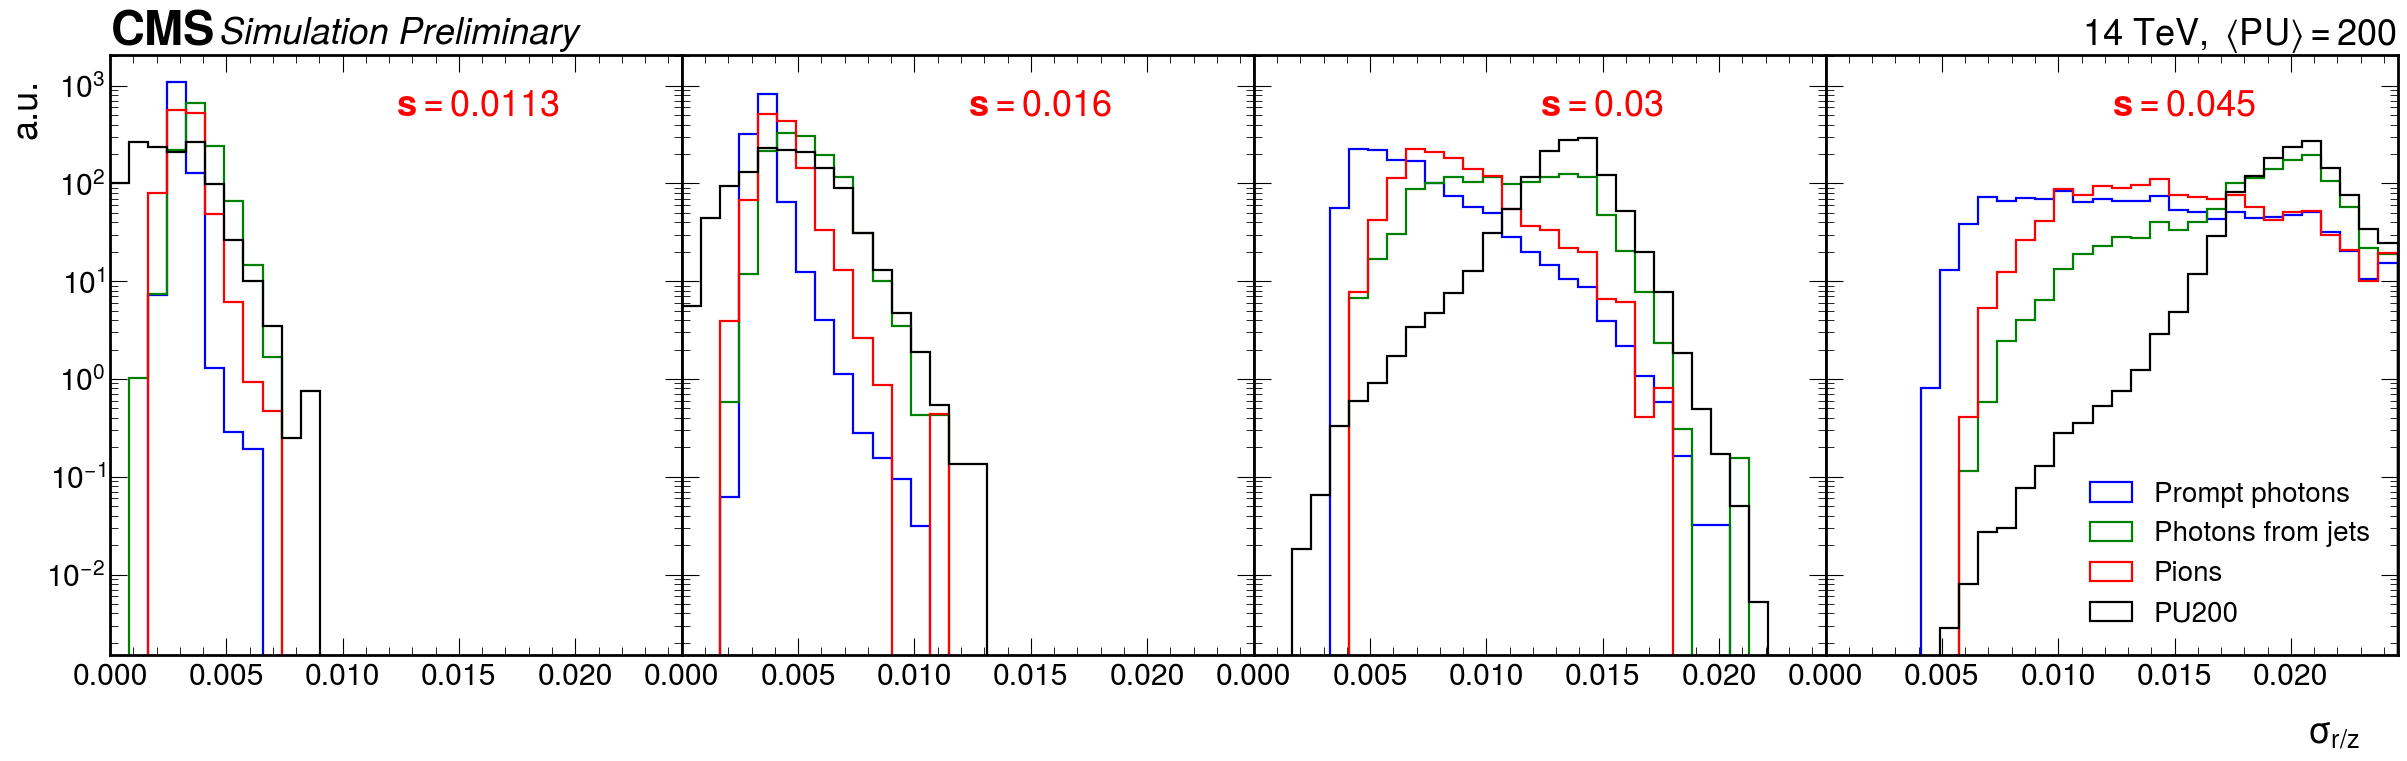

In [90]:
plot_triangles_row_clean(
    tri_cfg=tri_cfg,
    tri_order=["p0113","p016","p03","p045"],
    var_ref="cl3d_Ref_hw_sigma_roz_unq",   # <<<<< use _unq
    var_latex_map_ref=ana.var_map("Ref"),
    outdir="tri_size_comparison_row",
    cl3d_pt_range=(20, 100),
    num_bins=30,
    figsize=(25, 8),
    cms_label="Preliminary",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$"
)

Saved: tri_size_comparison_row/triRow_cl3d_Ref_hw_sigma_eta.pdf


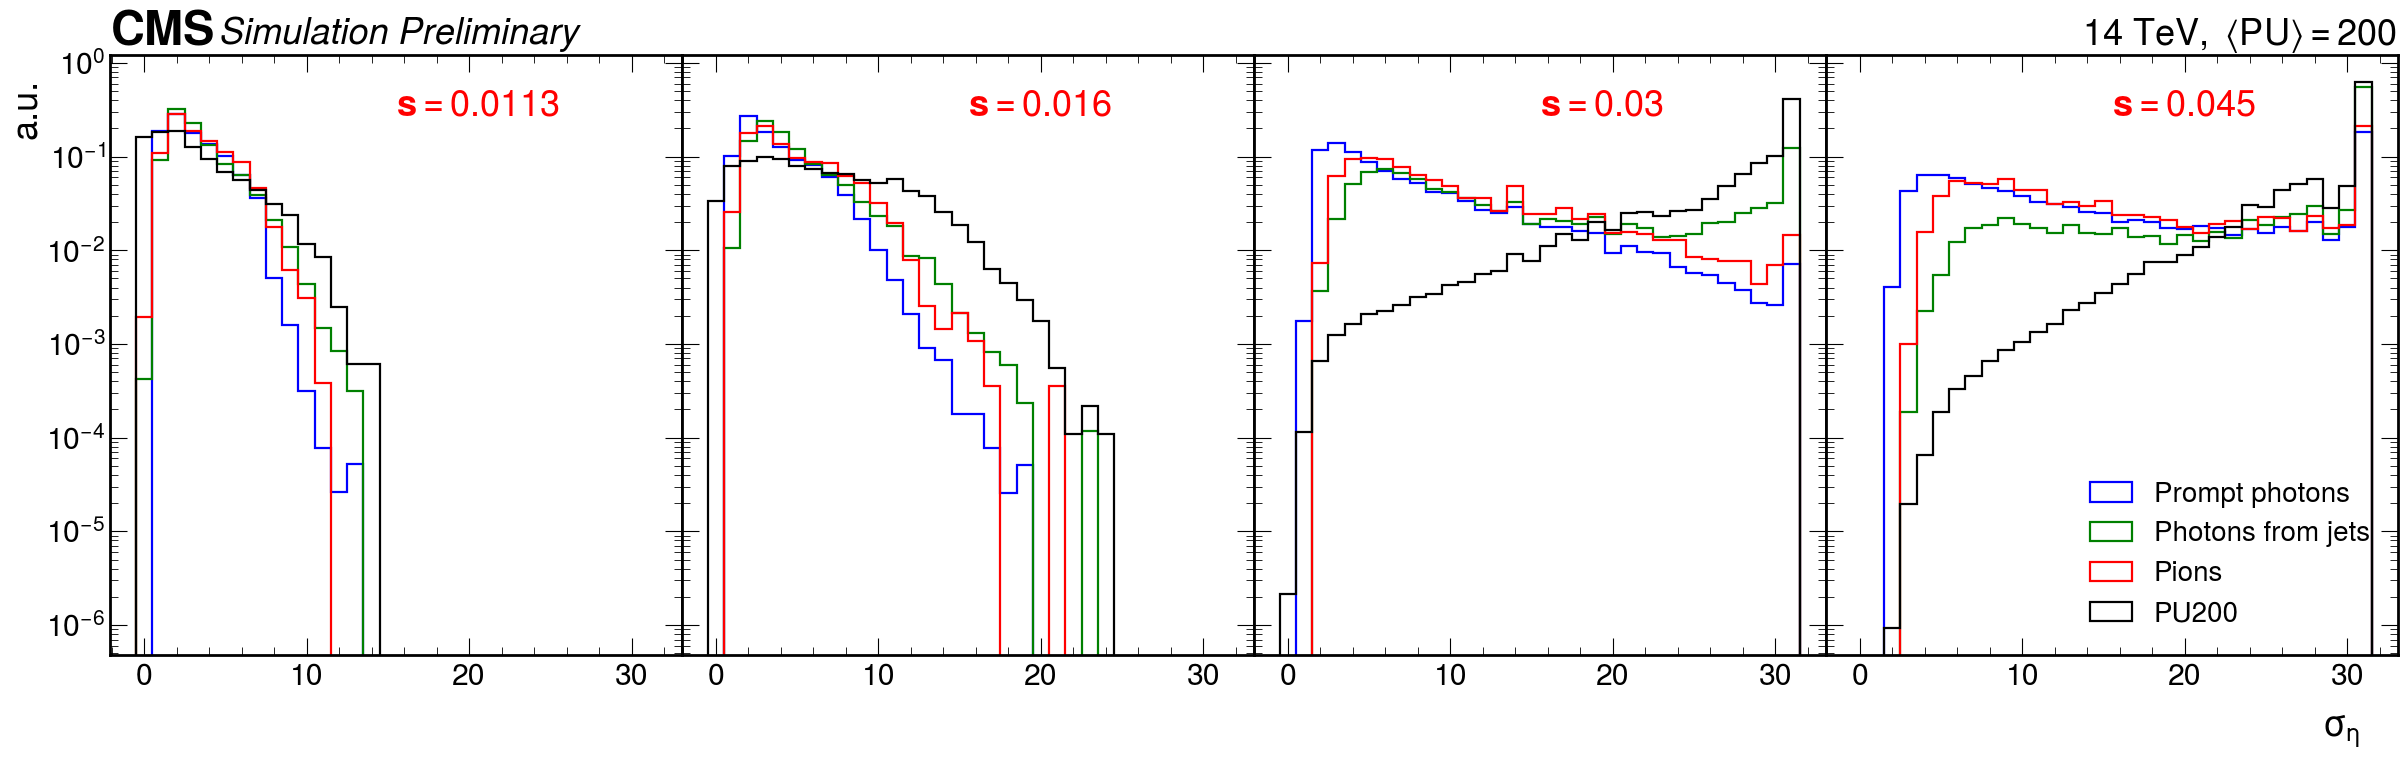

In [43]:

tri_order = ["p0113", "p016", "p03", "p045"]

plot_triangles_row_clean(
    tri_cfg=tri_cfg,
    tri_order=tri_order,
    var_ref="cl3d_Ref_hw_sigma_eta",
    var_latex_map_ref=ana.var_map("Ref"),
    outdir="tri_size_comparison_row",
    cl3d_pt_range=(20, 100),
    num_bins=40,
    figsize=(25, 8),
    cms_label="Preliminary",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$"
)


In [18]:
all_dfs = [photon_df_p0113_filtered, PU_df_p0113, qcd_df_p0113_filtered, pion_df_p0113_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][columns_for_training('p0113Tri') + ['label']]

In [19]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [20]:
X = df_combined[columns_for_training('p0113Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

In [21]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weights, test_size=0.2, stratify=y, random_state=42)

In [22]:
model_multiclass = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=4,
    n_estimators=50,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [23]:
model_multiclass.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [101]:
PHOTON = 0
BKG = {"PU": 1, "QCD": 2, "PION": 3}

def make_binary_dataset(X, y, bkg_label, photon_label=PHOTON):
    mask = (y == photon_label) | (y == bkg_label)
    X_sub = X[mask]
    y_sub = (y[mask] == photon_label).astype(int)  # 1=photon, 0=background
    return X_sub, y_sub

def make_binary_model(**overrides):
    params = dict(
        objective="binary:logistic",
        max_depth=5,
        n_estimators=50,
        learning_rate=0.001,
        eval_metric="logloss",
        n_jobs=8,
        verbosity=1
    )
    params.update(overrides)
    return xgb.XGBClassifier(**params)


In [102]:
binary_models = {}
binary_splits = {}  # store test sets so you can compare later

for name, bkg_lab in BKG.items():
    X_bin, y_bin = make_binary_dataset(X, y, bkg_lab)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_bin, y_bin,
        test_size=0.2,
        random_state=42,
        stratify=y_bin
    )

    # Optional: class balancing via sample weights (recommended if imbalanced)
    w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)

    model = make_binary_model()
    model.fit(X_tr, y_tr, sample_weight=w_tr)

    binary_models[name] = model
    binary_splits[name] = (X_te, y_te)


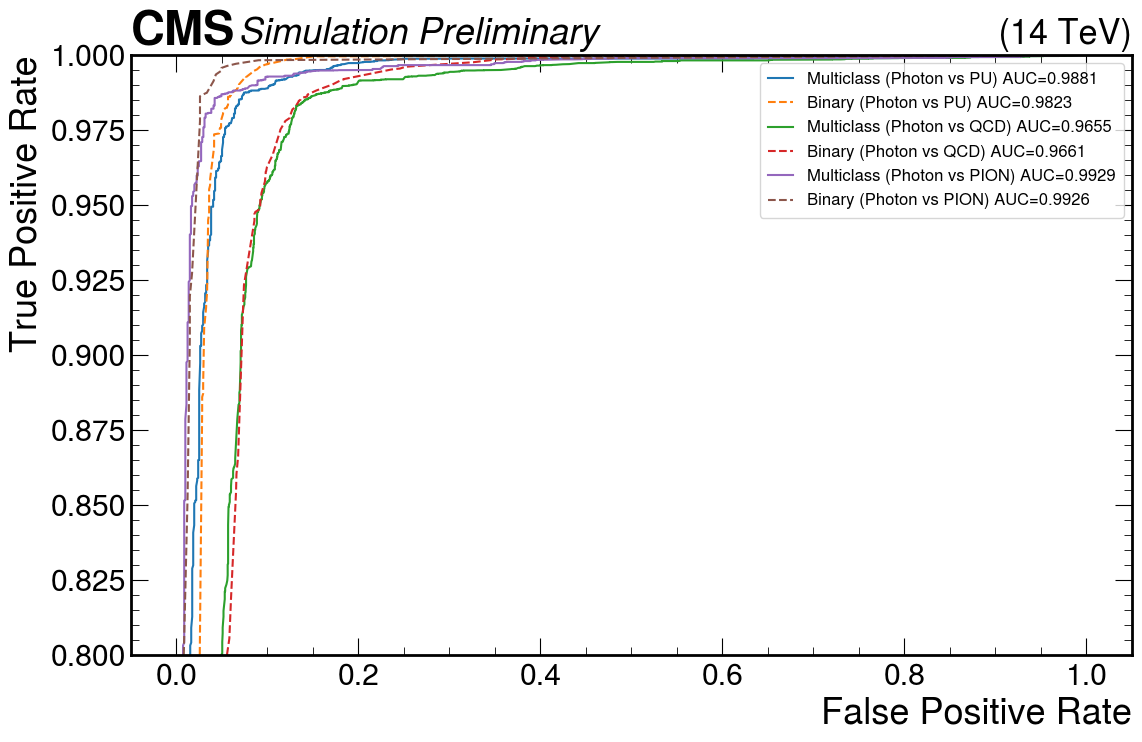

In [107]:
plt.figure(figsize=(12, 8))
proba_mc_test = model_multiclass.predict_proba(X_test)
for name, bkg in BKG.items():
    # select the SAME test events for that pair
    mask_te = (y_test == PHOTON) | (y_test == bkg)

    # truth for this pair: 1=photon, 0=bkg
    y_true = (y_test[mask_te] == PHOTON).astype(int)

    # multiclass photon score for those events
    score_mc = proba_mc_test[mask_te, PHOTON]

    # binary photon score on the same events
    X_te_pair = X_test[mask_te]
    score_bin = binary_models[name].predict_proba(X_te_pair)[:, 1]

    # ROC + AUC
    fpr_mc, tpr_mc, _ = roc_curve(y_true, score_mc)
    fpr_b,  tpr_b,  _ = roc_curve(y_true, score_bin)

    auc_mc = auc(fpr_mc, tpr_mc)
    auc_b  = auc(fpr_b,  tpr_b)

    plt.plot(fpr_mc, tpr_mc, label=f"Multiclass (Photon vs {name}) AUC={auc_mc:.4f}")
    plt.plot(fpr_b,  tpr_b,  linestyle="--", label=f"Binary (Photon vs {name}) AUC={auc_b:.4f}")

# diagonal
#plt.plot([0, 1], [0, 1], linestyle=":", linewidth=1)
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(0.8,1.0)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=12, frameon=True)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit

plt.tight_layout()
plt.show()

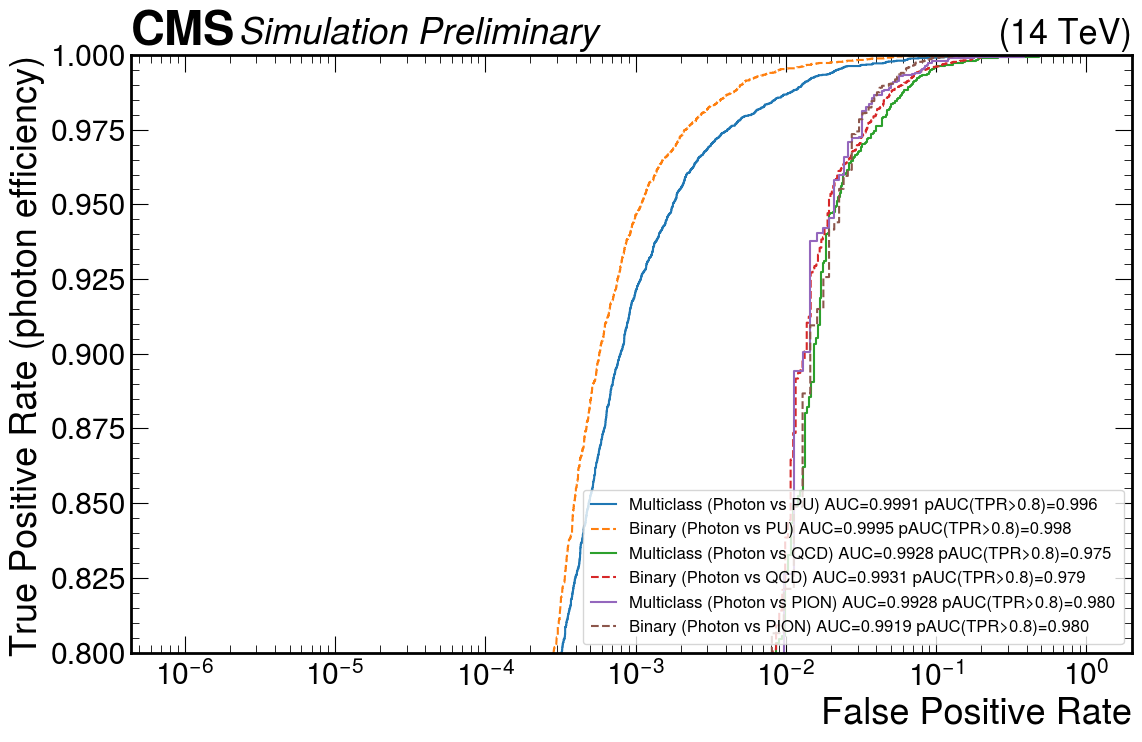

In [103]:
TPR_MIN = 0.8
def partial_auc_tpr_above(fpr, tpr, tpr_min=0.8):
    """
    Normalized partial AUC in [0,1] for the ROC region with TPR > tpr_min.
    Defined as area of (TPR - tpr_min) vs FPR, normalized by (1 - tpr_min).
    """
    fpr = np.asarray(fpr)
    tpr = np.asarray(tpr)
    excess = np.clip(tpr - tpr_min, 0.0, None)
    return auc(fpr, excess) / (1.0 - tpr_min)

def make_binary_dataset(X_in, y_in, bkg_label, photon_label=PHOTON):
    mask = (y_in == photon_label) | (y_in == bkg_label)
    X_sub = X_in[mask]
    y_sub = (y_in[mask] == photon_label).astype(int)  # 1=photon, 0=bkg
    return X_sub, y_sub, mask

def make_binary_model():
    return xgb.XGBClassifier(
        objective="binary:logistic",
        max_depth=5,
        n_estimators=50,
        learning_rate=0.1,
        eval_metric="logloss",
        n_jobs=8,
        verbosity=1
    )

# -----------------------
# 1) ONE split for fairness
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------
# 2) Multiclass model (must be softprob to get probabilities)
# -----------------------
model_multiclass = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=4,
    max_depth=5,
    n_estimators=50,
    learning_rate=0.1,
    eval_metric="mlogloss",
    n_jobs=8,
    verbosity=1
)

w_mc = compute_sample_weight(class_weight="balanced", y=y_train)
model_multiclass.fit(X_train, y_train, sample_weight=w_mc)

proba_mc_test = model_multiclass.predict_proba(X_test)  # (N,4)

# -----------------------
# 3) Train 3 binary models (on TRAIN only)
# -----------------------
binary_models = {}
for name, bkg_lab in BKG.items():
    X_tr_sub, y_tr_sub, _ = make_binary_dataset(X_train, y_train, bkg_lab)
    w_tr_sub = compute_sample_weight(class_weight="balanced", y=y_tr_sub)

    m = make_binary_model()
    m.fit(X_tr_sub, y_tr_sub, sample_weight=w_tr_sub)
    binary_models[name] = m

# -----------------------
# 4) Plot: OvO ROCs (multiclass) + overlay binary, with pAUC in [0,1]
# -----------------------
plt.figure(figsize=(12, 8))

for name, bkg_lab in BKG.items():
    mask_te = (y_test == PHOTON) | (y_test == bkg_lab)
    y_true = (y_test[mask_te] == PHOTON).astype(int)  # 1=photon, 0=bkg

    # Multiclass photon score for those events
    score_mc = proba_mc_test[mask_te, PHOTON]

    # Binary photon score for those events
    X_te_pair = X_test[mask_te]
    score_bin = binary_models[name].predict_proba(X_te_pair)[:, 1]

    # ROC
    fpr_mc, tpr_mc, _ = roc_curve(y_true, score_mc)
    fpr_b,  tpr_b,  _ = roc_curve(y_true, score_bin)

    # Full AUC
    auc_mc = auc(fpr_mc, tpr_mc)
    auc_b  = auc(fpr_b,  tpr_b)

    # Partial AUC (normalized to [0,1])
    pauc_mc = partial_auc_tpr_above(fpr_mc, tpr_mc, tpr_min=TPR_MIN)
    pauc_b  = partial_auc_tpr_above(fpr_b,  tpr_b,  tpr_min=TPR_MIN)

    plt.semilogx(
        fpr_mc, tpr_mc,
        label=rf"Multiclass (Photon vs {name}) AUC={auc_mc:.4f} pAUC(TPR>{TPR_MIN})={pauc_mc:.3f}"
    )
    plt.semilogx(
        fpr_b, tpr_b, linestyle="--",
        label=rf"Binary (Photon vs {name}) AUC={auc_b:.4f} pAUC(TPR>{TPR_MIN})={pauc_b:.3f}"
    )

# Optional diagonal (avoid 0 on log-x)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (photon efficiency)")
plt.legend(fontsize=12, frameon=True)
plt.ylim(0.8,1.0)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit

plt.tight_layout()
plt.show()

In [24]:
explainer = shap.TreeExplainer(model_multiclass)
shap_values = explainer.shap_values(X_test)

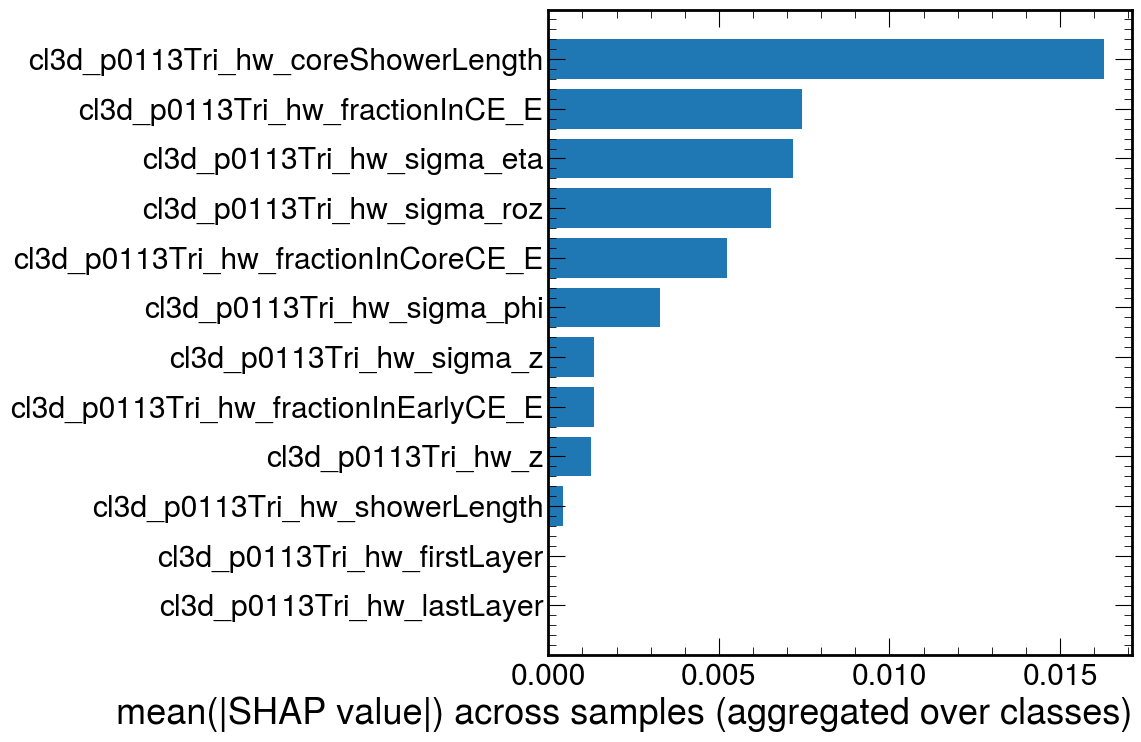

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _to_class_feature_matrix(shap_values, n_features):
    """
    Return per_class_importance matrix with shape (n_classes, n_features):
      per_class[c, j] = mean_i |phi_{i,j,c}|
    Supports:
      - list of (N, F) per class
      - array (N, F, C)
      - array (C, N, F)
      - array (N, C, F)
    """
    if isinstance(shap_values, list):
        # list length = C, each (N, F)
        per_class = np.stack([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)  # (C, F)
        return per_class

    sv = np.asarray(shap_values)
    if sv.ndim != 3:
        raise ValueError(f"Expected list or 3D array for multiclass SHAP, got shape {sv.shape}")

    a, b, c = sv.shape

    # Identify which axis is features by matching n_features
    if b == n_features:
        # (N, F, C)
        return np.abs(sv).mean(axis=0).T  # (F, C) -> transpose to (C, F)
    if c == n_features:
        # could be (N, C, F) or (C, N, F)
        # decide by checking which axis looks like classes (small number)
        if b <= 20:  # heuristic: classes usually small
            # (N, C, F)
            return np.abs(sv).mean(axis=0)  # mean over N -> (C, F)
        else:
            # (C, N, F)
            return np.abs(sv).mean(axis=1)  # mean over N -> (C, F)
    if a == n_features:
        # (F, N, C) rare; handle anyway
        return np.abs(sv).mean(axis=1).T  # (F, C) -> (C, F)

    raise ValueError(
        f"Could not identify feature axis. shap_values shape={sv.shape}, n_features={n_features}."
    )

def shap_global_importance_multiclass(shap_values, X, class_agg="mean"):
    n_features = X.shape[1]
    per_class = _to_class_feature_matrix(shap_values, n_features)  # (C, F)

    if class_agg == "mean":
        imp = per_class.mean(axis=0)   # (F,)
    elif class_agg == "max":
        imp = per_class.max(axis=0)
    elif class_agg == "sum":
        imp = per_class.sum(axis=0)
    else:
        raise ValueError("class_agg must be one of: mean, max, sum")

    feature_names = list(X.columns) if hasattr(X, "columns") else [f"f{i}" for i in range(n_features)]
    return pd.Series(imp, index=feature_names).sort_values(ascending=True)

# ---- compute + plot ----
imp = shap_global_importance_multiclass(shap_values, X_test, class_agg="mean")

plt.figure(figsize=(12,8))
plt.barh(imp.index, imp.values)
plt.xlabel("mean(|SHAP value|) across samples (aggregated over classes)")
plt.tight_layout()
plt.show()


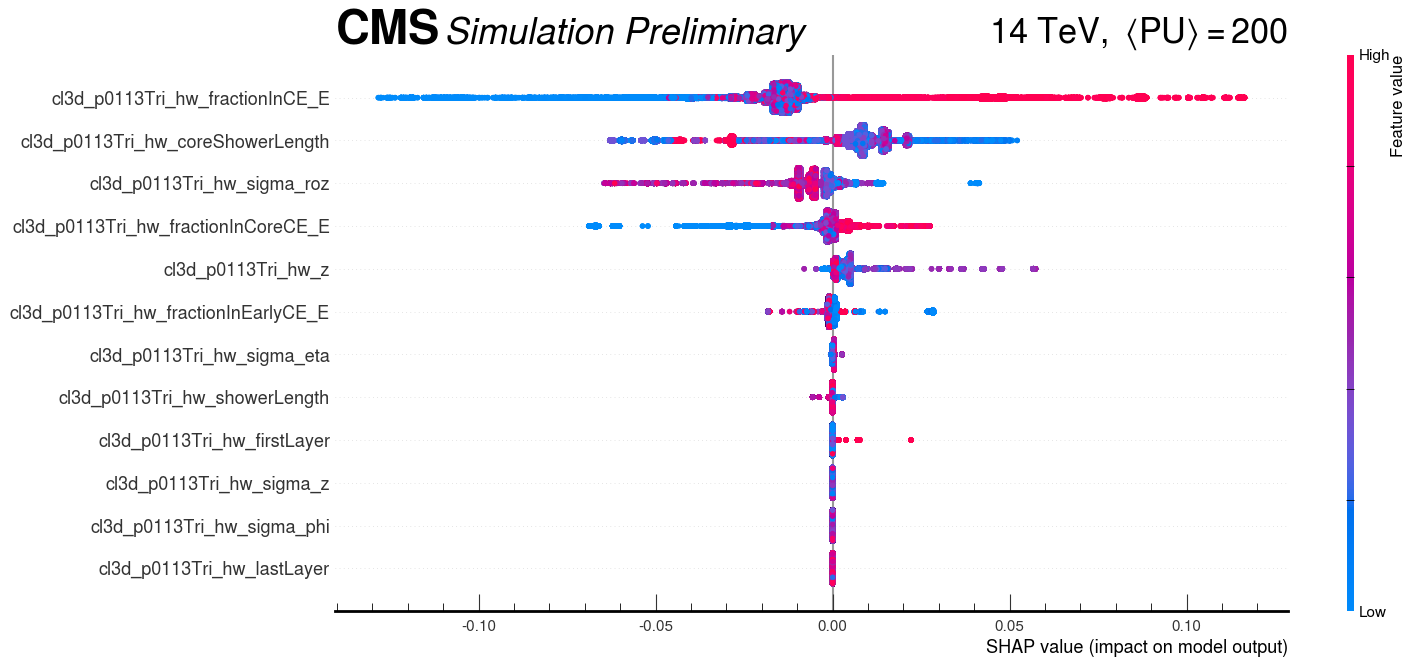

In [30]:
gamma_idx = 0 
pu_idx  = 1
qcd_idx = 2
pion_idx  = 3         
sv_gamma = shap_values[:, :, gamma_idx]
sv_pion  = shap_values[:, :, pion_idx]
sv_delta = sv_gamma - sv_pion
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p0113Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(24,7)
mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",) # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_pion_p0113.pdf", bbox_inches="tight")
plt.show()


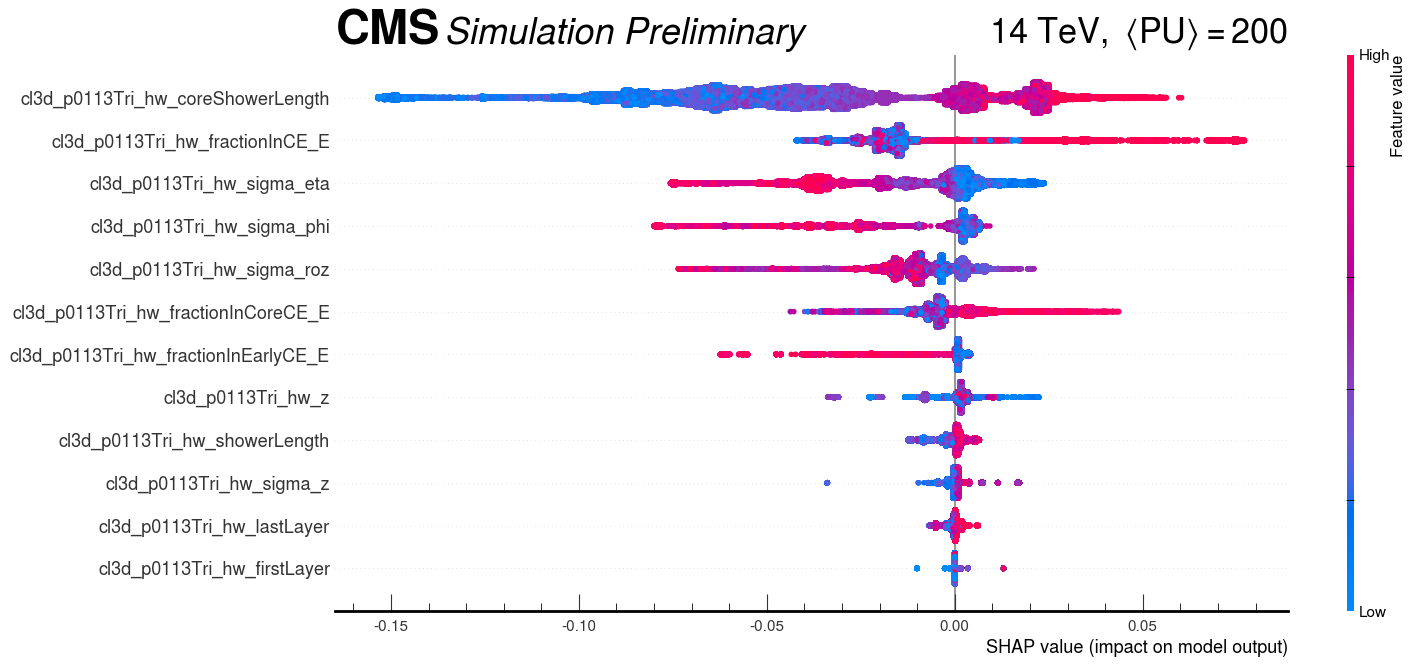

In [24]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_pu  = shap_values[:, :, pu_idx]
sv_delta = sv_gamma - sv_pu
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p0113Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(24,7)
mh.cms.label("Preliminary", data=False, rlabel= r"$14~\mathrm{TeV},\ \langle PU\rangle=200$") # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_PU200_p0113.pdf", bbox_inches="tight")
plt.show()

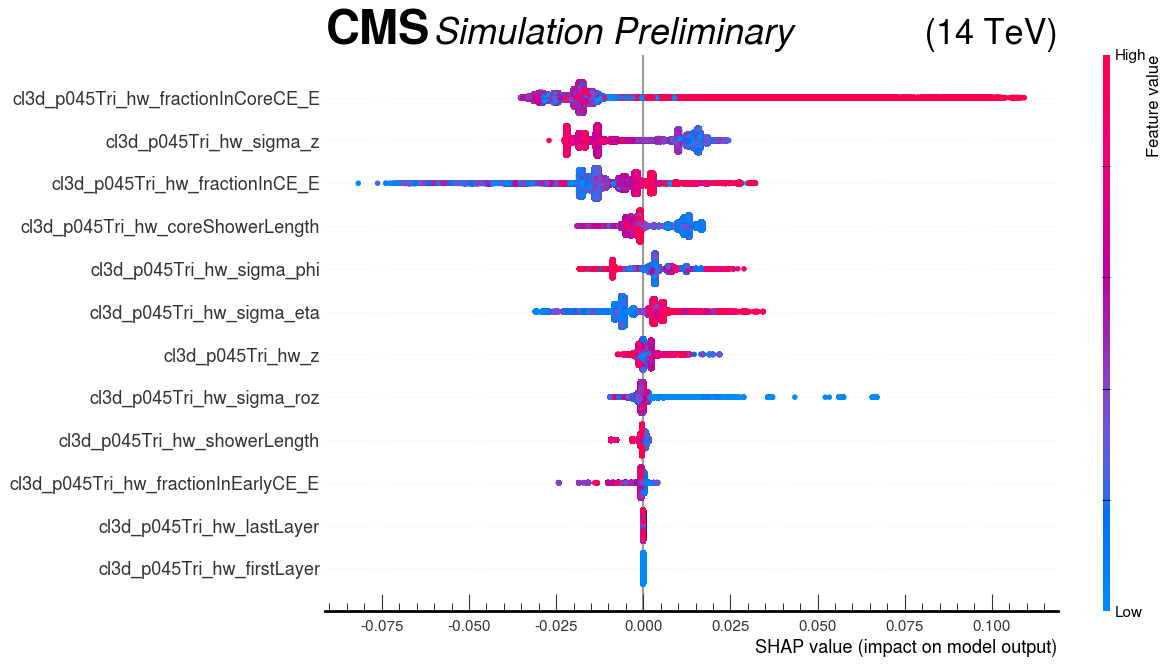

In [135]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_qcd  = shap_values[:, :, qcd_idx]
sv_delta = sv_gamma - sv_qcd
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=columns_for_training('p045Tri'), show=False)
fig = plt.gcf()
fig.set_size_inches(18,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("hardware_plots/SHAP_gamma_minus_QCD_p045.pdf", bbox_inches="tight")
plt.show()

In [26]:
def plot_across_five_lists(
    df_ref, df_p0113, df_p016, df_p03, df_p045,
    vars_ref, vars_p0113, vars_p016, vars_p03, vars_p045,
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles", var_latex_map=None, num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None
):
    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}
    suffix_labels = ana.var_map_suffix()
    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p0113":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p0113: by_suffix["p0113"][suffix(c)] = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p0113"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p0113": by_suffix["p0113"].get(suf, None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p0113, w_p0113 = select(df_p0113, cols["p0113"], pt_col_p0113, (weight_cols or {}).get("p0113"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p0113, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(10,6))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p0113.empty:
            plt.hist(s_p0113.values, bins=bin_edges, histtype="step", label=label_p0113, density=density, weights=(w_p0113.values if w_p0113 is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        sample_full = next((c for c in [cols["ref"], cols["p0113"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        suf_label   = suffix_labels.get(suf)  # e.g. 'pt' -> '$p_T$ [GeV]'
        x_label     = suf_label or (var_latex_map or {}).get(sample_full, suf)
        plt.xlabel(x_label)
        plt.yscale('log')
        plt.ylabel("# Clusters")
        plt.legend(loc='best')
        plt.tight_layout()
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
        out = os.path.join(plots_dir, f"{suf}_across_triangles.pdf")
        plt.savefig(out)
        print(f"Saved: {out}")
        plt.show()
        plt.close()

In [23]:
def plot_histograms(df_signal, df_bg1, df_bg2, df_bg3, variables, label_signal, label_bg1, label_bg2, label_bg3, plots_dir, var_latex_map, prefix, num_bins=40, figsize=(12, 8)):
    for var in variables:
        plt.figure(figsize=figsize)
        min_value = min(df_signal[var].min(), df_bg1[var].min(), df_bg2[var].min(), df_bg3[var].min())
        max_value = max(df_signal[var].max(), df_bg1[var].max(), df_bg2[var].max(), df_bg3[var].max())
        bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        '''else:
            min_value = min(df_signal[var].min(), df_bg1[var].min(), df_bg2[var].min(), df_bg3[var].min())
            max_value = max(df_signal[var].max(), df_bg1[var].max(), df_bg2[var].max(), df_bg3[var].max())
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)'''
        plt.hist(df_signal[var], histtype='step', bins=bin_edges, color='b', linewidth=1.5, label=label_signal, density=True)
        plt.hist(df_bg1[var], histtype='step', bins=bin_edges, color='g', linewidth=1.5, label=label_bg1, density=True)
        plt.hist(df_bg2[var], histtype='step', bins=bin_edges, color='r', linewidth=1.5, label=label_bg2, density=True)
        plt.hist(df_bg3[var], histtype='step', bins=bin_edges, color='black', linewidth=1.5, label=label_bg3, density=True)
        plt.xlabel(var_latex_map.get(var, var))
        plt.ylabel('# Events (normalised)')
        plt.legend()
        plt.tight_layout(rect=[0, 0, 1, 0.92])
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) 
        filename = os.path.join(plots_dir, f"{var}_histogram_p0113.pdf")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

Saved: hardware_plots/cl3d_p0113Tri_hw_showerLength_histogram_p0113.pdf


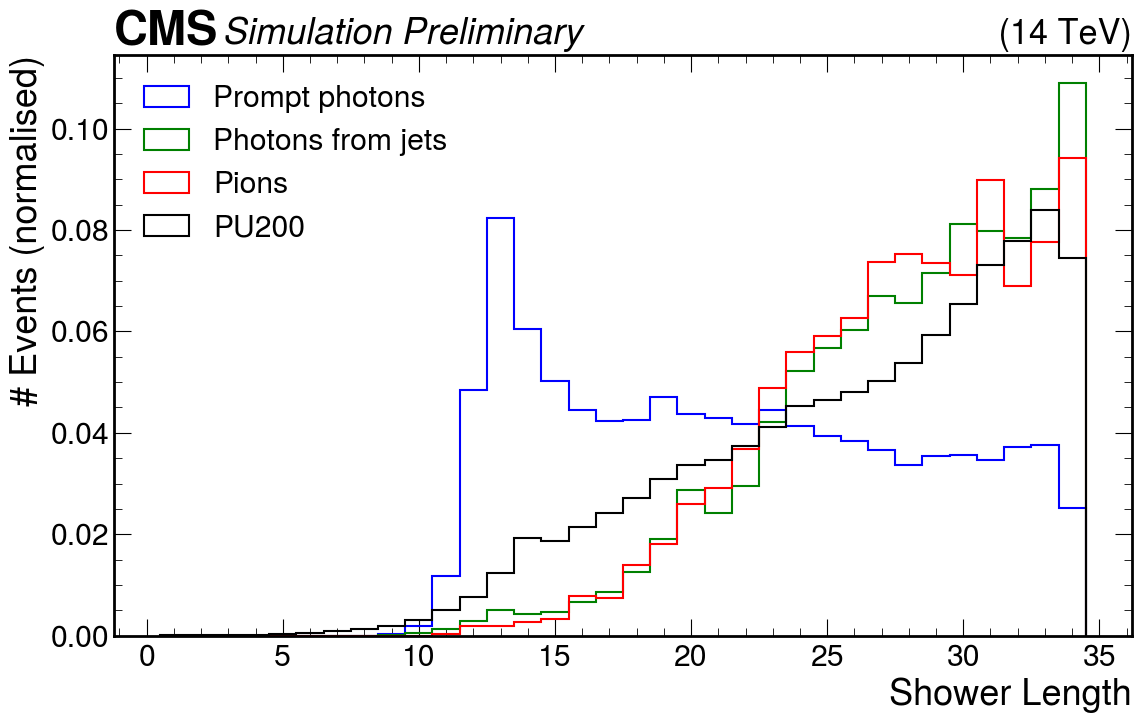

Saved: hardware_plots/cl3d_p0113Tri_hw_coreShowerLength_histogram_p0113.pdf


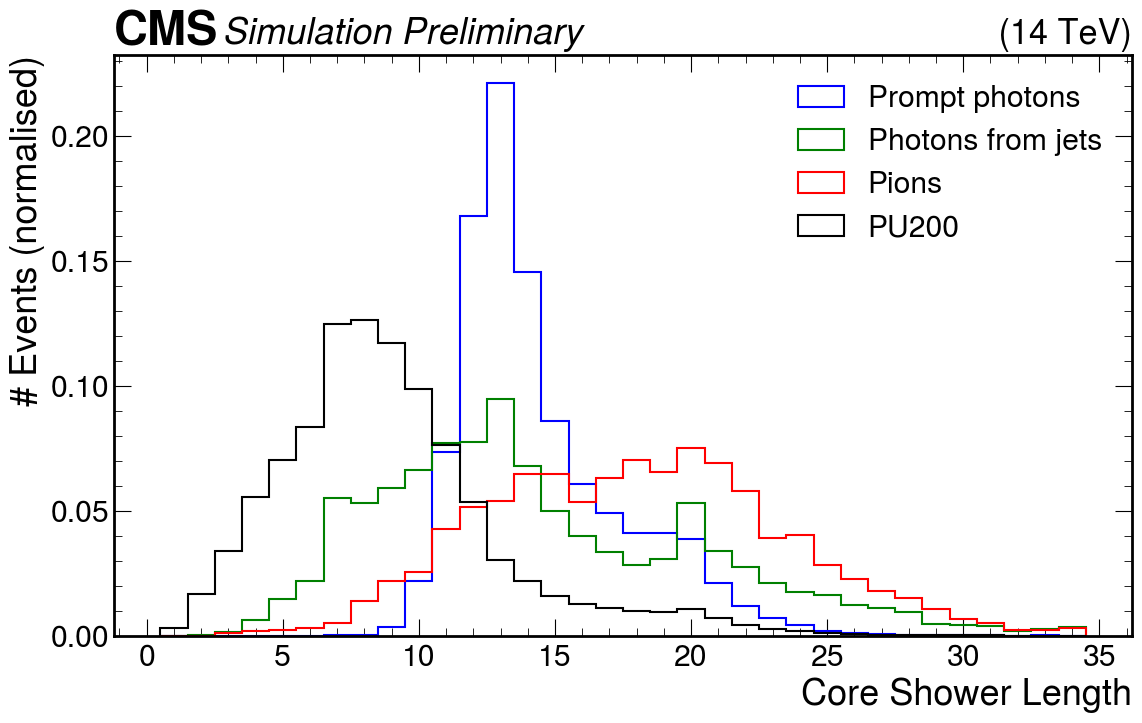

Saved: hardware_plots/cl3d_p0113Tri_hw_firstLayer_histogram_p0113.pdf


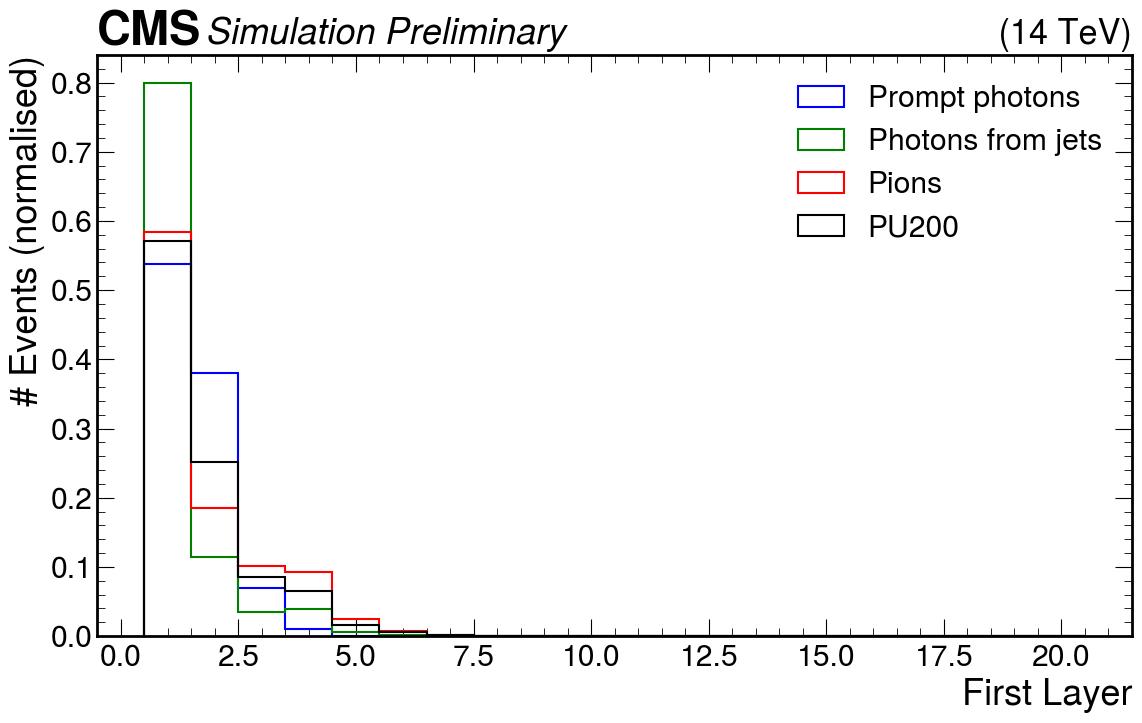

Saved: hardware_plots/cl3d_p0113Tri_hw_lastLayer_histogram_p0113.pdf


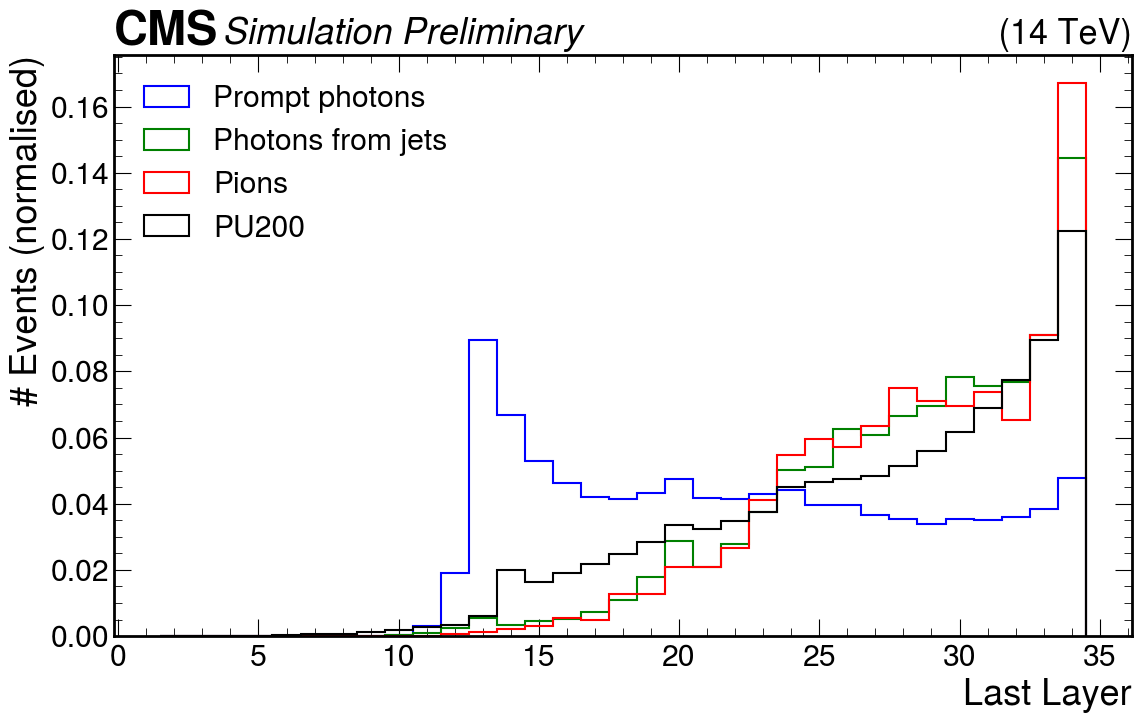

Saved: hardware_plots/cl3d_p0113Tri_hw_z_histogram_p0113.pdf


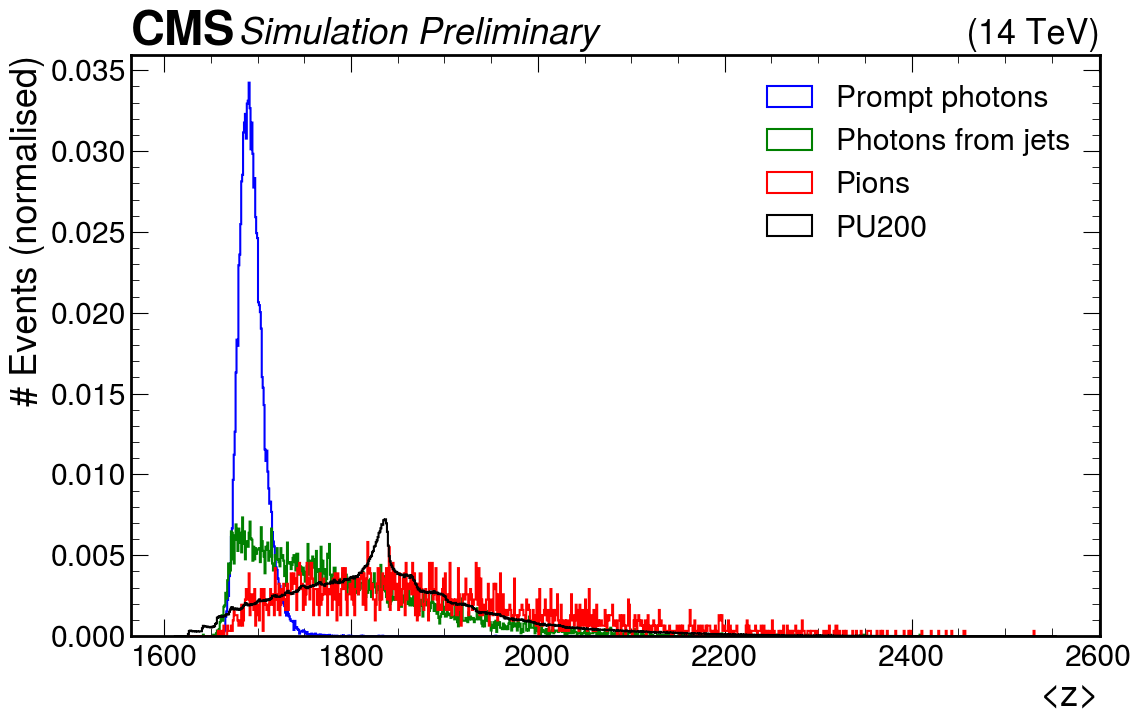

Saved: hardware_plots/cl3d_p0113Tri_hw_sigma_roz_histogram_p0113.pdf


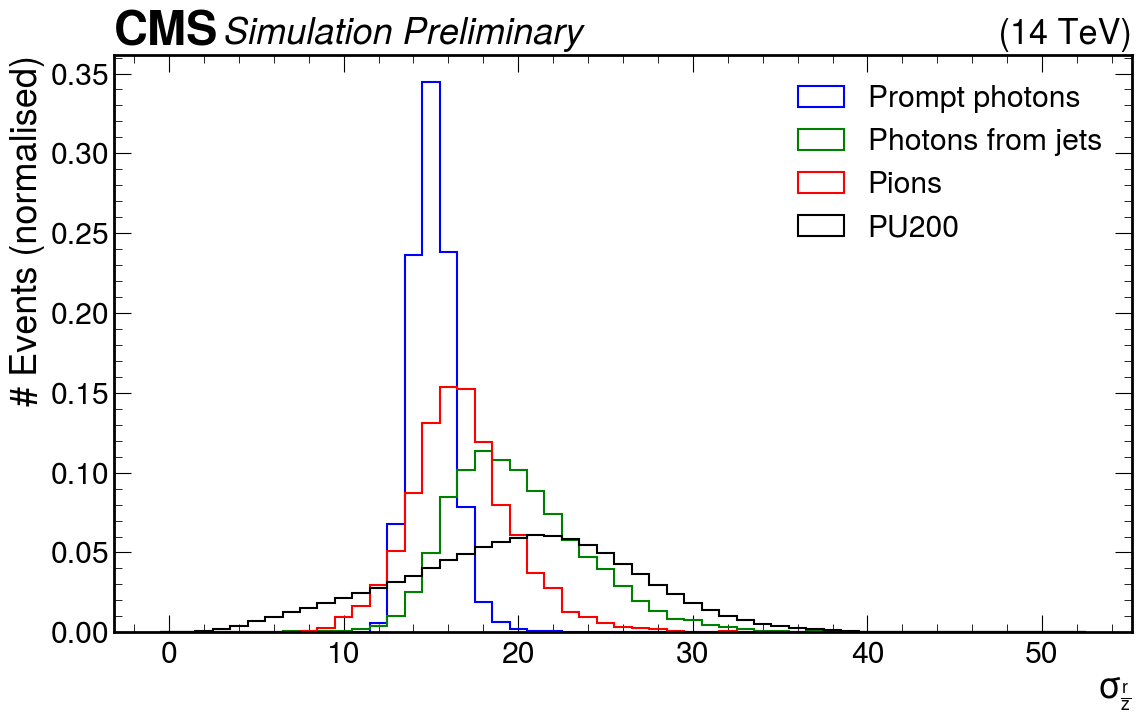

Saved: hardware_plots/cl3d_p0113Tri_hw_sigma_eta_histogram_p0113.pdf


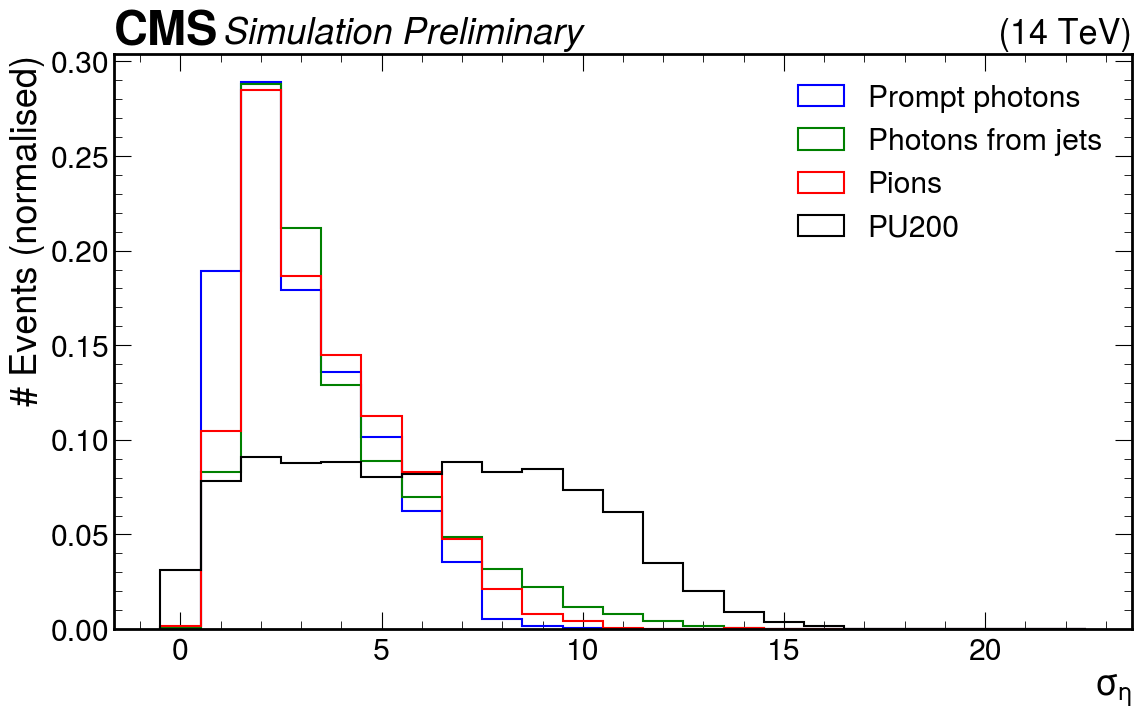

Saved: hardware_plots/cl3d_p0113Tri_hw_sigma_phi_histogram_p0113.pdf


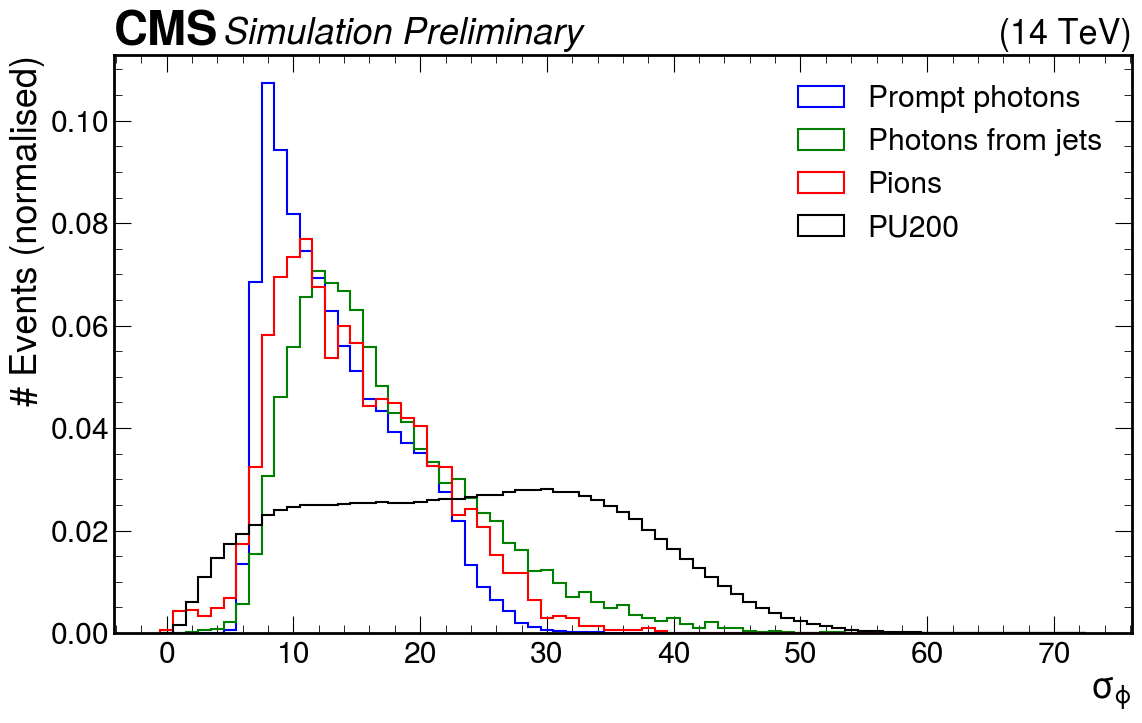

Saved: hardware_plots/cl3d_p0113Tri_hw_sigma_z_histogram_p0113.pdf


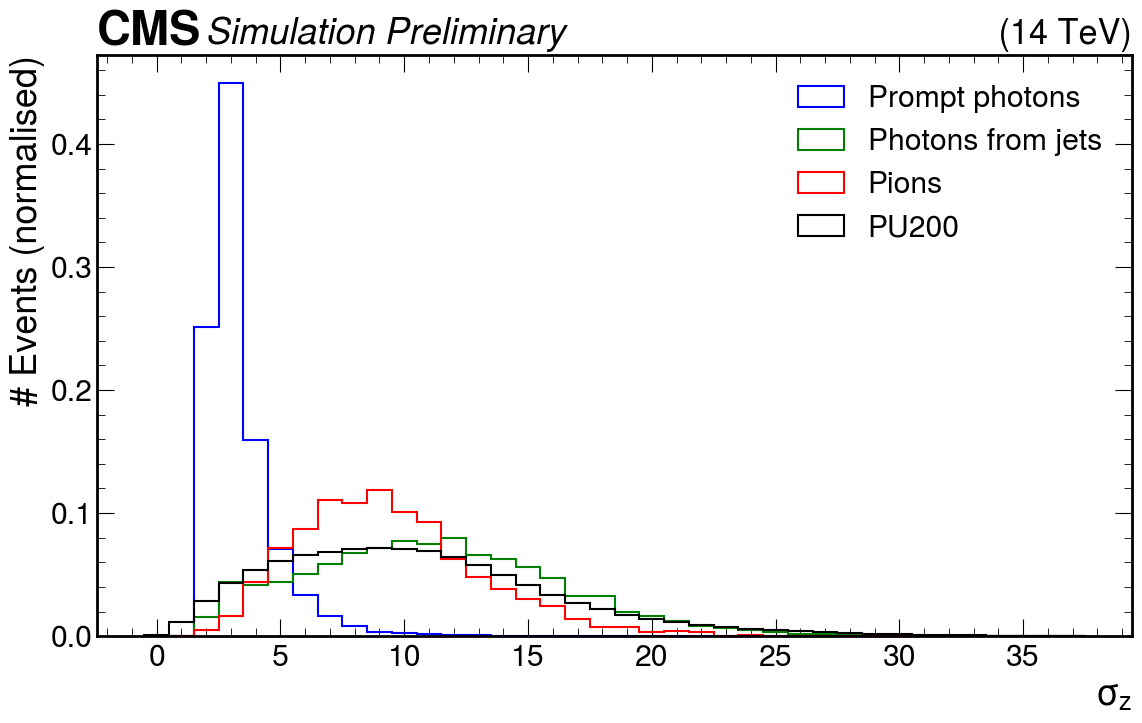

Saved: hardware_plots/cl3d_p0113Tri_hw_fractionInCE_E_histogram_p0113.pdf


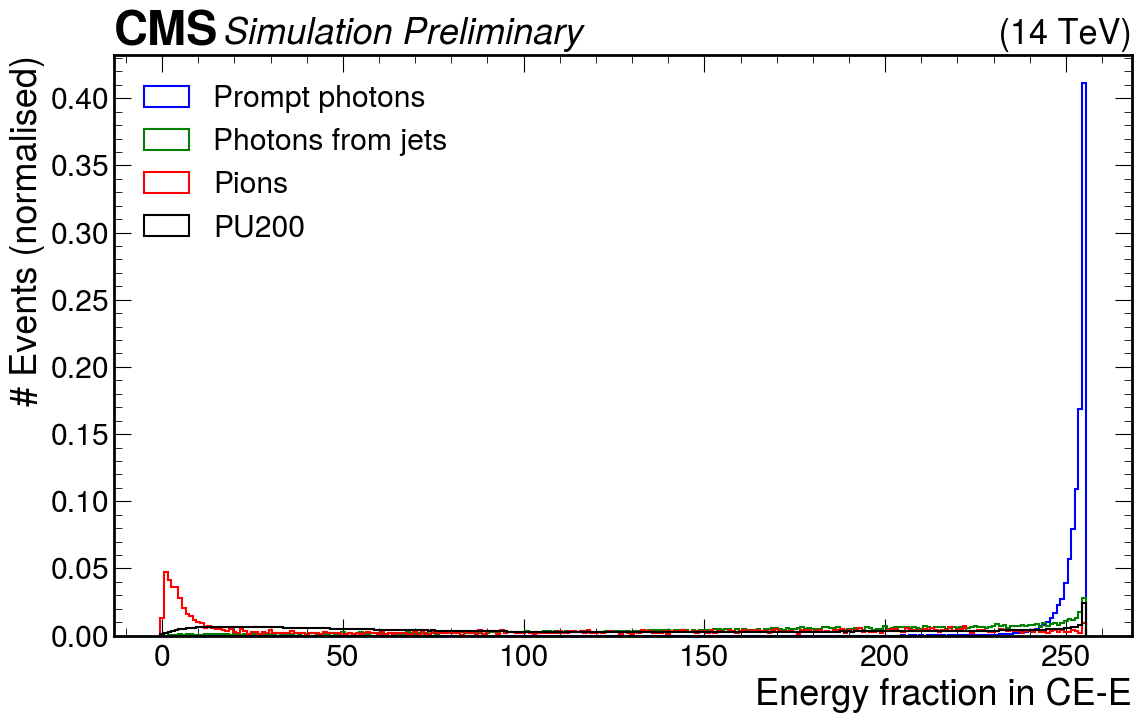

Saved: hardware_plots/cl3d_p0113Tri_hw_fractionInCoreCE_E_histogram_p0113.pdf


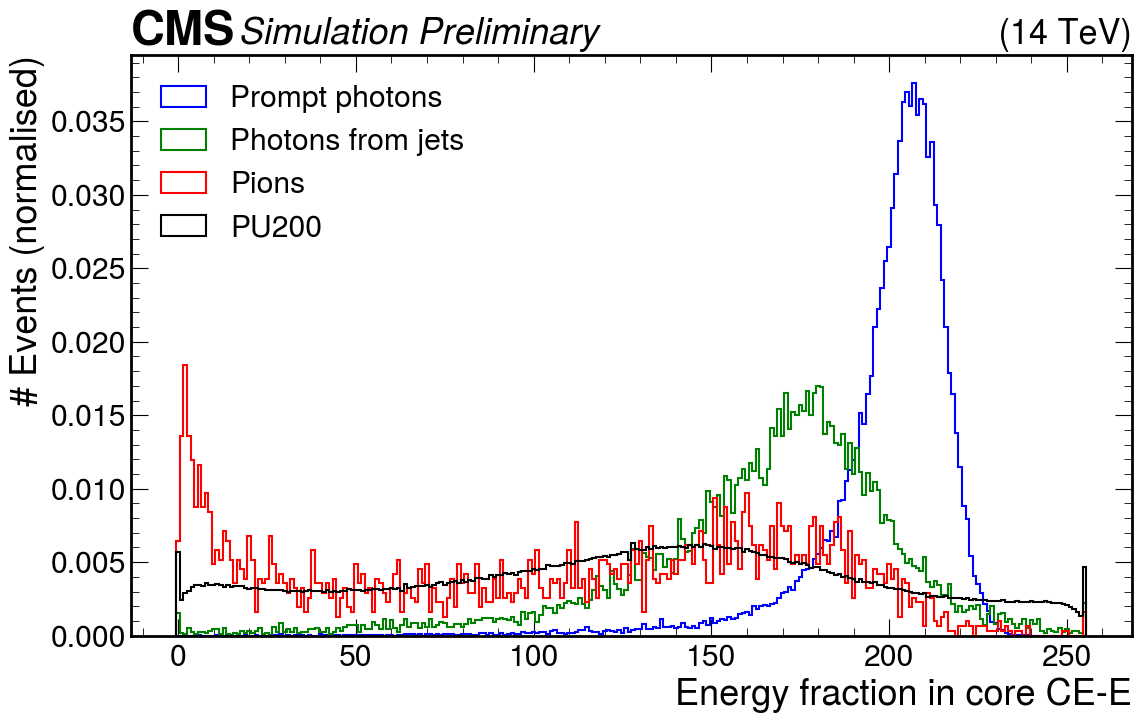

Saved: hardware_plots/cl3d_p0113Tri_hw_fractionInEarlyCE_E_histogram_p0113.pdf


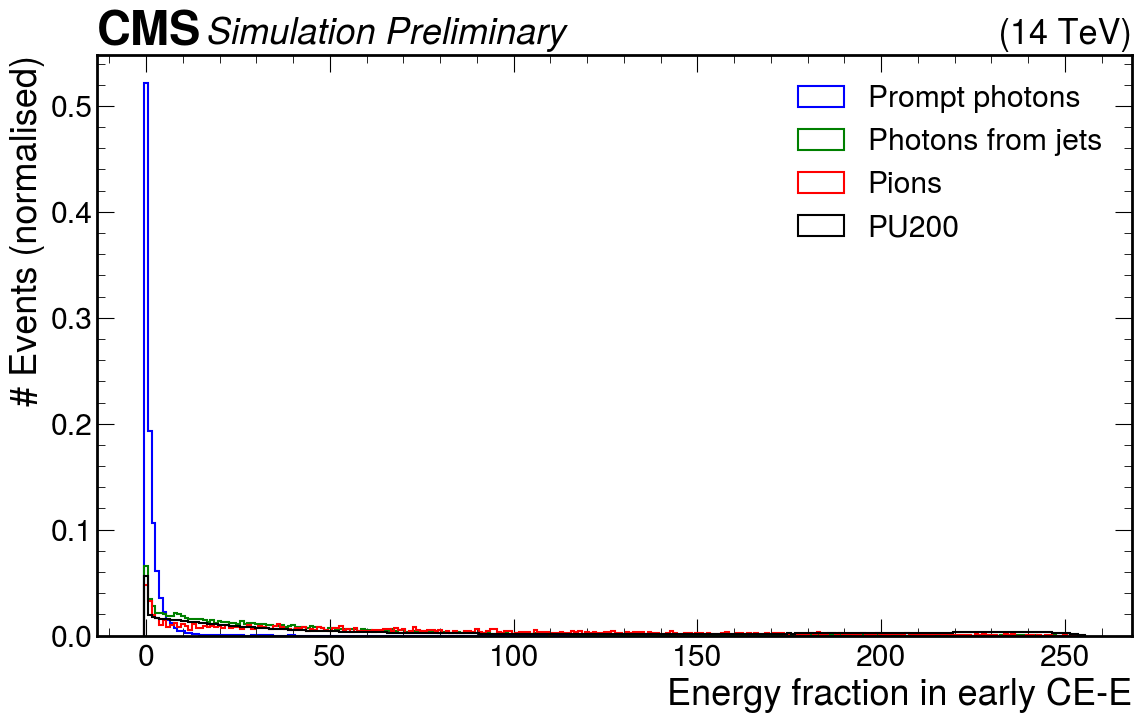

In [24]:
plot_histograms(photon_df_p0113_filtered, qcd_df_p0113_filtered, pion_df_p0113_filtered, PU_df_p0113, columns_for_training('p0113Tri'), "Prompt photons", 'Photons from jets', 'Pions', 'PU200', 'hardware_plots', var_map('p0113Tri'), 'p0113Tri')